# This notebook demonstrates using auto tune to find the best hyperparameters for a pytorch regressor
# This example is small on purpose for demonstration, if you make a larger problem it may not work in a jupyter notebook.

Import standard libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from gumps.apps.parametric_sweep import ParametricSweepApp
from gumps.solvers.sampler import SamplerSolverParameters
from gumps.solvers.regressors.xgboost_regressor import XGBoostRegressor, XGBoostParameters, OptunaParameters
from gumps.graph.regressor import RegressorPlotParameters, RegressorPlot

from gumps.studies.batch_study import AbstractBatchStudy
from typing import Callable

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create a trivial problem

In [2]:
x = np.linspace(0, 5, 1000)
y = np.linspace(0, 5, 1000)

X, Y = np.meshgrid(x, y)


Z = X+Y

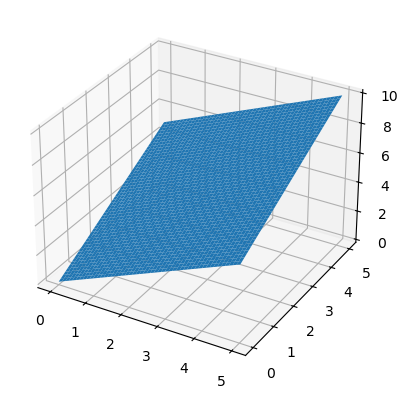

In [3]:
# Create a figure
fig = plt.figure()

# Create a 3D axis
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z)

# Create a Batch interface for the problem

In [4]:
class BatchFunction(AbstractBatchStudy):
    "batch version of sphere study (designed to approximate surrogate model)"

    def __init__(self):
        ...

    def start(self):
        "initialize this study"

    def stop(self):
        "handle shutdown tasks"

    def run(self, input_data:pd.DataFrame, processing_function:Callable) -> pd.DataFrame:
        "run the batch simulation"
        z = input_data['x'] + input_data['y']

        output_data = pd.DataFrame({'z':z})

        self.save_results(input_data, output_data)

        return processing_function(output_data)

# Sample the function

In [5]:
parameters_plot = SamplerSolverParameters(
		number_of_samples = 100,
		lower_bound = pd.Series({'x':0, 'y':0}),
		upper_bound = pd.Series({'x':5, 'y':5}),
		sampler = "sobol"
		)

def processing_function(df:pd.DataFrame) -> pd.DataFrame:
    return df

batch = BatchFunction()

app_sample = ParametricSweepApp(parameters=parameters_plot,
			processing_function=processing_function,
			directory=None,
			batch=batch)

app_sample.run()

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


# Train a regressor

In [6]:
reg_data = XGBoostParameters(input_data=app_sample.factors,
                                    output_data=app_sample.responses)

regressor = XGBoostRegressor(reg_data)
regressor.fit()

[0]	validation_0-rmse:0.16681
[1]	validation_0-rmse:0.13226
[2]	validation_0-rmse:0.11045
[3]	validation_0-rmse:0.08762
[4]	validation_0-rmse:0.07690
[5]	validation_0-rmse:0.06673
[6]	validation_0-rmse:0.06011
[7]	validation_0-rmse:0.05352
[8]	validation_0-rmse:0.05041
[9]	validation_0-rmse:0.04798
[10]	validation_0-rmse:0.04255
[11]	validation_0-rmse:0.03797
[12]	validation_0-rmse:0.03476
[13]	validation_0-rmse:0.03262
[14]	validation_0-rmse:0.03118
[15]	validation_0-rmse:0.03007
[16]	validation_0-rmse:0.02929
[17]	validation_0-rmse:0.02873
[18]	validation_0-rmse:0.02844
[19]	validation_0-rmse:0.02822
[20]	validation_0-rmse:0.02818
[21]	validation_0-rmse:0.02820
[22]	validation_0-rmse:0.02823
[23]	validation_0-rmse:0.02834


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:0.02843
[25]	validation_0-rmse:0.02847
[26]	validation_0-rmse:0.02853
[27]	validation_0-rmse:0.02862
[28]	validation_0-rmse:0.02861
[29]	validation_0-rmse:0.02861
[30]	validation_0-rmse:0.02857


# Check the regressor

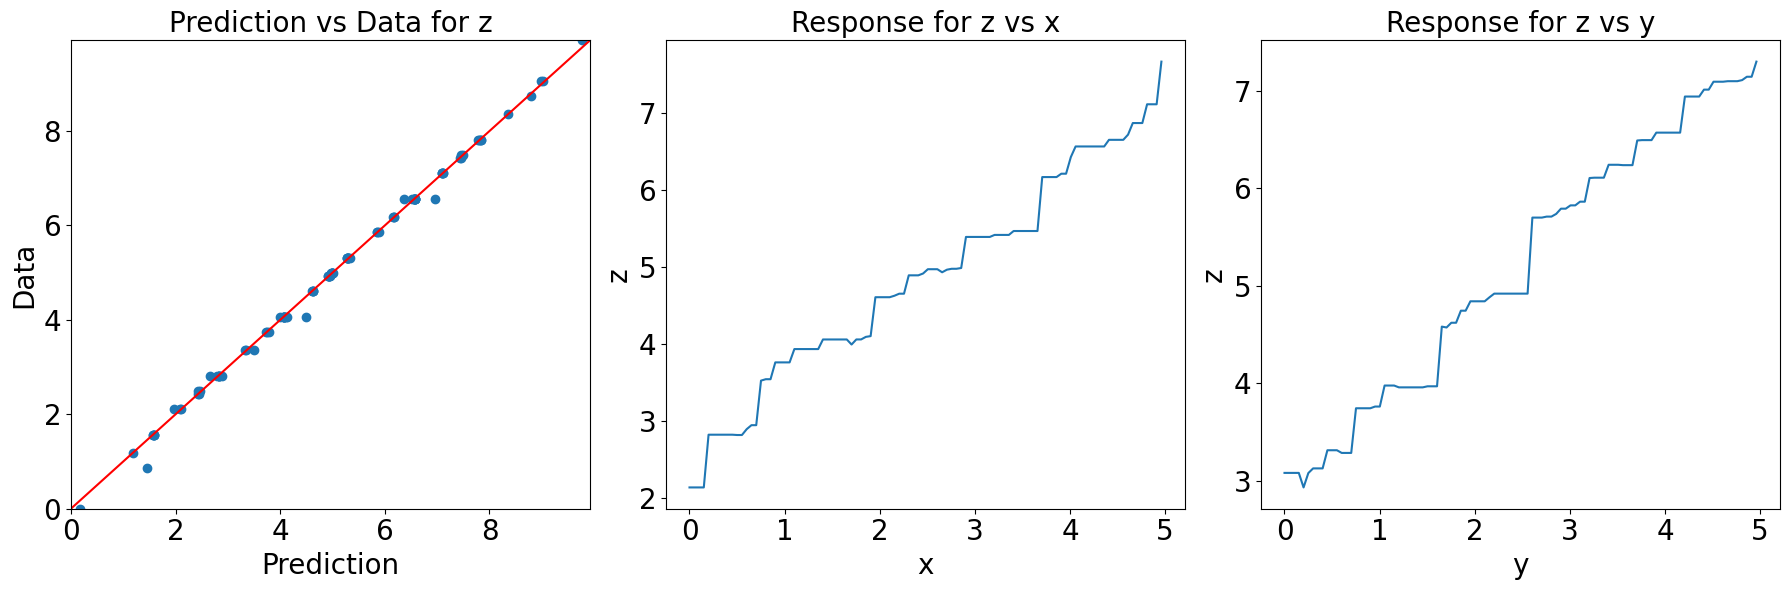

nrmse 0.009586638252029983


In [8]:
params = RegressorPlotParameters(regressor,
                                 regressor.parameters.input_data.mean(),
                                 regressor.parameters.input_data.min(),
                                 regressor.parameters.input_data.max())

reg_plot = RegressorPlot(params)

reg_plot.plot()

print("nrmse", regressor.error_metrics()['nrmse'])


before = pd.Series({'booster':regressor.parameters.booster,
                    'gamma':regressor.parameters.gamma,
                    'max_depth':regressor.parameters.max_depth,
                    'min_child_weight':regressor.parameters.min_child_weight,
                    'n_estimators':regressor.parameters.n_estimators,
                    'num_parallel_tree':regressor.parameters.num_parallel_tree,
                    'learning_rate':regressor.parameters.learning_rate,
                    'nrmse':regressor.error_metrics()['nrmse']})

# Setup and run auto tune

In [9]:
parameters = OptunaParameters(
    number_of_trials=100,
    min_epochs=50)

In [10]:
regressor.auto_tune(parameters)

[I 2024-03-18 12:24:56,676] A new study created in memory with name: no-name-ec36b916-9e17-4f5d-b734-6ae3698e69e2


[0]	validation_0-rmse:0.14052
[1]	validation_0-rmse:0.13981
[2]	validation_0-rmse:0.13939
[3]	validation_0-rmse:0.13869
[4]	validation_0-rmse:0.13828
[5]	validation_0-rmse:0.13759
[6]	validation_0-rmse:0.13719
[7]	validation_0-rmse:0.13651
[8]	validation_0-rmse:0.13612
[9]	validation_0-rmse:0.13545
[10]	validation_0-rmse:0.13477
[11]	validation_0-rmse:0.13440
[12]	validation_0-rmse:0.13373
[13]	validation_0-rmse:0.13308
[14]	validation_0-rmse:0.13242
[15]	validation_0-rmse:0.13206
[16]	validation_0-rmse:0.13141
[17]	validation_0-rmse:0.13078
[18]	validation_0-rmse:0.13044
[19]	validation_0-rmse:0.12979


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.12918
[21]	validation_0-rmse:0.12855
[22]	validation_0-rmse:0.12819
[23]	validation_0-rmse:0.12757
[24]	validation_0-rmse:0.12725
[25]	validation_0-rmse:0.12666
[26]	validation_0-rmse:0.12604
[27]	validation_0-rmse:0.12571
[28]	validation_0-rmse:0.12511
[29]	validation_0-rmse:0.12454
[30]	validation_0-rmse:0.12394
[31]	validation_0-rmse:0.12361
[32]	validation_0-rmse:0.12307
[33]	validation_0-rmse:0.12248
[34]	validation_0-rmse:0.12218
[35]	validation_0-rmse:0.12158
[36]	validation_0-rmse:0.12105
[37]	validation_0-rmse:0.12048
[38]	validation_0-rmse:0.12023
[39]	validation_0-rmse:0.11963
[40]	validation_0-rmse:0.11934
[41]	validation_0-rmse:0.11878
[42]	validation_0-rmse:0.11828
[43]	validation_0-rmse:0.11770
[44]	validation_0-rmse:0.11742
[45]	validation_0-rmse:0.11693
[46]	validation_0-rmse:0.11632
[47]	validation_0-rmse:0.11609
[48]	validation_0-rmse:0.11556
[49]	validation_0-rmse:0.11508
[50]	validation_0-rmse:0.11449
[51]	validation_0-rmse:0.11424
[52]	val

[I 2024-03-18 12:25:29,541] Trial 0 finished with value: 0.04150002256801496 and parameters: {'booster': 'dart', 'gamma': 9.073727482843995e-08, 'max_depth': 1, 'min_child_weight': 0.0013472562725159092, 'n_estimators': 459, 'num_parallel_tree': 4, 'learning_rate': 0.011711969460387406}. Best is trial 0 with value: 0.04150002256801496.


[0]	validation_0-rmse:0.20675
[1]	validation_0-rmse:0.19180
[2]	validation_0-rmse:0.17902
[3]	validation_0-rmse:0.16567
[4]	validation_0-rmse:0.15365
[5]	validation_0-rmse:0.14272
[6]	validation_0-rmse:0.13239
[7]	validation_0-rmse:0.12438
[8]	validation_0-rmse:0.11648
[9]	validation_0-rmse:0.10943
[10]	validation_0-rmse:0.10271
[11]	validation_0-rmse:0.09674
[12]	validation_0-rmse:0.09135
[13]	validation_0-rmse:0.08691
[14]	validation_0-rmse:0.08246
[15]	validation_0-rmse:0.07925
[16]	validation_0-rmse:0.07570
[17]	validation_0-rmse:0.07328
[18]	validation_0-rmse:0.06972
[19]	validation_0-rmse:0.06697
[20]	validation_0-rmse:0.06476
[21]	validation_0-rmse:0.06268
[22]	validation_0-rmse:0.05879


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-rmse:0.05704
[24]	validation_0-rmse:0.05375
[25]	validation_0-rmse:0.05243
[26]	validation_0-rmse:0.05120
[27]	validation_0-rmse:0.04992
[28]	validation_0-rmse:0.04877
[29]	validation_0-rmse:0.04776
[30]	validation_0-rmse:0.04669
[31]	validation_0-rmse:0.04580
[32]	validation_0-rmse:0.04496
[33]	validation_0-rmse:0.04399
[34]	validation_0-rmse:0.04310
[35]	validation_0-rmse:0.04225
[36]	validation_0-rmse:0.04154
[37]	validation_0-rmse:0.04088
[38]	validation_0-rmse:0.04027
[39]	validation_0-rmse:0.03974


[I 2024-03-18 12:25:29,915] Trial 1 finished with value: 0.018334024754956352 and parameters: {'booster': 'gbtree', 'gamma': 5.67041835870078e-07, 'max_depth': 7, 'min_child_weight': 0.09695964560809622, 'n_estimators': 40, 'num_parallel_tree': 9, 'learning_rate': 0.0911038790993511}. Best is trial 1 with value: 0.018334024754956352.


[0]	validation_0-rmse:0.20319
[1]	validation_0-rmse:0.18610
[2]	validation_0-rmse:0.17162
[3]	validation_0-rmse:0.15990
[4]	validation_0-rmse:0.14657
[5]	validation_0-rmse:0.13469
[6]	validation_0-rmse:0.12950
[7]	validation_0-rmse:0.12560
[8]	validation_0-rmse:0.12135
[9]	validation_0-rmse:0.11261
[10]	validation_0-rmse:0.10715
[11]	validation_0-rmse:0.09991
[12]	validation_0-rmse:0.09772
[13]	validation_0-rmse:0.09494
[14]	validation_0-rmse:0.08815
[15]	validation_0-rmse:0.08508
[16]	validation_0-rmse:0.08059
[17]	validation_0-rmse:0.07581
[18]	validation_0-rmse:0.07289
[19]	validation_0-rmse:0.07115
[20]	validation_0-rmse:0.07108
[21]	validation_0-rmse:0.06751
[22]	validation_0-rmse:0.06564
[23]	validation_0-rmse:0.06498
[24]	validation_0-rmse:0.06248
[25]	validation_0-rmse:0.06116
[26]	validation_0-rmse:0.06103
[27]	validation_0-rmse:0.06112
[28]	validation_0-rmse:0.05894
[29]	validation_0-rmse:0.05781
[30]	validation_0-rmse:0.05712
[31]	validation_0-rmse:0.05558
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-rmse:0.04694
[45]	validation_0-rmse:0.04696
[46]	validation_0-rmse:0.04644
[47]	validation_0-rmse:0.04641
[48]	validation_0-rmse:0.04593
[49]	validation_0-rmse:0.04509
[50]	validation_0-rmse:0.04512
[51]	validation_0-rmse:0.04509
[52]	validation_0-rmse:0.04515
[53]	validation_0-rmse:0.04510
[54]	validation_0-rmse:0.04512
[55]	validation_0-rmse:0.04510
[56]	validation_0-rmse:0.04512
[57]	validation_0-rmse:0.04480
[58]	validation_0-rmse:0.04426
[59]	validation_0-rmse:0.04396
[60]	validation_0-rmse:0.04395
[61]	validation_0-rmse:0.04373
[62]	validation_0-rmse:0.04341
[63]	validation_0-rmse:0.04343
[64]	validation_0-rmse:0.04341
[65]	validation_0-rmse:0.04313
[66]	validation_0-rmse:0.04315
[67]	validation_0-rmse:0.04318
[68]	validation_0-rmse:0.04315
[69]	validation_0-rmse:0.04314
[70]	validation_0-rmse:0.04315
[71]	validation_0-rmse:0.04314
[72]	validation_0-rmse:0.04298
[73]	validation_0-rmse:0.04285
[74]	validation_0-rmse:0.04270
[75]	validation_0-rmse:0.04252
[76]	val

[I 2024-03-18 12:25:31,819] Trial 2 finished with value: 0.012501949491913193 and parameters: {'booster': 'gbtree', 'gamma': 1.1124559654496573e-05, 'max_depth': 1, 'min_child_weight': 0.06621024150931829, 'n_estimators': 436, 'num_parallel_tree': 4, 'learning_rate': 0.23190516080744414}. Best is trial 2 with value: 0.012501949491913193.


[0]	validation_0-rmse:0.17579
[1]	validation_0-rmse:0.15058
[2]	validation_0-rmse:0.14500
[3]	validation_0-rmse:0.13868
[4]	validation_0-rmse:0.11836
[5]	validation_0-rmse:0.11355
[6]	validation_0-rmse:0.09929
[7]	validation_0-rmse:0.09528
[8]	validation_0-rmse:0.08706
[9]	validation_0-rmse:0.08034
[10]	validation_0-rmse:0.07804
[11]	validation_0-rmse:0.07032
[12]	validation_0-rmse:0.06681
[13]	validation_0-rmse:0.06247
[14]	validation_0-rmse:0.05952
[15]	validation_0-rmse:0.05710
[16]	validation_0-rmse:0.05607
[17]	validation_0-rmse:0.05288
[18]	validation_0-rmse:0.05134
[19]	validation_0-rmse:0.04985
[20]	validation_0-rmse:0.04815
[21]	validation_0-rmse:0.04788
[22]	validation_0-rmse:0.04737
[23]	validation_0-rmse:0.04655
[24]	validation_0-rmse:0.04632
[25]	validation_0-rmse:0.04548
[26]	validation_0-rmse:0.04502
[27]	validation_0-rmse:0.04434
[28]	validation_0-rmse:0.04432
[29]	validation_0-rmse:0.04415
[30]	validation_0-rmse:0.04378
[31]	validation_0-rmse:0.04360
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-03-18 12:25:31,987] Trial 3 finished with value: 0.01681661400829061 and parameters: {'booster': 'gbtree', 'gamma': 0.00015858692019386712, 'max_depth': 2, 'min_child_weight': 0.6690606488241769, 'n_estimators': 118, 'num_parallel_tree': 8, 'learning_rate': 0.28846411475609063}. Best is trial 2 with value: 0.012501949491913193.


[0]	validation_0-rmse:0.22745
[1]	validation_0-rmse:0.22679
[2]	validation_0-rmse:0.22528
[3]	validation_0-rmse:0.22309
[4]	validation_0-rmse:0.22044
[5]	validation_0-rmse:0.21737
[6]	validation_0-rmse:0.21432
[7]	validation_0-rmse:0.21116
[8]	validation_0-rmse:0.20794
[9]	validation_0-rmse:0.20472
[10]	validation_0-rmse:0.20151


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:0.19823
[12]	validation_0-rmse:0.19513
[13]	validation_0-rmse:0.19206
[14]	validation_0-rmse:0.18901
[15]	validation_0-rmse:0.18591
[16]	validation_0-rmse:0.18299
[17]	validation_0-rmse:0.18010
[18]	validation_0-rmse:0.17724
[19]	validation_0-rmse:0.17441
[20]	validation_0-rmse:0.17163
[21]	validation_0-rmse:0.16887
[22]	validation_0-rmse:0.16618
[23]	validation_0-rmse:0.16352
[24]	validation_0-rmse:0.16090
[25]	validation_0-rmse:0.15832
[26]	validation_0-rmse:0.15582
[27]	validation_0-rmse:0.15335
[28]	validation_0-rmse:0.15090
[29]	validation_0-rmse:0.14841
[30]	validation_0-rmse:0.14599
[31]	validation_0-rmse:0.14371
[32]	validation_0-rmse:0.14144
[33]	validation_0-rmse:0.13919
[34]	validation_0-rmse:0.13697
[35]	validation_0-rmse:0.13478
[36]	validation_0-rmse:0.13262
[37]	validation_0-rmse:0.13049
[38]	validation_0-rmse:0.12840
[39]	validation_0-rmse:0.12633
[40]	validation_0-rmse:0.12430
[41]	validation_0-rmse:0.12230
[42]	validation_0-rmse:0.12027
[43]	val

[I 2024-03-18 12:25:32,110] Trial 4 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.24778
[1]	validation_0-rmse:0.23974
[2]	validation_0-rmse:0.23208
[3]	validation_0-rmse:0.22489
[4]	validation_0-rmse:0.21822
[5]	validation_0-rmse:0.21159
[6]	validation_0-rmse:0.20569


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:0.19989
[8]	validation_0-rmse:0.19385
[9]	validation_0-rmse:0.18862
[10]	validation_0-rmse:0.18330
[11]	validation_0-rmse:0.17799
[12]	validation_0-rmse:0.17313
[13]	validation_0-rmse:0.16852
[14]	validation_0-rmse:0.16407
[15]	validation_0-rmse:0.15982
[16]	validation_0-rmse:0.15575
[17]	validation_0-rmse:0.15170
[18]	validation_0-rmse:0.14781
[19]	validation_0-rmse:0.14396
[20]	validation_0-rmse:0.14042
[21]	validation_0-rmse:0.13697
[22]	validation_0-rmse:0.13355
[23]	validation_0-rmse:0.13047
[24]	validation_0-rmse:0.12727
[25]	validation_0-rmse:0.12420
[26]	validation_0-rmse:0.12138
[27]	validation_0-rmse:0.11860
[28]	validation_0-rmse:0.11591
[29]	validation_0-rmse:0.11324
[30]	validation_0-rmse:0.11084
[31]	validation_0-rmse:0.10823
[32]	validation_0-rmse:0.10598
[33]	validation_0-rmse:0.10381
[34]	validation_0-rmse:0.10177
[35]	validation_0-rmse:0.09983
[36]	validation_0-rmse:0.09794
[37]	validation_0-rmse:0.09596
[38]	validation_0-rmse:0.09382
[39]	valida

[I 2024-03-18 12:25:33,702] Trial 5 finished with value: 0.03830603658146113 and parameters: {'booster': 'dart', 'gamma': 0.0006841294438062965, 'max_depth': 6, 'min_child_weight': 1.9286645517674998, 'n_estimators': 50, 'num_parallel_tree': 10, 'learning_rate': 0.0480055212839097}. Best is trial 2 with value: 0.012501949491913193.


[0]	validation_0-rmse:0.19700
[1]	validation_0-rmse:0.19643
[2]	validation_0-rmse:0.19586
[3]	validation_0-rmse:0.19530
[4]	validation_0-rmse:0.19474
[5]	validation_0-rmse:0.19418


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:0.19362
[7]	validation_0-rmse:0.19307
[8]	validation_0-rmse:0.19251
[9]	validation_0-rmse:0.19195
[10]	validation_0-rmse:0.19139
[11]	validation_0-rmse:0.19083
[12]	validation_0-rmse:0.19028
[13]	validation_0-rmse:0.18973
[14]	validation_0-rmse:0.18918
[15]	validation_0-rmse:0.18863
[16]	validation_0-rmse:0.18809
[17]	validation_0-rmse:0.18755
[18]	validation_0-rmse:0.18701
[19]	validation_0-rmse:0.18647
[20]	validation_0-rmse:0.18593
[21]	validation_0-rmse:0.18540
[22]	validation_0-rmse:0.18487
[23]	validation_0-rmse:0.18434
[24]	validation_0-rmse:0.18381
[25]	validation_0-rmse:0.18329
[26]	validation_0-rmse:0.18275
[27]	validation_0-rmse:0.18223
[28]	validation_0-rmse:0.18170
[29]	validation_0-rmse:0.18118
[30]	validation_0-rmse:0.18066
[31]	validation_0-rmse:0.18014
[32]	validation_0-rmse:0.17962
[33]	validation_0-rmse:0.17911
[34]	validation_0-rmse:0.17860
[35]	validation_0-rmse:0.17809
[36]	validation_0-rmse:0.17759
[37]	validation_0-rmse:0.17707
[38]	validat

[I 2024-03-18 12:25:34,761] Trial 6 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.17287
[1]	validation_0-rmse:0.15015
[2]	validation_0-rmse:0.12862
[3]	validation_0-rmse:0.11040
[4]	validation_0-rmse:0.09653
[5]	validation_0-rmse:0.08472
[6]	validation_0-rmse:0.07599
[7]	validation_0-rmse:0.06740
[8]	validation_0-rmse:0.06090
[9]	validation_0-rmse:0.05415
[10]	validation_0-rmse:0.04883
[11]	validation_0-rmse:0.04433
[12]	validation_0-rmse:0.04050
[13]	validation_0-rmse:0.03792
[14]	validation_0-rmse:0.03549
[15]	validation_0-rmse:0.03377
[16]	validation_0-rmse:0.03308
[17]	validation_0-rmse:0.03239
[18]	validation_0-rmse:0.03177
[19]	validation_0-rmse:0.03143
[20]	validation_0-rmse:0.03091
[21]	validation_0-rmse:0.03091
[22]	validation_0-rmse:0.03069
[23]	validation_0-rmse:0.03080
[24]	validation_0-rmse:0.03066
[25]	validation_0-rmse:0.03045


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-rmse:0.03025
[27]	validation_0-rmse:0.02974
[28]	validation_0-rmse:0.02975
[29]	validation_0-rmse:0.02951
[30]	validation_0-rmse:0.02955
[31]	validation_0-rmse:0.02958
[32]	validation_0-rmse:0.02944
[33]	validation_0-rmse:0.02950
[34]	validation_0-rmse:0.02921
[35]	validation_0-rmse:0.02922
[36]	validation_0-rmse:0.02922
[37]	validation_0-rmse:0.02925
[38]	validation_0-rmse:0.02927
[39]	validation_0-rmse:0.02888
[40]	validation_0-rmse:0.02887
[41]	validation_0-rmse:0.02888
[42]	validation_0-rmse:0.02888
[43]	validation_0-rmse:0.02888
[44]	validation_0-rmse:0.02888
[45]	validation_0-rmse:0.02888
[46]	validation_0-rmse:0.02888
[47]	validation_0-rmse:0.02888
[48]	validation_0-rmse:0.02888
[49]	validation_0-rmse:0.02888


[I 2024-03-18 12:25:35,127] Trial 7 finished with value: 0.01071409038897983 and parameters: {'booster': 'gbtree', 'gamma': 0.0003501936703651325, 'max_depth': 7, 'min_child_weight': 0.003971746115818049, 'n_estimators': 556, 'num_parallel_tree': 7, 'learning_rate': 0.15244819266753515}. Best is trial 7 with value: 0.01071409038897983.


[0]	validation_0-rmse:0.14975
[1]	validation_0-rmse:0.14308
[2]	validation_0-rmse:0.13869
[3]	validation_0-rmse:0.13427
[4]	validation_0-rmse:0.13033
[5]	validation_0-rmse:0.12620
[6]	validation_0-rmse:0.12249
[7]	validation_0-rmse:0.11862
[8]	validation_0-rmse:0.11487
[9]	validation_0-rmse:0.11148
[10]	validation_0-rmse:0.10795
[11]	validation_0-rmse:0.10453
[12]	validation_0-rmse:0.10123
[13]	validation_0-rmse:0.09802
[14]	validation_0-rmse:0.09492
[15]	validation_0-rmse:0.09192
[16]	validation_0-rmse:0.08901
[17]	validation_0-rmse:0.08619
[18]	validation_0-rmse:0.08363
[19]	validation_0-rmse:0.08100
[20]	validation_0-rmse:0.07860
[21]	validation_0-rmse:0.07610
[22]	validation_0-rmse:0.07369
[23]	validation_0-rmse:0.07135
[24]	validation_0-rmse:0.06909
[25]	validation_0-rmse:0.06689
[26]	validation_0-rmse:0.06477
[27]	validation_0-rmse:0.06272
[28]	validation_0-rmse:0.06073
[29]	validation_0-rmse:0.05892
[30]	validation_0-rmse:0.05708
[31]	validation_0-rmse:0.05527
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-03-18 12:25:35,281] Trial 8 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.17815
[1]	validation_0-rmse:0.17527
[2]	validation_0-rmse:0.17220
[3]	validation_0-rmse:0.16941
[4]	validation_0-rmse:0.16644
[5]	validation_0-rmse:0.16357
[6]	validation_0-rmse:0.16076
[7]	validation_0-rmse:0.15782


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:0.15510
[9]	validation_0-rmse:0.15243
[10]	validation_0-rmse:0.14973
[11]	validation_0-rmse:0.14715
[12]	validation_0-rmse:0.14462
[13]	validation_0-rmse:0.14176
[14]	validation_0-rmse:0.13914
[15]	validation_0-rmse:0.13658
[16]	validation_0-rmse:0.13386
[17]	validation_0-rmse:0.13177
[18]	validation_0-rmse:0.12956
[19]	validation_0-rmse:0.12697
[20]	validation_0-rmse:0.12461
[21]	validation_0-rmse:0.12212
[22]	validation_0-rmse:0.11983
[23]	validation_0-rmse:0.11773
[24]	validation_0-rmse:0.11536
[25]	validation_0-rmse:0.11319
[26]	validation_0-rmse:0.11198
[27]	validation_0-rmse:0.10971
[28]	validation_0-rmse:0.10765
[29]	validation_0-rmse:0.10635
[30]	validation_0-rmse:0.10433
[31]	validation_0-rmse:0.10322
[32]	validation_0-rmse:0.10199
[33]	validation_0-rmse:0.10007
[34]	validation_0-rmse:0.09903
[35]	validation_0-rmse:0.09787
[36]	validation_0-rmse:0.09651
[37]	validation_0-rmse:0.09539
[38]	validation_0-rmse:0.09435
[39]	validation_0-rmse:0.09318
[40]	valid

[I 2024-03-18 12:25:35,727] Trial 9 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.08472
[1]	validation_0-rmse:0.07340
[2]	validation_0-rmse:0.06322
[3]	validation_0-rmse:0.06161
[4]	validation_0-rmse:0.06155
[5]	validation_0-rmse:0.06155
[6]	validation_0-rmse:0.06155
[7]	validation_0-rmse:0.06155
[8]	validation_0-rmse:0.06155
[9]	validation_0-rmse:0.06155
[10]	validation_0-rmse:0.06155
[11]	validation_0-rmse:0.06155
[12]	validation_0-rmse:0.06155
[13]	validation_0-rmse:0.06155
[14]	validation_0-rmse:0.06155
[15]	validation_0-rmse:0.06155


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-03-18 12:25:35,842] Trial 10 finished with value: 0.031478503083566825 and parameters: {'booster': 'gbtree', 'gamma': 0.006019506894773869, 'max_depth': 9, 'min_child_weight': 2.000623592963949e-06, 'n_estimators': 975, 'num_parallel_tree': 1, 'learning_rate': 0.985369935248847}. Best is trial 7 with value: 0.01071409038897983.


[0]	validation_0-rmse:0.16775
[1]	validation_0-rmse:0.16052
[2]	validation_0-rmse:0.15380
[3]	validation_0-rmse:0.14766
[4]	validation_0-rmse:0.14203
[5]	validation_0-rmse:0.13663
[6]	validation_0-rmse:0.13171


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:0.12719
[8]	validation_0-rmse:0.12254
[9]	validation_0-rmse:0.11836
[10]	validation_0-rmse:0.11359
[11]	validation_0-rmse:0.10867
[12]	validation_0-rmse:0.10552
[13]	validation_0-rmse:0.10070
[14]	validation_0-rmse:0.09794
[15]	validation_0-rmse:0.09503
[16]	validation_0-rmse:0.09156
[17]	validation_0-rmse:0.08940
[18]	validation_0-rmse:0.08632
[19]	validation_0-rmse:0.08418
[20]	validation_0-rmse:0.08194
[21]	validation_0-rmse:0.07935
[22]	validation_0-rmse:0.07617
[23]	validation_0-rmse:0.07427
[24]	validation_0-rmse:0.07215
[25]	validation_0-rmse:0.07059
[26]	validation_0-rmse:0.06930
[27]	validation_0-rmse:0.06761
[28]	validation_0-rmse:0.06595
[29]	validation_0-rmse:0.06468
[30]	validation_0-rmse:0.06368
[31]	validation_0-rmse:0.06278
[32]	validation_0-rmse:0.06162
[33]	validation_0-rmse:0.06080
[34]	validation_0-rmse:0.05990
[35]	validation_0-rmse:0.05913
[36]	validation_0-rmse:0.05826
[37]	validation_0-rmse:0.05701
[38]	validation_0-rmse:0.05638
[39]	valida

[I 2024-03-18 12:25:36,295] Trial 11 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.13850
[1]	validation_0-rmse:0.13838
[2]	validation_0-rmse:0.13827
[3]	validation_0-rmse:0.13815
[4]	validation_0-rmse:0.13804
[5]	validation_0-rmse:0.13793
[6]	validation_0-rmse:0.13781
[7]	validation_0-rmse:0.13770
[8]	validation_0-rmse:0.13759
[9]	validation_0-rmse:0.13747
[10]	validation_0-rmse:0.13736
[11]	validation_0-rmse:0.13725
[12]	validation_0-rmse:0.13713
[13]	validation_0-rmse:0.13702
[14]	validation_0-rmse:0.13691
[15]	validation_0-rmse:0.13680
[16]	validation_0-rmse:0.13669
[17]	validation_0-rmse:0.13657
[18]	validation_0-rmse:0.13646
[19]	validation_0-rmse:0.13635
[20]	validation_0-rmse:0.13624
[21]	validation_0-rmse:0.13613
[22]	validation_0-rmse:0.13601
[23]	validation_0-rmse:0.13590
[24]	validation_0-rmse:0.13579

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(



[25]	validation_0-rmse:0.13568
[26]	validation_0-rmse:0.13557
[27]	validation_0-rmse:0.13546
[28]	validation_0-rmse:0.13535
[29]	validation_0-rmse:0.13524
[30]	validation_0-rmse:0.13513
[31]	validation_0-rmse:0.13501
[32]	validation_0-rmse:0.13490
[33]	validation_0-rmse:0.13479
[34]	validation_0-rmse:0.13468
[35]	validation_0-rmse:0.13457
[36]	validation_0-rmse:0.13446
[37]	validation_0-rmse:0.13435
[38]	validation_0-rmse:0.13424
[39]	validation_0-rmse:0.13414
[40]	validation_0-rmse:0.13403
[41]	validation_0-rmse:0.13392
[42]	validation_0-rmse:0.13381
[43]	validation_0-rmse:0.13370
[44]	validation_0-rmse:0.13359
[45]	validation_0-rmse:0.13348
[46]	validation_0-rmse:0.13337
[47]	validation_0-rmse:0.13326
[48]	validation_0-rmse:0.13315
[49]	validation_0-rmse:0.13305


[I 2024-03-18 12:25:36,667] Trial 12 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.22089
[1]	validation_0-rmse:0.22089
[2]	validation_0-rmse:0.22089
[3]	validation_0-rmse:0.22089
[4]	validation_0-rmse:0.22089
[5]	validation_0-rmse:0.22089
[6]	validation_0-rmse:0.22089
[7]	validation_0-rmse:0.22089
[8]	validation_0-rmse:0.22089
[9]	validation_0-rmse:0.22089
[10]	validation_0-rmse:0.22089


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-03-18 12:25:36,753] Trial 13 finished with value: 0.20812477294825923 and parameters: {'booster': 'gbtree', 'gamma': 5.4915156363934555e-05, 'max_depth': 4, 'min_child_weight': 62.205383381191226, 'n_estimators': 297, 'num_parallel_tree': 7, 'learning_rate': 0.5985495047932893}. Best is trial 7 with value: 0.01071409038897983.


[0]	validation_0-rmse:0.14587
[1]	validation_0-rmse:0.13979
[2]	validation_0-rmse:0.13466
[3]	validation_0-rmse:0.12755
[4]	validation_0-rmse:0.12245
[5]	validation_0-rmse:0.11729
[6]	validation_0-rmse:0.10958
[7]	validation_0-rmse:0.10352
[8]	validation_0-rmse:0.09708
[9]	validation_0-rmse:0.08914
[10]	validation_0-rmse:0.08326
[11]	validation_0-rmse:0.08039
[12]	validation_0-rmse:0.07537
[13]	validation_0-rmse:0.07215
[14]	validation_0-rmse:0.06857
[15]	validation_0-rmse:0.06492
[16]	validation_0-rmse:0.06237


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-rmse:0.06017
[18]	validation_0-rmse:0.05758
[19]	validation_0-rmse:0.05627
[20]	validation_0-rmse:0.05482
[21]	validation_0-rmse:0.05347
[22]	validation_0-rmse:0.05262
[23]	validation_0-rmse:0.05044
[24]	validation_0-rmse:0.04863
[25]	validation_0-rmse:0.04739
[26]	validation_0-rmse:0.04661
[27]	validation_0-rmse:0.04546
[28]	validation_0-rmse:0.04494
[29]	validation_0-rmse:0.04399
[30]	validation_0-rmse:0.04348
[31]	validation_0-rmse:0.04268
[32]	validation_0-rmse:0.04211
[33]	validation_0-rmse:0.04154
[34]	validation_0-rmse:0.04133
[35]	validation_0-rmse:0.04078
[36]	validation_0-rmse:0.04020
[37]	validation_0-rmse:0.03990
[38]	validation_0-rmse:0.03944
[39]	validation_0-rmse:0.03927
[40]	validation_0-rmse:0.03884
[41]	validation_0-rmse:0.03852
[42]	validation_0-rmse:0.03825
[43]	validation_0-rmse:0.03789
[44]	validation_0-rmse:0.03778
[45]	validation_0-rmse:0.03764
[46]	validation_0-rmse:0.03754
[47]	validation_0-rmse:0.03726
[48]	validation_0-rmse:0.03712
[49]	val

[I 2024-03-18 12:25:37,029] Trial 14 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.23967
[1]	validation_0-rmse:0.23497
[2]	validation_0-rmse:0.22615
[3]	validation_0-rmse:0.21666
[4]	validation_0-rmse:0.20733
[5]	validation_0-rmse:0.19836
[6]	validation_0-rmse:0.18976
[7]	validation_0-rmse:0.18152
[8]	validation_0-rmse:0.17365
[9]	validation_0-rmse:0.16611
[10]	validation_0-rmse:0.15890
[11]	validation_0-rmse:0.15200
[12]	validation_0-rmse:0.14488
[13]	validation_0-rmse:0.13914
[14]	validation_0-rmse:0.13275
[15]	validation_0-rmse:0.12753
[16]	validation_0-rmse:0.12198
[17]	validation_0-rmse:0.11644
[18]	validation_0-rmse:0.11147
[19]	validation_0-rmse:0.10680
[20]	validation_0-rmse:0.10235
[21]	validation_0-rmse:0.09810
[22]	validation_0-rmse:0.09435
[23]	validation_0-rmse:0.09008
[24]	validation_0-rmse:0.08624
[25]	validation_0-rmse:0.08292
[26]	validation_0-rmse:0.07916
[27]	validation_0-rmse:0.07585
[28]	validation_0-rmse:0.07263
[29]	validation_0-rmse:0.06979
[30]	validation_0-rmse:0.06662
[31]	validation_0-rmse:0.06399
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[52]	validation_0-rmse:0.02528
[53]	validation_0-rmse:0.02421
[54]	validation_0-rmse:0.02320
[55]	validation_0-rmse:0.02224
[56]	validation_0-rmse:0.02132
[57]	validation_0-rmse:0.02050
[58]	validation_0-rmse:0.01957
[59]	validation_0-rmse:0.01874
[60]	validation_0-rmse:0.01795
[61]	validation_0-rmse:0.01721
[62]	validation_0-rmse:0.01649
[63]	validation_0-rmse:0.01581
[64]	validation_0-rmse:0.01520
[65]	validation_0-rmse:0.01452
[66]	validation_0-rmse:0.01394
[67]	validation_0-rmse:0.01331
[68]	validation_0-rmse:0.01274
[69]	validation_0-rmse:0.01221
[70]	validation_0-rmse:0.01170
[71]	validation_0-rmse:0.01122
[72]	validation_0-rmse:0.01075
[73]	validation_0-rmse:0.01034
[74]	validation_0-rmse:0.00990
[75]	validation_0-rmse:0.00948
[76]	validation_0-rmse:0.00904
[77]	validation_0-rmse:0.00865
[78]	validation_0-rmse:0.00829
[79]	validation_0-rmse:0.00795
[80]	validation_0-rmse:0.00764
[81]	validation_0-rmse:0.00732
[82]	validation_0-rmse:0.00698
[83]	validation_0-rmse:0.00670
[84]	val

[I 2024-03-18 12:25:38,629] Trial 15 finished with value: 2.997763282681867e-07 and parameters: {'booster': 'gblinear', 'gamma': 0.0008468933818535578, 'max_depth': 8, 'min_child_weight': 0.008658989823270525, 'n_estimators': 306, 'num_parallel_tree': 5, 'learning_rate': 0.37353826587954286}. Best is trial 15 with value: 2.997763282681867e-07.


[0]	validation_0-rmse:0.19792
[1]	validation_0-rmse:0.18271
[2]	validation_0-rmse:0.17107
[3]	validation_0-rmse:0.16057
[4]	validation_0-rmse:0.15079
[5]	validation_0-rmse:0.14164
[6]	validation_0-rmse:0.13304
[7]	validation_0-rmse:0.12498
[8]	validation_0-rmse:0.11741
[9]	validation_0-rmse:0.11030
[10]	validation_0-rmse:0.10363
[11]	validation_0-rmse:0.09736


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:0.09147
[13]	validation_0-rmse:0.08595
[14]	validation_0-rmse:0.08075
[15]	validation_0-rmse:0.07588
[16]	validation_0-rmse:0.07129
[17]	validation_0-rmse:0.06622
[18]	validation_0-rmse:0.06197
[19]	validation_0-rmse:0.05865
[20]	validation_0-rmse:0.05455
[21]	validation_0-rmse:0.05160
[22]	validation_0-rmse:0.04854
[23]	validation_0-rmse:0.04562
[24]	validation_0-rmse:0.04236
[25]	validation_0-rmse:0.04007
[26]	validation_0-rmse:0.03769
[27]	validation_0-rmse:0.03529
[28]	validation_0-rmse:0.03323
[29]	validation_0-rmse:0.03123
[30]	validation_0-rmse:0.02931
[31]	validation_0-rmse:0.02756
[32]	validation_0-rmse:0.02585
[33]	validation_0-rmse:0.02404
[34]	validation_0-rmse:0.02250
[35]	validation_0-rmse:0.02107
[36]	validation_0-rmse:0.01973
[37]	validation_0-rmse:0.01867
[38]	validation_0-rmse:0.01757
[39]	validation_0-rmse:0.01651
[40]	validation_0-rmse:0.01551
[41]	validation_0-rmse:0.01457
[42]	validation_0-rmse:0.01369
[43]	validation_0-rmse:0.01286
[44]	val

[I 2024-03-18 12:25:42,218] Trial 16 finished with value: 2.3107198853007e-07 and parameters: {'booster': 'gblinear', 'gamma': 0.000973807576181586, 'max_depth': 8, 'min_child_weight': 0.005395737682331175, 'n_estimators': 217, 'num_parallel_tree': 7, 'learning_rate': 0.4771554455186125}. Best is trial 16 with value: 2.3107198853007e-07.


[0]	validation_0-rmse:0.20409
[1]	validation_0-rmse:0.19055
[2]	validation_0-rmse:0.17577
[3]	validation_0-rmse:0.16446


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-rmse:0.15381
[5]	validation_0-rmse:0.14378
[6]	validation_0-rmse:0.13435
[7]	validation_0-rmse:0.12549
[8]	validation_0-rmse:0.11574
[9]	validation_0-rmse:0.10812
[10]	validation_0-rmse:0.09974
[11]	validation_0-rmse:0.09317
[12]	validation_0-rmse:0.08699
[13]	validation_0-rmse:0.08119
[14]	validation_0-rmse:0.07576
[15]	validation_0-rmse:0.06984
[16]	validation_0-rmse:0.06518
[17]	validation_0-rmse:0.06015
[18]	validation_0-rmse:0.05614
[19]	validation_0-rmse:0.05238
[20]	validation_0-rmse:0.04885
[21]	validation_0-rmse:0.04555
[22]	validation_0-rmse:0.04247
[23]	validation_0-rmse:0.03959
[24]	validation_0-rmse:0.03689
[25]	validation_0-rmse:0.03438
[26]	validation_0-rmse:0.03203
[27]	validation_0-rmse:0.02984
[28]	validation_0-rmse:0.02779
[29]	validation_0-rmse:0.02589
[30]	validation_0-rmse:0.02411
[31]	validation_0-rmse:0.02245
[32]	validation_0-rmse:0.02091
[33]	validation_0-rmse:0.01947
[34]	validation_0-rmse:0.01812
[35]	validation_0-rmse:0.01687
[36]	validatio

[I 2024-03-18 12:25:46,014] Trial 17 finished with value: 4.8858920984872705e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.001258377484145829, 'max_depth': 10, 'min_child_weight': 0.009428440722302051, 'n_estimators': 240, 'num_parallel_tree': 5, 'learning_rate': 0.5342586132968096}. Best is trial 17 with value: 4.8858920984872705e-08.


[0]	validation_0-rmse:0.18061
[1]	validation_0-rmse:0.15297
[2]	validation_0-rmse:0.13164
[3]	validation_0-rmse:0.11510
[4]	validation_0-rmse:0.10047
[5]	validation_0-rmse:0.08559
[6]	validation_0-rmse:0.07138
[7]	validation_0-rmse:0.06105
[8]	validation_0-rmse:0.05201
[9]	validation_0-rmse:0.04426
[10]	validation_0-rmse:0.03771
[11]	validation_0-rmse:0.03144
[12]	validation_0-rmse:0.02629
[13]	validation_0-rmse:0.02245
[14]	validation_0-rmse:0.01952
[15]	validation_0-rmse:0.01663
[16]	validation_0-rmse:0.01386
[17]	validation_0-rmse:0.01159
[18]	validation_0-rmse:0.00969
[19]	validation_0-rmse:0.00827


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-rmse:0.00718
[21]	validation_0-rmse:0.00612
[22]	validation_0-rmse:0.00519
[23]	validation_0-rmse:0.00442
[24]	validation_0-rmse:0.00375
[25]	validation_0-rmse:0.00319
[26]	validation_0-rmse:0.00266
[27]	validation_0-rmse:0.00222
[28]	validation_0-rmse:0.00186
[29]	validation_0-rmse:0.00155
[30]	validation_0-rmse:0.00130
[31]	validation_0-rmse:0.00111
[32]	validation_0-rmse:0.00094
[33]	validation_0-rmse:0.00079
[34]	validation_0-rmse:0.00066
[35]	validation_0-rmse:0.00055
[36]	validation_0-rmse:0.00047
[37]	validation_0-rmse:0.00040
[38]	validation_0-rmse:0.00033
[39]	validation_0-rmse:0.00029
[40]	validation_0-rmse:0.00024
[41]	validation_0-rmse:0.00020
[42]	validation_0-rmse:0.00017
[43]	validation_0-rmse:0.00014
[44]	validation_0-rmse:0.00012
[45]	validation_0-rmse:0.00010
[46]	validation_0-rmse:0.00008
[47]	validation_0-rmse:0.00007
[48]	validation_0-rmse:0.00006
[49]	validation_0-rmse:0.00005
[50]	validation_0-rmse:0.00004
[51]	validation_0-rmse:0.00004
[52]	val

[I 2024-03-18 12:25:46,462] Trial 18 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.0019143304844007954, 'max_depth': 10, 'min_child_weight': 0.0002568021052129442, 'n_estimators': 187, 'num_parallel_tree': 7, 'learning_rate': 0.8289629982117174}. Best is trial 18 with value: 3.830837494361668e-08.


[0]	validation_0-rmse:0.15803
[1]	validation_0-rmse:0.13851
[2]	validation_0-rmse:0.12081
[3]	validation_0-rmse:0.09440
[4]	validation_0-rmse:0.08155
[5]	validation_0-rmse:0.06994
[6]	validation_0-rmse:0.05960
[7]	validation_0-rmse:0.05049
[8]	validation_0-rmse:0.04254


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-rmse:0.03569
[10]	validation_0-rmse:0.02982
[11]	validation_0-rmse:0.02482
[12]	validation_0-rmse:0.02029
[13]	validation_0-rmse:0.01618
[14]	validation_0-rmse:0.01274
[15]	validation_0-rmse:0.01004
[16]	validation_0-rmse:0.00792
[17]	validation_0-rmse:0.00624
[18]	validation_0-rmse:0.00503
[19]	validation_0-rmse:0.00418
[20]	validation_0-rmse:0.00338
[21]	validation_0-rmse:0.00272
[22]	validation_0-rmse:0.00224
[23]	validation_0-rmse:0.00181
[24]	validation_0-rmse:0.00142
[25]	validation_0-rmse:0.00112
[26]	validation_0-rmse:0.00088
[27]	validation_0-rmse:0.00070
[28]	validation_0-rmse:0.00055
[29]	validation_0-rmse:0.00043
[30]	validation_0-rmse:0.00034
[31]	validation_0-rmse:0.00027
[32]	validation_0-rmse:0.00021
[33]	validation_0-rmse:0.00017
[34]	validation_0-rmse:0.00014
[35]	validation_0-rmse:0.00012
[36]	validation_0-rmse:0.00010
[37]	validation_0-rmse:0.00008
[38]	validation_0-rmse:0.00006
[39]	validation_0-rmse:0.00005
[40]	validation_0-rmse:0.00004
[41]	vali

[I 2024-03-18 12:25:47,208] Trial 19 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.006936089138576458, 'max_depth': 10, 'min_child_weight': 9.196930611718027e-05, 'n_estimators': 160, 'num_parallel_tree': 5, 'learning_rate': 0.9124112443860689}. Best is trial 18 with value: 3.830837494361668e-08.


[0]	validation_0-rmse:0.14740
[1]	validation_0-rmse:0.12639
[2]	validation_0-rmse:0.11292
[3]	validation_0-rmse:0.08310
[4]	validation_0-rmse:0.07318
[5]	validation_0-rmse:0.05439
[6]	validation_0-rmse:0.04729
[7]	validation_0-rmse:0.03541
[8]	validation_0-rmse:0.03042
[9]	validation_0-rmse:0.02300
[10]	validation_0-rmse:0.01925
[11]	validation_0-rmse:0.01603
[12]	validation_0-rmse:0.01342
[13]	validation_0-rmse:0.01023
[14]	validation_0-rmse:0.00844
[15]	validation_0-rmse:0.00694
[16]	validation_0-rmse:0.00571
[17]	validation_0-rmse:0.00438
[18]	validation_0-rmse:0.00358
[19]	validation_0-rmse:0.00279


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-rmse:0.00215
[21]	validation_0-rmse:0.00175
[22]	validation_0-rmse:0.00135
[23]	validation_0-rmse:0.00109
[24]	validation_0-rmse:0.00089
[25]	validation_0-rmse:0.00072
[26]	validation_0-rmse:0.00055
[27]	validation_0-rmse:0.00045
[28]	validation_0-rmse:0.00036
[29]	validation_0-rmse:0.00029
[30]	validation_0-rmse:0.00023
[31]	validation_0-rmse:0.00019
[32]	validation_0-rmse:0.00015
[33]	validation_0-rmse:0.00012
[34]	validation_0-rmse:0.00009
[35]	validation_0-rmse:0.00007
[36]	validation_0-rmse:0.00006
[37]	validation_0-rmse:0.00005
[38]	validation_0-rmse:0.00004
[39]	validation_0-rmse:0.00003
[40]	validation_0-rmse:0.00002
[41]	validation_0-rmse:0.00002
[42]	validation_0-rmse:0.00001
[43]	validation_0-rmse:0.00001
[44]	validation_0-rmse:0.00001
[45]	validation_0-rmse:0.00001
[46]	validation_0-rmse:0.00000
[47]	validation_0-rmse:0.00000
[48]	validation_0-rmse:0.00000
[49]	validation_0-rmse:0.00000
[50]	validation_0-rmse:0.00000
[51]	validation_0-rmse:0.00000
[52]	val

[I 2024-03-18 12:25:47,904] Trial 20 finished with value: 3.4417949202421907e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.00797020753709118, 'max_depth': 10, 'min_child_weight': 7.241224970144057e-05, 'n_estimators': 126, 'num_parallel_tree': 10, 'learning_rate': 0.9364055432869507}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.12832
[1]	validation_0-rmse:0.09737
[2]	validation_0-rmse:0.07891
[3]	validation_0-rmse:0.06156
[4]	validation_0-rmse:0.04828
[5]	validation_0-rmse:0.03786
[6]	validation_0-rmse:0.02969
[7]	validation_0-rmse:0.02329
[8]	validation_0-rmse:0.01826
[9]	validation_0-rmse:0.01629
[10]	validation_0-rmse:0.01303
[11]	validation_0-rmse:0.01017
[12]	validation_0-rmse:0.00798
[13]	validation_0-rmse:0.00626
[14]	validation_0-rmse:0.00491
[15]	validation_0-rmse:0.00385
[16]	validation_0-rmse:0.00302
[17]	validation_0-rmse:0.00237
[18]	validation_0-rmse:0.00186
[19]	validation_0-rmse:0.00145
[20]	validation_0-rmse:0.00114
[21]	validation_0-rmse:0.00089
[22]	validation_0-rmse:0.00076
[23]	validation_0-rmse:0.00061
[24]	validation_0-rmse:0.00048
[25]	validation_0-rmse:0.00037
[26]	validation_0-rmse:0.00029
[27]	validation_0-rmse:0.00023
[28]	validation_0-rmse:0.00018
[29]	validation_0-rmse:0.00014
[30]	validation_0-rmse:0.00011
[31]	validation_0-rmse:0.00009
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[72]	validation_0-rmse:0.00000
[73]	validation_0-rmse:0.00000
[74]	validation_0-rmse:0.00000
[75]	validation_0-rmse:0.00000
[76]	validation_0-rmse:0.00000
[77]	validation_0-rmse:0.00000
[78]	validation_0-rmse:0.00000


[I 2024-03-18 12:25:48,115] Trial 21 finished with value: 3.4417949202421907e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.0098830511342162, 'max_depth': 10, 'min_child_weight': 5.3729443966589505e-05, 'n_estimators': 157, 'num_parallel_tree': 10, 'learning_rate': 0.9329432879937262}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.14925
[1]	validation_0-rmse:0.12994
[2]	validation_0-rmse:0.10152
[3]	validation_0-rmse:0.08022
[4]	validation_0-rmse:0.06334
[5]	validation_0-rmse:0.05001
[6]	validation_0-rmse:0.03949
[7]	validation_0-rmse:0.03118
[8]	validation_0-rmse:0.02465
[9]	validation_0-rmse:0.02129
[10]	validation_0-rmse:0.01820
[11]	validation_0-rmse:0.01425
[12]	validation_0-rmse:0.01125
[13]	validation_0-rmse:0.00892
[14]	validation_0-rmse:0.00762
[15]	validation_0-rmse:0.00646
[16]	validation_0-rmse:0.00542
[17]	validation_0-rmse:0.00425
[18]	validation_0-rmse:0.00335
[19]	validation_0-rmse:0.00264
[20]	validation_0-rmse:0.00208
[21]	validation_0-rmse:0.00164
[22]	validation_0-rmse:0.00130
[23]	validation_0-rmse:0.00102
[24]	validation_0-rmse:0.00081
[25]	validation_0-rmse:0.00064
[26]	validation_0-rmse:0.00054
[27]	validation_0-rmse:0.00045
[28]	validation_0-rmse:0.00038
[29]	validation_0-rmse:0.00030
[30]	validation_0-rmse:0.00024
[31]	validation_0-rmse:0.00019
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[78]	validation_0-rmse:0.00000
[79]	validation_0-rmse:0.00000


[I 2024-03-18 12:25:48,332] Trial 22 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.002700354284905895, 'max_depth': 9, 'min_child_weight': 1.9024608179126028e-05, 'n_estimators': 127, 'num_parallel_tree': 10, 'learning_rate': 0.9139851699688207}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.13204
[1]	validation_0-rmse:0.12194
[2]	validation_0-rmse:0.11212
[3]	validation_0-rmse:0.10307
[4]	validation_0-rmse:0.09474
[5]	validation_0-rmse:0.08707
[6]	validation_0-rmse:0.08002
[7]	validation_0-rmse:0.07353
[8]	validation_0-rmse:0.06756
[9]	validation_0-rmse:0.06207
[10]	validation_0-rmse:0.05561
[11]	validation_0-rmse:0.05093
[12]	validation_0-rmse:0.04679
[13]	validation_0-rmse:0.04305
[14]	validation_0-rmse:0.04047
[15]	validation_0-rmse:0.03725
[16]	validation_0-rmse:0.03426
[17]	validation_0-rmse:0.03092
[18]	validation_0-rmse:0.02894
[19]	validation_0-rmse:0.02663
[20]	validation_0-rmse:0.02449
[21]	validation_0-rmse:0.02203
[22]	validation_0-rmse:0.02067
[23]	validation_0-rmse:0.01902
[24]	validation_0-rmse:0.01749
[25]	validation_0-rmse:0.01608
[26]	validation_0-rmse:0.01478
[27]	validation_0-rmse:0.01359
[28]	validation_0-rmse:0.01249
[29]	validation_0-rmse:0.01121
[30]	validation_0-rmse:0.01053
[31]	validation_0-rmse:0.00968
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-03-18 12:25:48,473] Trial 23 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.15471
[1]	validation_0-rmse:0.13798
[2]	validation_0-rmse:0.13069
[3]	validation_0-rmse:0.12513
[4]	validation_0-rmse:0.11974
[5]	validation_0-rmse:0.11299
[6]	validation_0-rmse:0.10767
[7]	validation_0-rmse:0.10290
[8]	validation_0-rmse:0.09842
[9]	validation_0-rmse:0.09540
[10]	validation_0-rmse:0.09045
[11]	validation_0-rmse:0.08631
[12]	validation_0-rmse:0.08252
[13]	validation_0-rmse:0.07894
[14]	validation_0-rmse:0.07652
[15]	validation_0-rmse:0.07255
[16]	validation_0-rmse:0.06923


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:0.06706
[18]	validation_0-rmse:0.06357
[19]	validation_0-rmse:0.06066
[20]	validation_0-rmse:0.05799
[21]	validation_0-rmse:0.05548
[22]	validation_0-rmse:0.05377
[23]	validation_0-rmse:0.05098
[24]	validation_0-rmse:0.04865
[25]	validation_0-rmse:0.04713
[26]	validation_0-rmse:0.04467
[27]	validation_0-rmse:0.04263
[28]	validation_0-rmse:0.04076
[29]	validation_0-rmse:0.03899
[30]	validation_0-rmse:0.03730
[31]	validation_0-rmse:0.03569
[32]	validation_0-rmse:0.03415
[33]	validation_0-rmse:0.03267
[34]	validation_0-rmse:0.03126
[35]	validation_0-rmse:0.02991
[36]	validation_0-rmse:0.02861
[37]	validation_0-rmse:0.02738
[38]	validation_0-rmse:0.02619
[39]	validation_0-rmse:0.02506
[40]	validation_0-rmse:0.02429
[41]	validation_0-rmse:0.02302
[42]	validation_0-rmse:0.02226
[43]	validation_0-rmse:0.02108
[44]	validation_0-rmse:0.02011
[45]	validation_0-rmse:0.01922
[46]	validation_0-rmse:0.01839
[47]	validation_0-rmse:0.01759
[48]	validation_0-rmse:0.01683
[49]	val

[I 2024-03-18 12:25:48,629] Trial 24 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.19916
[1]	validation_0-rmse:0.18300
[2]	validation_0-rmse:0.16318
[3]	validation_0-rmse:0.14898
[4]	validation_0-rmse:0.13334
[5]	validation_0-rmse:0.11952
[6]	validation_0-rmse:0.10711
[7]	validation_0-rmse:0.09600
[8]	validation_0-rmse:0.08604
[9]	validation_0-rmse:0.07711
[10]	validation_0-rmse:0.06911
[11]	validation_0-rmse:0.06193
[12]	validation_0-rmse:0.05553
[13]	validation_0-rmse:0.05075
[14]	validation_0-rmse:0.04523
[15]	validation_0-rmse:0.04131
[16]	validation_0-rmse:0.03691
[17]	validation_0-rmse:0.03359
[18]	validation_0-rmse:0.03070
[19]	validation_0-rmse:0.02747
[20]	validation_0-rmse:0.02455
[21]	validation_0-rmse:0.02240


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-rmse:0.02005
[23]	validation_0-rmse:0.01797


[I 2024-03-18 12:25:48,722] Trial 25 finished with value: 0.017379880174251384 and parameters: {'booster': 'gblinear', 'gamma': 0.009116189698021845, 'max_depth': 9, 'min_child_weight': 6.280911543813893e-06, 'n_estimators': 24, 'num_parallel_tree': 10, 'learning_rate': 0.6547204260777105}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.18096
[1]	validation_0-rmse:0.16989
[2]	validation_0-rmse:0.12806
[3]	validation_0-rmse:0.09727
[4]	validation_0-rmse:0.07386
[5]	validation_0-rmse:0.05609
[6]	validation_0-rmse:0.04260
[7]	validation_0-rmse:0.03236
[8]	validation_0-rmse:0.02458
[9]	validation_0-rmse:0.01867
[10]	validation_0-rmse:0.01418
[11]	validation_0-rmse:0.01077
[12]	validation_0-rmse:0.00818
[13]	validation_0-rmse:0.00622
[14]	validation_0-rmse:0.00472
[15]	validation_0-rmse:0.00336
[16]	validation_0-rmse:0.00285
[17]	validation_0-rmse:0.00252
[18]	validation_0-rmse:0.00182
[19]	validation_0-rmse:0.00158
[20]	validation_0-rmse:0.00119
[21]	validation_0-rmse:0.00091
[22]	validation_0-rmse:0.00069
[23]	validation_0-rmse:0.00053
[24]	validation_0-rmse:0.00040
[25]	validation_0-rmse:0.00031
[26]	validation_0-rmse:0.00023
[27]	validation_0-rmse:0.00017
[28]	validation_0-rmse:0.00014
[29]	validation_0-rmse:0.00012
[30]	validation_0-rmse:0.00009
[31]	validation_0-rmse:0.00007


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-rmse:0.00005
[33]	validation_0-rmse:0.00004
[34]	validation_0-rmse:0.00003
[35]	validation_0-rmse:0.00002
[36]	validation_0-rmse:0.00002
[37]	validation_0-rmse:0.00001
[38]	validation_0-rmse:0.00001
[39]	validation_0-rmse:0.00001
[40]	validation_0-rmse:0.00001
[41]	validation_0-rmse:0.00000
[42]	validation_0-rmse:0.00000
[43]	validation_0-rmse:0.00000
[44]	validation_0-rmse:0.00000
[45]	validation_0-rmse:0.00000
[46]	validation_0-rmse:0.00000
[47]	validation_0-rmse:0.00000
[48]	validation_0-rmse:0.00000
[49]	validation_0-rmse:0.00000
[50]	validation_0-rmse:0.00000
[51]	validation_0-rmse:0.00000
[52]	validation_0-rmse:0.00000
[53]	validation_0-rmse:0.00000
[54]	validation_0-rmse:0.00000
[55]	validation_0-rmse:0.00000
[56]	validation_0-rmse:0.00000
[57]	validation_0-rmse:0.00000
[58]	validation_0-rmse:0.00000
[59]	validation_0-rmse:0.00000
[60]	validation_0-rmse:0.00000
[61]	validation_0-rmse:0.00000
[62]	validation_0-rmse:0.00000
[63]	validation_0-rmse:0.00000
[64]	val

[I 2024-03-18 12:25:48,938] Trial 26 finished with value: 3.4417949202421907e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.002534442677362342, 'max_depth': 7, 'min_child_weight': 3.309111570180598e-05, 'n_estimators': 358, 'num_parallel_tree': 8, 'learning_rate': 0.9712298113886331}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.23649
[1]	validation_0-rmse:0.22802
[2]	validation_0-rmse:0.21774
[3]	validation_0-rmse:0.20749
[4]	validation_0-rmse:0.19765
[5]	validation_0-rmse:0.18826
[6]	validation_0-rmse:0.17931
[7]	validation_0-rmse:0.17057
[8]	validation_0-rmse:0.16308
[9]	validation_0-rmse:0.15529
[10]	validation_0-rmse:0.14851
[11]	validation_0-rmse:0.14156
[12]	validation_0-rmse:0.13488
[13]	validation_0-rmse:0.12833
[14]	validation_0-rmse:0.12255
[15]	validation_0-rmse:0.11715
[16]	validation_0-rmse:0.11201
[17]	validation_0-rmse:0.10721
[18]	validation_0-rmse:0.10220
[19]	validation_0-rmse:0.09738
[20]	validation_0-rmse:0.09276
[21]	validation_0-rmse:0.08834
[22]	validation_0-rmse:0.08414
[23]	validation_0-rmse:0.08014
[24]	validation_0-rmse:0.07633
[25]	validation_0-rmse:0.07270
[26]	validation_0-rmse:0.06924
[27]	validation_0-rmse:0.06595
[28]	validation_0-rmse:0.06281
[29]	validation_0-rmse:0.05977
[30]	validation_0-rmse:0.05713
[31]	validation_0-rmse:0.05440
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-03-18 12:25:49,135] Trial 27 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.19666
[1]	validation_0-rmse:0.18595
[2]	validation_0-rmse:0.17815
[3]	validation_0-rmse:0.17237
[4]	validation_0-rmse:0.16756
[5]	validation_0-rmse:0.16327
[6]	validation_0-rmse:0.15928
[7]	validation_0-rmse:0.15548
[8]	validation_0-rmse:0.15182
[9]	validation_0-rmse:0.14828
[10]	validation_0-rmse:0.14483
[11]	validation_0-rmse:0.14147


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:0.13819
[13]	validation_0-rmse:0.13498
[14]	validation_0-rmse:0.13185
[15]	validation_0-rmse:0.12880
[16]	validation_0-rmse:0.12582
[17]	validation_0-rmse:0.12290
[18]	validation_0-rmse:0.12008
[19]	validation_0-rmse:0.11753
[20]	validation_0-rmse:0.11497
[21]	validation_0-rmse:0.11241
[22]	validation_0-rmse:0.10966
[23]	validation_0-rmse:0.10705
[24]	validation_0-rmse:0.10453
[25]	validation_0-rmse:0.10209
[26]	validation_0-rmse:0.09992
[27]	validation_0-rmse:0.09773
[28]	validation_0-rmse:0.09557
[29]	validation_0-rmse:0.09323
[30]	validation_0-rmse:0.09101
[31]	validation_0-rmse:0.08887
[32]	validation_0-rmse:0.08679
[33]	validation_0-rmse:0.08478
[34]	validation_0-rmse:0.08281
[35]	validation_0-rmse:0.08089
[36]	validation_0-rmse:0.07918
[37]	validation_0-rmse:0.07729
[38]	validation_0-rmse:0.07563
[39]	validation_0-rmse:0.07381
[40]	validation_0-rmse:0.07217
[41]	validation_0-rmse:0.07057
[42]	validation_0-rmse:0.06901
[43]	validation_0-rmse:0.06733
[44]	val

[I 2024-03-18 12:25:49,362] Trial 28 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.16996
[1]	validation_0-rmse:0.12499
[2]	validation_0-rmse:0.09971
[3]	validation_0-rmse:0.08700
[4]	validation_0-rmse:0.07529
[5]	validation_0-rmse:0.07000
[6]	validation_0-rmse:0.06859
[7]	validation_0-rmse:0.06790
[8]	validation_0-rmse:0.06794
[9]	validation_0-rmse:0.06796
[10]	validation_0-rmse:0.06797
[11]	validation_0-rmse:0.06797
[12]	validation_0-rmse:0.06798
[13]	validation_0-rmse:0.06798


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-rmse:0.06798
[15]	validation_0-rmse:0.06798
[16]	validation_0-rmse:0.06798
[17]	validation_0-rmse:0.06798


[I 2024-03-18 12:25:49,657] Trial 29 finished with value: 0.03198716701892445 and parameters: {'booster': 'dart', 'gamma': 0.009538963083099443, 'max_depth': 8, 'min_child_weight': 5.829002659238212e-06, 'n_estimators': 328, 'num_parallel_tree': 10, 'learning_rate': 0.4259125490886174}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.17101
[1]	validation_0-rmse:0.15809
[2]	validation_0-rmse:0.14543
[3]	validation_0-rmse:0.13439
[4]	validation_0-rmse:0.12486
[5]	validation_0-rmse:0.11527
[6]	validation_0-rmse:0.10682
[7]	validation_0-rmse:0.10015
[8]	validation_0-rmse:0.09451
[9]	validation_0-rmse:0.08933
[10]	validation_0-rmse:0.08456
[11]	validation_0-rmse:0.07965
[12]	validation_0-rmse:0.07417
[13]	validation_0-rmse:0.07038


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-rmse:0.06589
[15]	validation_0-rmse:0.06344
[16]	validation_0-rmse:0.05928
[17]	validation_0-rmse:0.05592
[18]	validation_0-rmse:0.05453
[19]	validation_0-rmse:0.05222
[20]	validation_0-rmse:0.05108
[21]	validation_0-rmse:0.04868
[22]	validation_0-rmse:0.04751
[23]	validation_0-rmse:0.04608
[24]	validation_0-rmse:0.04479
[25]	validation_0-rmse:0.04384
[26]	validation_0-rmse:0.04327
[27]	validation_0-rmse:0.04212
[28]	validation_0-rmse:0.04136
[29]	validation_0-rmse:0.04068
[30]	validation_0-rmse:0.04063
[31]	validation_0-rmse:0.04024
[32]	validation_0-rmse:0.03944
[33]	validation_0-rmse:0.03958
[34]	validation_0-rmse:0.03931
[35]	validation_0-rmse:0.03937
[36]	validation_0-rmse:0.03896
[37]	validation_0-rmse:0.03871
[38]	validation_0-rmse:0.03872
[39]	validation_0-rmse:0.03873
[40]	validation_0-rmse:0.03822
[41]	validation_0-rmse:0.03675
[42]	validation_0-rmse:0.03625
[43]	validation_0-rmse:0.03623
[44]	validation_0-rmse:0.03584
[45]	validation_0-rmse:0.03588
[46]	val

[I 2024-03-18 12:25:50,642] Trial 30 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.25253
[1]	validation_0-rmse:0.19594
[2]	validation_0-rmse:0.15312
[3]	validation_0-rmse:0.11964
[4]	validation_0-rmse:0.09407
[5]	validation_0-rmse:0.08022
[6]	validation_0-rmse:0.06251
[7]	validation_0-rmse:0.04910
[8]	validation_0-rmse:0.04160
[9]	validation_0-rmse:0.03242
[10]	validation_0-rmse:0.02534
[11]	validation_0-rmse:0.01980
[12]	validation_0-rmse:0.01547
[13]	validation_0-rmse:0.01209
[14]	validation_0-rmse:0.00945
[15]	validation_0-rmse:0.00739
[16]	validation_0-rmse:0.00577
[17]	validation_0-rmse:0.00453
[18]	validation_0-rmse:0.00383
[19]	validation_0-rmse:0.00298
[20]	validation_0-rmse:0.00234
[21]	validation_0-rmse:0.00197
[22]	validation_0-rmse:0.00154
[23]	validation_0-rmse:0.00129
[24]	validation_0-rmse:0.00100
[25]	validation_0-rmse:0.00079
[26]	validation_0-rmse:0.00066
[27]	validation_0-rmse:0.00051
[28]	validation_0-rmse:0.00040
[29]	validation_0-rmse:0.00031
[30]	validation_0-rmse:0.00024
[31]	validation_0-rmse:0.00019
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-03-18 12:25:50,845] Trial 31 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.002171366721936434, 'max_depth': 10, 'min_child_weight': 0.00021104122528000093, 'n_estimators': 173, 'num_parallel_tree': 8, 'learning_rate': 0.9745407415882749}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.13739
[1]	validation_0-rmse:0.11790
[2]	validation_0-rmse:0.10203


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-rmse:0.08824
[4]	validation_0-rmse:0.07632
[5]	validation_0-rmse:0.06601
[6]	validation_0-rmse:0.05708
[7]	validation_0-rmse:0.04937
[8]	validation_0-rmse:0.04269
[9]	validation_0-rmse:0.03846
[10]	validation_0-rmse:0.03474
[11]	validation_0-rmse:0.02999
[12]	validation_0-rmse:0.02686
[13]	validation_0-rmse:0.02375
[14]	validation_0-rmse:0.02052
[15]	validation_0-rmse:0.01769
[16]	validation_0-rmse:0.01526
[17]	validation_0-rmse:0.01317
[18]	validation_0-rmse:0.01136
[19]	validation_0-rmse:0.00980
[20]	validation_0-rmse:0.00846
[21]	validation_0-rmse:0.00730
[22]	validation_0-rmse:0.00630
[23]	validation_0-rmse:0.00544
[24]	validation_0-rmse:0.00470
[25]	validation_0-rmse:0.00405
[26]	validation_0-rmse:0.00350
[27]	validation_0-rmse:0.00302
[28]	validation_0-rmse:0.00261
[29]	validation_0-rmse:0.00225
[30]	validation_0-rmse:0.00195
[31]	validation_0-rmse:0.00168
[32]	validation_0-rmse:0.00151
[33]	validation_0-rmse:0.00130
[34]	validation_0-rmse:0.00112
[35]	validation

[I 2024-03-18 12:25:51,009] Trial 32 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.16098
[1]	validation_0-rmse:0.14546
[2]	validation_0-rmse:0.13183
[3]	validation_0-rmse:0.11947
[4]	validation_0-rmse:0.10826
[5]	validation_0-rmse:0.09811
[6]	validation_0-rmse:0.08891
[7]	validation_0-rmse:0.08057
[8]	validation_0-rmse:0.07301
[9]	validation_0-rmse:0.06617
[10]	validation_0-rmse:0.05996
[11]	validation_0-rmse:0.05434
[12]	validation_0-rmse:0.04924
[13]	validation_0-rmse:0.04468
[14]	validation_0-rmse:0.04105
[15]	validation_0-rmse:0.03718


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-rmse:0.03369
[17]	validation_0-rmse:0.03056
[18]	validation_0-rmse:0.02802
[19]	validation_0-rmse:0.02538
[20]	validation_0-rmse:0.02302
[21]	validation_0-rmse:0.02114
[22]	validation_0-rmse:0.01914
[23]	validation_0-rmse:0.01736
[24]	validation_0-rmse:0.01594
[25]	validation_0-rmse:0.01445
[26]	validation_0-rmse:0.01328
[27]	validation_0-rmse:0.01220
[28]	validation_0-rmse:0.01104
[29]	validation_0-rmse:0.01000
[30]	validation_0-rmse:0.00905
[31]	validation_0-rmse:0.00820
[32]	validation_0-rmse:0.00743
[33]	validation_0-rmse:0.00673
[34]	validation_0-rmse:0.00609
[35]	validation_0-rmse:0.00552
[36]	validation_0-rmse:0.00500
[37]	validation_0-rmse:0.00453
[38]	validation_0-rmse:0.00410
[39]	validation_0-rmse:0.00371
[40]	validation_0-rmse:0.00337
[41]	validation_0-rmse:0.00309
[42]	validation_0-rmse:0.00280
[43]	validation_0-rmse:0.00254
[44]	validation_0-rmse:0.00230
[45]	validation_0-rmse:0.00208
[46]	validation_0-rmse:0.00189
[47]	validation_0-rmse:0.00171
[48]	val

[I 2024-03-18 12:25:51,195] Trial 33 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.23842
[1]	validation_0-rmse:0.22549
[2]	validation_0-rmse:0.21663
[3]	validation_0-rmse:0.20929


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-rmse:0.20264
[5]	validation_0-rmse:0.19637
[6]	validation_0-rmse:0.19035
[7]	validation_0-rmse:0.18455
[8]	validation_0-rmse:0.17893
[9]	validation_0-rmse:0.17348
[10]	validation_0-rmse:0.16820
[11]	validation_0-rmse:0.16362
[12]	validation_0-rmse:0.15842
[13]	validation_0-rmse:0.15403
[14]	validation_0-rmse:0.14956
[15]	validation_0-rmse:0.14473
[16]	validation_0-rmse:0.14022
[17]	validation_0-rmse:0.13591
[18]	validation_0-rmse:0.13176
[19]	validation_0-rmse:0.12775
[20]	validation_0-rmse:0.12386
[21]	validation_0-rmse:0.12033
[22]	validation_0-rmse:0.11657
[23]	validation_0-rmse:0.11336
[24]	validation_0-rmse:0.10974
[25]	validation_0-rmse:0.10634
[26]	validation_0-rmse:0.10342
[27]	validation_0-rmse:0.10012
[28]	validation_0-rmse:0.09702
[29]	validation_0-rmse:0.09404
[30]	validation_0-rmse:0.09117
[31]	validation_0-rmse:0.08839
[32]	validation_0-rmse:0.08570
[33]	validation_0-rmse:0.08309
[34]	validation_0-rmse:0.08056
[35]	validation_0-rmse:0.07811
[36]	validatio

[I 2024-03-18 12:25:51,345] Trial 34 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.15078
[1]	validation_0-rmse:0.13412
[2]	validation_0-rmse:0.11866
[3]	validation_0-rmse:0.10510
[4]	validation_0-rmse:0.09308
[5]	validation_0-rmse:0.08244
[6]	validation_0-rmse:0.07301
[7]	validation_0-rmse:0.06467
[8]	validation_0-rmse:0.05727
[9]	validation_0-rmse:0.05170


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:0.04599
[11]	validation_0-rmse:0.04069
[12]	validation_0-rmse:0.03603
[13]	validation_0-rmse:0.03251
[14]	validation_0-rmse:0.02953
[15]	validation_0-rmse:0.02679
[16]	validation_0-rmse:0.02379
[17]	validation_0-rmse:0.02102
[18]	validation_0-rmse:0.01893
[19]	validation_0-rmse:0.01680
[20]	validation_0-rmse:0.01512
[21]	validation_0-rmse:0.01342
[22]	validation_0-rmse:0.01186
[23]	validation_0-rmse:0.01049
[24]	validation_0-rmse:0.00928
[25]	validation_0-rmse:0.00821
[26]	validation_0-rmse:0.00726
[27]	validation_0-rmse:0.00642
[28]	validation_0-rmse:0.00568
[29]	validation_0-rmse:0.00503
[30]	validation_0-rmse:0.00445
[31]	validation_0-rmse:0.00394
[32]	validation_0-rmse:0.00349
[33]	validation_0-rmse:0.00309
[34]	validation_0-rmse:0.00273
[35]	validation_0-rmse:0.00242
[36]	validation_0-rmse:0.00214
[37]	validation_0-rmse:0.00190
[38]	validation_0-rmse:0.00168
[39]	validation_0-rmse:0.00149
[40]	validation_0-rmse:0.00132
[41]	validation_0-rmse:0.00117
[42]	val

[I 2024-03-18 12:25:51,513] Trial 35 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.18935
[1]	validation_0-rmse:0.18685
[2]	validation_0-rmse:0.18035
[3]	validation_0-rmse:0.17299
[4]	validation_0-rmse:0.16566
[5]	validation_0-rmse:0.15856
[6]	validation_0-rmse:0.15175
[7]	validation_0-rmse:0.14522
[8]	validation_0-rmse:0.13898
[9]	validation_0-rmse:0.13300
[10]	validation_0-rmse:0.12728


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-03-18 12:25:51,572] Trial 36 finished with value: 0.1276821509012638 and parameters: {'booster': 'gblinear', 'gamma': 0.0004695984207510512, 'max_depth': 7, 'min_child_weight': 0.0004768192005013377, 'n_estimators': 11, 'num_parallel_tree': 6, 'learning_rate': 0.35078479987698186}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.28172
[1]	validation_0-rmse:0.27668
[2]	validation_0-rmse:0.27136
[3]	validation_0-rmse:0.26588
[4]	validation_0-rmse:0.26033
[5]	validation_0-rmse:0.25481
[6]	validation_0-rmse:0.24935
[7]	validation_0-rmse:0.24398
[8]	validation_0-rmse:0.23880
[9]	validation_0-rmse:0.23377
[10]	validation_0-rmse:0.22879
[11]	validation_0-rmse:0.22388
[12]	validation_0-rmse:0.21906
[13]	validation_0-rmse:0.21433
[14]	validation_0-rmse:0.20970
[15]	validation_0-rmse:0.20517
[16]	validation_0-rmse:0.20080
[17]	validation_0-rmse:0.19650
[18]	validation_0-rmse:0.19227
[19]	validation_0-rmse:0.18812
[20]	validation_0-rmse:0.18412
[21]	validation_0-rmse:0.18024
[22]	validation_0-rmse:0.17640
[23]	validation_0-rmse:0.17261
[24]	validation_0-rmse:0.16889
[25]	validation_0-rmse:0.16530
[26]	validation_0-rmse:0.16178
[27]	validation_0-rmse:0.15836
[28]	validation_0-rmse:0.15498
[29]	validation_0-rmse:0.15170
[30]	validation_0-rmse:0.14846
[31]	validation_0-rmse:0.14532
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[46]	validation_0-rmse:0.10500
[47]	validation_0-rmse:0.10276
[48]	validation_0-rmse:0.10056
[49]	validation_0-rmse:0.09839


[I 2024-03-18 12:25:51,754] Trial 37 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.10908
[1]	validation_0-rmse:0.08546
[2]	validation_0-rmse:0.07444


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:0.07007
[4]	validation_0-rmse:0.07003
[5]	validation_0-rmse:0.06895
[6]	validation_0-rmse:0.06896
[7]	validation_0-rmse:0.06896
[8]	validation_0-rmse:0.06896
[9]	validation_0-rmse:0.06896
[10]	validation_0-rmse:0.06896
[11]	validation_0-rmse:0.06896
[12]	validation_0-rmse:0.06896
[13]	validation_0-rmse:0.06896
[14]	validation_0-rmse:0.06896


[I 2024-03-18 12:25:51,974] Trial 38 finished with value: 0.023316682413177508 and parameters: {'booster': 'dart', 'gamma': 0.0001629708407643378, 'max_depth': 7, 'min_child_weight': 0.00302592306569617, 'n_estimators': 141, 'num_parallel_tree': 8, 'learning_rate': 0.9974531385155241}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.18383
[1]	validation_0-rmse:0.17540
[2]	validation_0-rmse:0.16523
[3]	validation_0-rmse:0.15539
[4]	validation_0-rmse:0.14610
[5]	validation_0-rmse:0.13735
[6]	validation_0-rmse:0.12912
[7]	validation_0-rmse:0.12138
[8]	validation_0-rmse:0.11410
[9]	validation_0-rmse:0.10725
[10]	validation_0-rmse:0.10081
[11]	validation_0-rmse:0.09475
[12]	validation_0-rmse:0.08906
[13]	validation_0-rmse:0.08370
[14]	validation_0-rmse:0.07866
[15]	validation_0-rmse:0.07392
[16]	validation_0-rmse:0.06947
[17]	validation_0-rmse:0.06528
[18]	validation_0-rmse:0.06127
[19]	validation_0-rmse:0.05807
[20]	validation_0-rmse:0.05462
[21]	validation_0-rmse:0.05128
[22]	validation_0-rmse:0.04854
[23]	validation_0-rmse:0.04598
[24]	validation_0-rmse:0.04358
[25]	validation_0-rmse:0.04128
[26]	validation_0-rmse:0.03883
[27]	validation_0-rmse:0.03643
[28]	validation_0-rmse:0.03447
[29]	validation_0-rmse:0.03239
[30]	validation_0-rmse:0.03039
[31]	validation_0-rmse:0.02873
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-03-18 12:25:52,113] Trial 39 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.20294
[1]	validation_0-rmse:0.20330
[2]	validation_0-rmse:0.20222


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-rmse:0.19972
[4]	validation_0-rmse:0.19647
[5]	validation_0-rmse:0.19250
[6]	validation_0-rmse:0.18855
[7]	validation_0-rmse:0.18494
[8]	validation_0-rmse:0.18124
[9]	validation_0-rmse:0.17751
[10]	validation_0-rmse:0.17382
[11]	validation_0-rmse:0.17017
[12]	validation_0-rmse:0.16659
[13]	validation_0-rmse:0.16282
[14]	validation_0-rmse:0.15922
[15]	validation_0-rmse:0.15581
[16]	validation_0-rmse:0.15245
[17]	validation_0-rmse:0.14919
[18]	validation_0-rmse:0.14601
[19]	validation_0-rmse:0.14291
[20]	validation_0-rmse:0.13988
[21]	validation_0-rmse:0.13692
[22]	validation_0-rmse:0.13426
[23]	validation_0-rmse:0.13153
[24]	validation_0-rmse:0.12881
[25]	validation_0-rmse:0.12611
[26]	validation_0-rmse:0.12345
[27]	validation_0-rmse:0.12074
[28]	validation_0-rmse:0.11808
[29]	validation_0-rmse:0.11545
[30]	validation_0-rmse:0.11312
[31]	validation_0-rmse:0.11064
[32]	validation_0-rmse:0.10840
[33]	validation_0-rmse:0.10615
[34]	validation_0-rmse:0.10373
[35]	validation

[I 2024-03-18 12:25:52,308] Trial 40 pruned. Trial was pruned at iteration 50.
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.13417
[1]	validation_0-rmse:0.12183
[2]	validation_0-rmse:0.11074
[3]	validation_0-rmse:0.09836
[4]	validation_0-rmse:0.08938
[5]	validation_0-rmse:0.08038
[6]	validation_0-rmse:0.07335
[7]	validation_0-rmse:0.06679
[8]	validation_0-rmse:0.06056
[9]	validation_0-rmse:0.05517
[10]	validation_0-rmse:0.04962
[11]	validation_0-rmse:0.04523
[12]	validation_0-rmse:0.04010
[13]	validation_0-rmse:0.03574
[14]	validation_0-rmse:0.03186
[15]	validation_0-rmse:0.02841
[16]	validation_0-rmse:0.02534
[17]	validation_0-rmse:0.02312
[18]	validation_0-rmse:0.02052
[19]	validation_0-rmse:0.01830
[20]	validation_0-rmse:0.01632
[21]	validation_0-rmse:0.01457
[22]	validation_0-rmse:0.01300
[23]	validation_0-rmse:0.01160
[24]	validation_0-rmse:0.01036
[25]	validation_0-rmse:0.00925
[26]	validation_0-rmse:0.00826
[27]	validation_0-rmse:0.00737
[28]	validation_0-rmse:0.00658
[29]	validation_0-rmse:0.00588
[30]	validation_0-rmse:0.00525
[31]	validation_0-rmse:0.00479
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)



[42]	validation_0-rmse:0.00153
[43]	validation_0-rmse:0.00139
[44]	validation_0-rmse:0.00123
[45]	validation_0-rmse:0.00112
[46]	validation_0-rmse:0.00100
[47]	validation_0-rmse:0.00089
[48]	validation_0-rmse:0.00079
[49]	validation_0-rmse:0.00071


[I 2024-03-18 12:25:52,512] Trial 41 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.22297
[1]	validation_0-rmse:0.18306
[2]	validation_0-rmse:0.14743
[3]	validation_0-rmse:0.13003
[4]	validation_0-rmse:0.11444
[5]	validation_0-rmse:0.10149
[6]	validation_0-rmse:0.09353
[7]	validation_0-rmse:0.07555


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:0.06641
[9]	validation_0-rmse:0.06150
[10]	validation_0-rmse:0.05223
[11]	validation_0-rmse:0.04480
[12]	validation_0-rmse:0.03839
[13]	validation_0-rmse:0.03122
[14]	validation_0-rmse:0.02902
[15]	validation_0-rmse:0.02464
[16]	validation_0-rmse:0.02006
[17]	validation_0-rmse:0.01865
[18]	validation_0-rmse:0.01505
[19]	validation_0-rmse:0.01323
[20]	validation_0-rmse:0.01164
[21]	validation_0-rmse:0.01023
[22]	validation_0-rmse:0.00940
[23]	validation_0-rmse:0.00799
[24]	validation_0-rmse:0.00685
[25]	validation_0-rmse:0.00586
[26]	validation_0-rmse:0.00479
[27]	validation_0-rmse:0.00421
[28]	validation_0-rmse:0.00370
[29]	validation_0-rmse:0.00340
[30]	validation_0-rmse:0.00277
[31]	validation_0-rmse:0.00254
[32]	validation_0-rmse:0.00207
[33]	validation_0-rmse:0.00190
[34]	validation_0-rmse:0.00162
[35]	validation_0-rmse:0.00134
[36]	validation_0-rmse:0.00121
[37]	validation_0-rmse:0.00103
[38]	validation_0-rmse:0.00088
[39]	validation_0-rmse:0.00076
[40]	valid

[I 2024-03-18 12:25:52,825] Trial 42 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.21028
[1]	validation_0-rmse:0.17923
[2]	validation_0-rmse:0.15171
[3]	validation_0-rmse:0.12758
[4]	validation_0-rmse:0.10665
[5]	validation_0-rmse:0.08868
[6]	validation_0-rmse:0.07266
[7]	validation_0-rmse:0.05669
[8]	validation_0-rmse:0.04679
[9]	validation_0-rmse:0.03809
[10]	validation_0-rmse:0.02971
[11]	validation_0-rmse:0.02439
[12]	validation_0-rmse:0.01995
[13]	validation_0-rmse:0.01628
[14]	validation_0-rmse:0.01326
[15]	validation_0-rmse:0.01077
[16]	validation_0-rmse:0.00874
[17]	validation_0-rmse:0.00708
[18]	validation_0-rmse:0.00572
[19]	validation_0-rmse:0.00462
[20]	validation_0-rmse:0.00373
[21]	validation_0-rmse:0.00301
[22]	validation_0-rmse:0.00242
[23]	validation_0-rmse:0.00195
[24]	validation_0-rmse:0.00157
[25]	validation_0-rmse:0.00126
[26]	validation_0-rmse:0.00101
[27]	validation_0-rmse:0.00081
[28]	validation_0-rmse:0.00065
[29]	validation_0-rmse:0.00050
[30]	validation_0-rmse:0.00039
[31]	validation_0-rmse:0.00031
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[34]	validation_0-rmse:0.00016
[35]	validation_0-rmse:0.00013
[36]	validation_0-rmse:0.00010
[37]	validation_0-rmse:0.00008
[38]	validation_0-rmse:0.00006
[39]	validation_0-rmse:0.00005
[40]	validation_0-rmse:0.00004
[41]	validation_0-rmse:0.00003
[42]	validation_0-rmse:0.00002
[43]	validation_0-rmse:0.00002
[44]	validation_0-rmse:0.00002
[45]	validation_0-rmse:0.00001
[46]	validation_0-rmse:0.00001
[47]	validation_0-rmse:0.00001
[48]	validation_0-rmse:0.00001
[49]	validation_0-rmse:0.00001
[50]	validation_0-rmse:0.00000
[51]	validation_0-rmse:0.00000
[52]	validation_0-rmse:0.00000
[53]	validation_0-rmse:0.00000
[54]	validation_0-rmse:0.00000
[55]	validation_0-rmse:0.00000
[56]	validation_0-rmse:0.00000
[57]	validation_0-rmse:0.00000
[58]	validation_0-rmse:0.00000
[59]	validation_0-rmse:0.00000
[60]	validation_0-rmse:0.00000
[61]	validation_0-rmse:0.00000
[62]	validation_0-rmse:0.00000
[63]	validation_0-rmse:0.00000
[64]	validation_0-rmse:0.00000
[65]	validation_0-rmse:0.00000
[66]	val

[I 2024-03-18 12:25:53,388] Trial 43 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.007244595984367972, 'max_depth': 10, 'min_child_weight': 6.123800629766161e-05, 'n_estimators': 259, 'num_parallel_tree': 5, 'learning_rate': 0.9614949732913247}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.16480
[1]	validation_0-rmse:0.15461
[2]	validation_0-rmse:0.14802
[3]	validation_0-rmse:0.14232
[4]	validation_0-rmse:0.13774
[5]	validation_0-rmse:0.13248
[6]	validation_0-rmse:0.12752
[7]	validation_0-rmse:0.12341
[8]	validation_0-rmse:0.11871
[9]	validation_0-rmse:0.11426
[10]	validation_0-rmse:0.11054
[11]	validation_0-rmse:0.10633
[12]	validation_0-rmse:0.10233
[13]	validation_0-rmse:0.09850
[14]	validation_0-rmse:0.09482
[15]	validation_0-rmse:0.09128
[16]	validation_0-rmse:0.08827
[17]	validation_0-rmse:0.08532
[18]	validation_0-rmse:0.08244
[19]	validation_0-rmse:0.07926
[20]	validation_0-rmse:0.07628


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	validation_0-rmse:0.07372
[22]	validation_0-rmse:0.07122
[23]	validation_0-rmse:0.06848
[24]	validation_0-rmse:0.06616
[25]	validation_0-rmse:0.06390
[26]	validation_0-rmse:0.06171
[27]	validation_0-rmse:0.05933
[28]	validation_0-rmse:0.05730
[29]	validation_0-rmse:0.05509
[30]	validation_0-rmse:0.05299
[31]	validation_0-rmse:0.05117
[32]	validation_0-rmse:0.04922
[33]	validation_0-rmse:0.04753
[34]	validation_0-rmse:0.04570
[35]	validation_0-rmse:0.04412
[36]	validation_0-rmse:0.04242
[37]	validation_0-rmse:0.04079
[38]	validation_0-rmse:0.03924
[39]	validation_0-rmse:0.03788
[40]	validation_0-rmse:0.03657
[41]	validation_0-rmse:0.03516
[42]	validation_0-rmse:0.03394
[43]	validation_0-rmse:0.03263
[44]	validation_0-rmse:0.03149
[45]	validation_0-rmse:0.03040
[46]	validation_0-rmse:0.02922
[47]	validation_0-rmse:0.02820
[48]	validation_0-rmse:0.02711
[49]	validation_0-rmse:0.02607


[I 2024-03-18 12:25:53,924] Trial 44 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.22125
[1]	validation_0-rmse:0.20213
[2]	validation_0-rmse:0.18356
[3]	validation_0-rmse:0.16643
[4]	validation_0-rmse:0.15072
[5]	validation_0-rmse:0.13633
[6]	validation_0-rmse:0.12318
[7]	validation_0-rmse:0.11119
[8]	validation_0-rmse:0.10028
[9]	validation_0-rmse:0.09037
[10]	validation_0-rmse:0.08139
[11]	validation_0-rmse:0.07325
[12]	validation_0-rmse:0.06589
[13]	validation_0-rmse:0.05924
[14]	validation_0-rmse:0.05324
[15]	validation_0-rmse:0.04783
[16]	validation_0-rmse:0.04312
[17]	validation_0-rmse:0.03781
[18]	validation_0-rmse:0.03409
[19]	validation_0-rmse:0.03000
[20]	validation_0-rmse:0.02647
[21]	validation_0-rmse:0.02326
[22]	validation_0-rmse:0.02093
[23]	validation_0-rmse:0.01884
[24]	validation_0-rmse:0.01693
[25]	validation_0-rmse:0.01523
[26]	validation_0-rmse:0.01368
[27]	validation_0-rmse:0.01229
[28]	validation_0-rmse:0.01104
[29]	validation_0-rmse:0.00991
[30]	validation_0-rmse:0.00890
[31]	validation_0-rmse:0.00799
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation_0-rmse:0.00638
[34]	validation_0-rmse:0.00573
[35]	validation_0-rmse:0.00513
[36]	validation_0-rmse:0.00460
[37]	validation_0-rmse:0.00414
[38]	validation_0-rmse:0.00363
[39]	validation_0-rmse:0.00326
[40]	validation_0-rmse:0.00292
[41]	validation_0-rmse:0.00263
[42]	validation_0-rmse:0.00231
[43]	validation_0-rmse:0.00207
[44]	validation_0-rmse:0.00186
[45]	validation_0-rmse:0.00167
[46]	validation_0-rmse:0.00147
[47]	validation_0-rmse:0.00132
[48]	validation_0-rmse:0.00116
[49]	validation_0-rmse:0.00104


[I 2024-03-18 12:25:54,189] Trial 45 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.18615
[1]	validation_0-rmse:0.13750
[2]	validation_0-rmse:0.11016
[3]	validation_0-rmse:0.09044
[4]	validation_0-rmse:0.08201
[5]	validation_0-rmse:0.07370
[6]	validation_0-rmse:0.07087


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:0.07087
[8]	validation_0-rmse:0.07087
[9]	validation_0-rmse:0.07087
[10]	validation_0-rmse:0.07087
[11]	validation_0-rmse:0.07087
[12]	validation_0-rmse:0.07087
[13]	validation_0-rmse:0.07087
[14]	validation_0-rmse:0.07087
[15]	validation_0-rmse:0.07087
[16]	validation_0-rmse:0.07087
[17]	validation_0-rmse:0.07087
[18]	validation_0-rmse:0.07087
[19]	validation_0-rmse:0.07087


[I 2024-03-18 12:25:54,596] Trial 46 finished with value: 0.03219116068082607 and parameters: {'booster': 'dart', 'gamma': 0.009690617626622922, 'max_depth': 8, 'min_child_weight': 0.002385615651387197, 'n_estimators': 46, 'num_parallel_tree': 8, 'learning_rate': 0.5059598002084861}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.16747
[1]	validation_0-rmse:0.14332
[2]	validation_0-rmse:0.12323
[3]	validation_0-rmse:0.10592
[4]	validation_0-rmse:0.09105
[5]	validation_0-rmse:0.07826
[6]	validation_0-rmse:0.06727
[7]	validation_0-rmse:0.05782
[8]	validation_0-rmse:0.04970
[9]	validation_0-rmse:0.04272
[10]	validation_0-rmse:0.03672
[11]	validation_0-rmse:0.03156
[12]	validation_0-rmse:0.02713
[13]	validation_0-rmse:0.02332
[14]	validation_0-rmse:0.02004
[15]	validation_0-rmse:0.01792
[16]	validation_0-rmse:0.01549
[17]	validation_0-rmse:0.01332
[18]	validation_0-rmse:0.01144
[19]	validation_0-rmse:0.01020
[20]	validation_0-rmse:0.00874
[21]	validation_0-rmse:0.00751
[22]	validation_0-rmse:0.00645
[23]	validation_0-rmse:0.00574
[24]	validation_0-rmse:0.00492
[25]	validation_0-rmse:0.00422


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:0.00375
[27]	validation_0-rmse:0.00334
[28]	validation_0-rmse:0.00286
[29]	validation_0-rmse:0.00253
[30]	validation_0-rmse:0.00225
[31]	validation_0-rmse:0.00199
[32]	validation_0-rmse:0.00176
[33]	validation_0-rmse:0.00155
[34]	validation_0-rmse:0.00136
[35]	validation_0-rmse:0.00116
[36]	validation_0-rmse:0.00102
[37]	validation_0-rmse:0.00088
[38]	validation_0-rmse:0.00075
[39]	validation_0-rmse:0.00064
[40]	validation_0-rmse:0.00055
[41]	validation_0-rmse:0.00047
[42]	validation_0-rmse:0.00040
[43]	validation_0-rmse:0.00035
[44]	validation_0-rmse:0.00031
[45]	validation_0-rmse:0.00026
[46]	validation_0-rmse:0.00022
[47]	validation_0-rmse:0.00019
[48]	validation_0-rmse:0.00017
[49]	validation_0-rmse:0.00015
[50]	validation_0-rmse:0.00013


[I 2024-03-18 12:25:55,030] Trial 47 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.23168
[1]	validation_0-rmse:0.22393
[2]	validation_0-rmse:0.21386
[3]	validation_0-rmse:0.20467
[4]	validation_0-rmse:0.19494
[5]	validation_0-rmse:0.18546
[6]	validation_0-rmse:0.17639
[7]	validation_0-rmse:0.16775
[8]	validation_0-rmse:0.15951
[9]	validation_0-rmse:0.15101
[10]	validation_0-rmse:0.14421
[11]	validation_0-rmse:0.13722
[12]	validation_0-rmse:0.13048
[13]	validation_0-rmse:0.12349
[14]	validation_0-rmse:0.11792
[15]	validation_0-rmse:0.11219
[16]	validation_0-rmse:0.10618
[17]	validation_0-rmse:0.10139
[18]	validation_0-rmse:0.09602


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-rmse:0.09171
[20]	validation_0-rmse:0.08685
[21]	validation_0-rmse:0.08255
[22]	validation_0-rmse:0.07892
[23]	validation_0-rmse:0.07476
[24]	validation_0-rmse:0.07141
[25]	validation_0-rmse:0.06763
[26]	validation_0-rmse:0.06459
[27]	validation_0-rmse:0.06118
[28]	validation_0-rmse:0.05843
[29]	validation_0-rmse:0.05554
[30]	validation_0-rmse:0.05261
[31]	validation_0-rmse:0.05001
[32]	validation_0-rmse:0.04781
[33]	validation_0-rmse:0.04529
[34]	validation_0-rmse:0.04305
[35]	validation_0-rmse:0.04116
[36]	validation_0-rmse:0.03917
[37]	validation_0-rmse:0.03708
[38]	validation_0-rmse:0.03524
[39]	validation_0-rmse:0.03369
[40]	validation_0-rmse:0.03206
[41]	validation_0-rmse:0.03045
[42]	validation_0-rmse:0.02898
[43]	validation_0-rmse:0.02755
[44]	validation_0-rmse:0.02606
[45]	validation_0-rmse:0.02489
[46]	validation_0-rmse:0.02367
[47]	validation_0-rmse:0.02250
[48]	validation_0-rmse:0.02139
[49]	validation_0-rmse:0.02033


[I 2024-03-18 12:25:55,513] Trial 48 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.12883
[1]	validation_0-rmse:0.12107
[2]	validation_0-rmse:0.11683
[3]	validation_0-rmse:0.11266
[4]	validation_0-rmse:0.10910
[5]	validation_0-rmse:0.10538
[6]	validation_0-rmse:0.10206
[7]	validation_0-rmse:0.09884
[8]	validation_0-rmse:0.09547
[9]	validation_0-rmse:0.09247
[10]	validation_0-rmse:0.08955
[11]	validation_0-rmse:0.08672
[12]	validation_0-rmse:0.08375
[13]	validation_0-rmse:0.08091


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:0.07818
[15]	validation_0-rmse:0.07573
[16]	validation_0-rmse:0.07334
[17]	validation_0-rmse:0.07089
[18]	validation_0-rmse:0.06848
[19]	validation_0-rmse:0.06617
[20]	validation_0-rmse:0.06409
[21]	validation_0-rmse:0.06191
[22]	validation_0-rmse:0.05982
[23]	validation_0-rmse:0.05780
[24]	validation_0-rmse:0.05586
[25]	validation_0-rmse:0.05398
[26]	validation_0-rmse:0.05229
[27]	validation_0-rmse:0.05063
[28]	validation_0-rmse:0.04903
[29]	validation_0-rmse:0.04736
[30]	validation_0-rmse:0.04587
[31]	validation_0-rmse:0.04443
[32]	validation_0-rmse:0.04291
[33]	validation_0-rmse:0.04145
[34]	validation_0-rmse:0.04005
[35]	validation_0-rmse:0.03880
[36]	validation_0-rmse:0.03758
[37]	validation_0-rmse:0.03629
[38]	validation_0-rmse:0.03515
[39]	validation_0-rmse:0.03395
[40]	validation_0-rmse:0.03289
[41]	validation_0-rmse:0.03176
[42]	validation_0-rmse:0.03069
[43]	validation_0-rmse:0.02965
[44]	validation_0-rmse:0.02865
[45]	validation_0-rmse:0.02768
[46]	val

[I 2024-03-18 12:25:55,997] Trial 49 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.18297
[1]	validation_0-rmse:0.12372
[2]	validation_0-rmse:0.10783
[3]	validation_0-rmse:0.08354
[4]	validation_0-rmse:0.07918
[5]	validation_0-rmse:0.07307
[6]	validation_0-rmse:0.06739
[7]	validation_0-rmse:0.06415
[8]	validation_0-rmse:0.05773
[9]	validation_0-rmse:0.05775


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.05775
[11]	validation_0-rmse:0.05775
[12]	validation_0-rmse:0.05775
[13]	validation_0-rmse:0.05775
[14]	validation_0-rmse:0.05775
[15]	validation_0-rmse:0.05775
[16]	validation_0-rmse:0.05775
[17]	validation_0-rmse:0.05775


[I 2024-03-18 12:25:56,717] Trial 50 finished with value: 0.04040044528145477 and parameters: {'booster': 'gbtree', 'gamma': 0.0037324872109651542, 'max_depth': 2, 'min_child_weight': 1.2751187926890167e-05, 'n_estimators': 348, 'num_parallel_tree': 6, 'learning_rate': 0.9864982367181425}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.19527
[1]	validation_0-rmse:0.15860
[2]	validation_0-rmse:0.14467
[3]	validation_0-rmse:0.12340
[4]	validation_0-rmse:0.10606
[5]	validation_0-rmse:0.08883
[6]	validation_0-rmse:0.08081
[7]	validation_0-rmse:0.06895
[8]	validation_0-rmse:0.05791
[9]	validation_0-rmse:0.05243


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:0.04494
[11]	validation_0-rmse:0.03861
[12]	validation_0-rmse:0.03244
[13]	validation_0-rmse:0.02873
[14]	validation_0-rmse:0.02542
[15]	validation_0-rmse:0.02247
[16]	validation_0-rmse:0.02016
[17]	validation_0-rmse:0.01696
[18]	validation_0-rmse:0.01495
[19]	validation_0-rmse:0.01338
[20]	validation_0-rmse:0.01127
[21]	validation_0-rmse:0.00993
[22]	validation_0-rmse:0.00874
[23]	validation_0-rmse:0.00769
[24]	validation_0-rmse:0.00676
[25]	validation_0-rmse:0.00594
[26]	validation_0-rmse:0.00527
[27]	validation_0-rmse:0.00446
[28]	validation_0-rmse:0.00394
[29]	validation_0-rmse:0.00343
[30]	validation_0-rmse:0.00294
[31]	validation_0-rmse:0.00252
[32]	validation_0-rmse:0.00217
[33]	validation_0-rmse:0.00183
[34]	validation_0-rmse:0.00162
[35]	validation_0-rmse:0.00142
[36]	validation_0-rmse:0.00125
[37]	validation_0-rmse:0.00110
[38]	validation_0-rmse:0.00098
[39]	validation_0-rmse:0.00083
[40]	validation_0-rmse:0.00074
[41]	validation_0-rmse:0.00062
[42]	val

[I 2024-03-18 12:25:57,402] Trial 51 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.17901
[1]	validation_0-rmse:0.16656
[2]	validation_0-rmse:0.15383
[3]	validation_0-rmse:0.14202
[4]	validation_0-rmse:0.13194
[5]	validation_0-rmse:0.12327
[6]	validation_0-rmse:0.11518
[7]	validation_0-rmse:0.10756
[8]	validation_0-rmse:0.09977
[9]	validation_0-rmse:0.09256
[10]	validation_0-rmse:0.08630
[11]	validation_0-rmse:0.08048
[12]	validation_0-rmse:0.07503
[13]	validation_0-rmse:0.06992


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:0.06508
[15]	validation_0-rmse:0.06056
[16]	validation_0-rmse:0.05638
[17]	validation_0-rmse:0.05249
[18]	validation_0-rmse:0.04885
[19]	validation_0-rmse:0.04546
[20]	validation_0-rmse:0.04229
[21]	validation_0-rmse:0.03934
[22]	validation_0-rmse:0.03659
[23]	validation_0-rmse:0.03402
[24]	validation_0-rmse:0.03148
[25]	validation_0-rmse:0.02914
[26]	validation_0-rmse:0.02708
[27]	validation_0-rmse:0.02518
[28]	validation_0-rmse:0.02330
[29]	validation_0-rmse:0.02156
[30]	validation_0-rmse:0.02000
[31]	validation_0-rmse:0.01848
[32]	validation_0-rmse:0.01710
[33]	validation_0-rmse:0.01582
[34]	validation_0-rmse:0.01458
[35]	validation_0-rmse:0.01344
[36]	validation_0-rmse:0.01244
[37]	validation_0-rmse:0.01158
[38]	validation_0-rmse:0.01078
[39]	validation_0-rmse:0.01003
[40]	validation_0-rmse:0.00928
[41]	validation_0-rmse:0.00856
[42]	validation_0-rmse:0.00788
[43]	validation_0-rmse:0.00730
[44]	validation_0-rmse:0.00679
[45]	validation_0-rmse:0.00632
[46]	val

[I 2024-03-18 12:25:58,121] Trial 52 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.21758
[1]	validation_0-rmse:0.20244
[2]	validation_0-rmse:0.18856
[3]	validation_0-rmse:0.17564
[4]	validation_0-rmse:0.16361
[5]	validation_0-rmse:0.15370
[6]	validation_0-rmse:0.14290
[7]	validation_0-rmse:0.13310
[8]	validation_0-rmse:0.12399
[9]	validation_0-rmse:0.11549
[10]	validation_0-rmse:0.10758
[11]	validation_0-rmse:0.10022
[12]	validation_0-rmse:0.09335
[13]	validation_0-rmse:0.08696
[14]	validation_0-rmse:0.08100
[15]	validation_0-rmse:0.07545
[16]	validation_0-rmse:0.07028
[17]	validation_0-rmse:0.06603
[18]	validation_0-rmse:0.06196
[19]	validation_0-rmse:0.05759
[20]	validation_0-rmse:0.05364
[21]	validation_0-rmse:0.04997
[22]	validation_0-rmse:0.04655
[23]	validation_0-rmse:0.04336
[24]	validation_0-rmse:0.04073
[25]	validation_0-rmse:0.03787
[26]	validation_0-rmse:0.03557


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:0.03307
[28]	validation_0-rmse:0.03081
[29]	validation_0-rmse:0.02893
[30]	validation_0-rmse:0.02714
[31]	validation_0-rmse:0.02546
[32]	validation_0-rmse:0.02388
[33]	validation_0-rmse:0.02239
[34]	validation_0-rmse:0.02099
[35]	validation_0-rmse:0.01968
[36]	validation_0-rmse:0.01843
[37]	validation_0-rmse:0.01714
[38]	validation_0-rmse:0.01596
[39]	validation_0-rmse:0.01496
[40]	validation_0-rmse:0.01403
[41]	validation_0-rmse:0.01316
[42]	validation_0-rmse:0.01223
[43]	validation_0-rmse:0.01140
[44]	validation_0-rmse:0.01070
[45]	validation_0-rmse:0.01003
[46]	validation_0-rmse:0.00939
[47]	validation_0-rmse:0.00873
[48]	validation_0-rmse:0.00813
[49]	validation_0-rmse:0.00763
[50]	validation_0-rmse:0.00710


[I 2024-03-18 12:25:58,596] Trial 53 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.17601
[1]	validation_0-rmse:0.15432
[2]	validation_0-rmse:0.14075
[3]	validation_0-rmse:0.11854
[4]	validation_0-rmse:0.10076
[5]	validation_0-rmse:0.08557
[6]	validation_0-rmse:0.07267
[7]	validation_0-rmse:0.06171
[8]	validation_0-rmse:0.05241
[9]	validation_0-rmse:0.04450
[10]	validation_0-rmse:0.03779
[11]	validation_0-rmse:0.03209
[12]	validation_0-rmse:0.02725
[13]	validation_0-rmse:0.02314
[14]	validation_0-rmse:0.01965
[15]	validation_0-rmse:0.01598
[16]	validation_0-rmse:0.01395
[17]	validation_0-rmse:0.01220
[18]	validation_0-rmse:0.01066
[19]	validation_0-rmse:0.00931
[20]	validation_0-rmse:0.00843
[21]	validation_0-rmse:0.00710
[22]	validation_0-rmse:0.00604
[23]	validation_0-rmse:0.00495
[24]	validation_0-rmse:0.00432
[25]	validation_0-rmse:0.00391
[26]	validation_0-rmse:0.00319
[27]	validation_0-rmse:0.00288
[28]	validation_0-rmse:0.00238
[29]	validation_0-rmse:0.00210
[30]	validation_0-rmse:0.00172
[31]	validation_0-rmse:0.00155
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)



[33]	validation_0-rmse:0.00110
[34]	validation_0-rmse:0.00099
[35]	validation_0-rmse:0.00081
[36]	validation_0-rmse:0.00073
[37]	validation_0-rmse:0.00060
[38]	validation_0-rmse:0.00054
[39]	validation_0-rmse:0.00045
[40]	validation_0-rmse:0.00039
[41]	validation_0-rmse:0.00033
[42]	validation_0-rmse:0.00027
[43]	validation_0-rmse:0.00023
[44]	validation_0-rmse:0.00020
[45]	validation_0-rmse:0.00018
[46]	validation_0-rmse:0.00016
[47]	validation_0-rmse:0.00014
[48]	validation_0-rmse:0.00012
[49]	validation_0-rmse:0.00010
[50]	validation_0-rmse:0.00009
[51]	validation_0-rmse:0.00007
[52]	validation_0-rmse:0.00006
[53]	validation_0-rmse:0.00005
[54]	validation_0-rmse:0.00004
[55]	validation_0-rmse:0.00004
[56]	validation_0-rmse:0.00003
[57]	validation_0-rmse:0.00003
[58]	validation_0-rmse:0.00002
[59]	validation_0-rmse:0.00002
[60]	validation_0-rmse:0.00002
[61]	validation_0-rmse:0.00002
[62]	validation_0-rmse:0.00001
[63]	validation_0-rmse:0.00001


[I 2024-03-18 12:25:59,142] Trial 54 finished with value: 1.3639637974968065e-05 and parameters: {'booster': 'gblinear', 'gamma': 0.0009110057327504999, 'max_depth': 10, 'min_child_weight': 3.202937207215247e-06, 'n_estimators': 64, 'num_parallel_tree': 10, 'learning_rate': 0.7968684622473202}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.20614
[1]	validation_0-rmse:0.19128
[2]	validation_0-rmse:0.17935
[3]	validation_0-rmse:0.16857
[4]	validation_0-rmse:0.15848
[5]	validation_0-rmse:0.15158
[6]	validation_0-rmse:0.14122
[7]	validation_0-rmse:0.13492
[8]	validation_0-rmse:0.12799
[9]	validation_0-rmse:0.12121
[10]	validation_0-rmse:0.11474
[11]	validation_0-rmse:0.10665
[12]	validation_0-rmse:0.10174


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:0.09643
[14]	validation_0-rmse:0.08968
[15]	validation_0-rmse:0.08552
[16]	validation_0-rmse:0.08103
[17]	validation_0-rmse:0.07667
[18]	validation_0-rmse:0.07128
[19]	validation_0-rmse:0.06687
[20]	validation_0-rmse:0.06281
[21]	validation_0-rmse:0.05994
[22]	validation_0-rmse:0.05585
[23]	validation_0-rmse:0.05325
[24]	validation_0-rmse:0.04960
[25]	validation_0-rmse:0.04659
[26]	validation_0-rmse:0.04444
[27]	validation_0-rmse:0.04140
[28]	validation_0-rmse:0.03947
[29]	validation_0-rmse:0.03739
[30]	validation_0-rmse:0.03478
[31]	validation_0-rmse:0.03263
[32]	validation_0-rmse:0.03064
[33]	validation_0-rmse:0.02879
[34]	validation_0-rmse:0.02704
[35]	validation_0-rmse:0.02541
[36]	validation_0-rmse:0.02387
[37]	validation_0-rmse:0.02243
[38]	validation_0-rmse:0.02142
[39]	validation_0-rmse:0.01995
[40]	validation_0-rmse:0.01873
[41]	validation_0-rmse:0.01788
[42]	validation_0-rmse:0.01694
[43]	validation_0-rmse:0.01603
[44]	validation_0-rmse:0.01517
[45]	val

[I 2024-03-18 12:25:59,663] Trial 55 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.23231
[1]	validation_0-rmse:0.20450
[2]	validation_0-rmse:0.15718
[3]	validation_0-rmse:0.12122
[4]	validation_0-rmse:0.09349
[5]	validation_0-rmse:0.07211
[6]	validation_0-rmse:0.05509
[7]	validation_0-rmse:0.04347
[8]	validation_0-rmse:0.03184
[9]	validation_0-rmse:0.02667
[10]	validation_0-rmse:0.02249
[11]	validation_0-rmse:0.01793
[12]	validation_0-rmse:0.01482
[13]	validation_0-rmse:0.01264
[14]	validation_0-rmse:0.00970
[15]	validation_0-rmse:0.00747
[16]	validation_0-rmse:0.00553


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:25:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:0.00455
[18]	validation_0-rmse:0.00373
[19]	validation_0-rmse:0.00305
[20]	validation_0-rmse:0.00257
[21]	validation_0-rmse:0.00191
[22]	validation_0-rmse:0.00160
[23]	validation_0-rmse:0.00123
[24]	validation_0-rmse:0.00094
[25]	validation_0-rmse:0.00070
[26]	validation_0-rmse:0.00059
[27]	validation_0-rmse:0.00044
[28]	validation_0-rmse:0.00036
[29]	validation_0-rmse:0.00029
[30]	validation_0-rmse:0.00024
[31]	validation_0-rmse:0.00019
[32]	validation_0-rmse:0.00016
[33]	validation_0-rmse:0.00012
[34]	validation_0-rmse:0.00010
[35]	validation_0-rmse:0.00008
[36]	validation_0-rmse:0.00006
[37]	validation_0-rmse:0.00005
[38]	validation_0-rmse:0.00004
[39]	validation_0-rmse:0.00003
[40]	validation_0-rmse:0.00003
[41]	validation_0-rmse:0.00002
[42]	validation_0-rmse:0.00002
[43]	validation_0-rmse:0.00001
[44]	validation_0-rmse:0.00001
[45]	validation_0-rmse:0.00001
[46]	validation_0-rmse:0.00001
[47]	validation_0-rmse:0.00000
[48]	validation_0-rmse:0.00000
[49]	val

[I 2024-03-18 12:26:00,389] Trial 56 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.0029867515212152877, 'max_depth': 8, 'min_child_weight': 7.046298510806563e-05, 'n_estimators': 268, 'num_parallel_tree': 8, 'learning_rate': 0.9802536947345116}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.17135
[1]	validation_0-rmse:0.13271
[2]	validation_0-rmse:0.09534
[3]	validation_0-rmse:0.07151
[4]	validation_0-rmse:0.05543
[5]	validation_0-rmse:0.04418
[6]	validation_0-rmse:0.04135
[7]	validation_0-rmse:0.04135
[8]	validation_0-rmse:0.03881
[9]	validation_0-rmse:0.03822
[10]	validation_0-rmse:0.03604
[11]	validation_0-rmse:0.03604
[12]	validation_0-rmse:0.03604
[13]	validation_0-rmse:0.03604
[14]	validation_0-rmse:0.03604
[15]	validation_0-rmse:0.03604
[16]	validation_0-rmse:0.03604
[17]	validation_0-rmse:0.03604
[18]	validation_0-rmse:0.03604


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-rmse:0.03604
[20]	validation_0-rmse:0.03604


[I 2024-03-18 12:26:00,610] Trial 57 finished with value: 0.02249413524055985 and parameters: {'booster': 'gbtree', 'gamma': 0.005899999170729565, 'max_depth': 10, 'min_child_weight': 2.5892929236586385e-05, 'n_estimators': 212, 'num_parallel_tree': 9, 'learning_rate': 0.36138283222949397}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.09071
[1]	validation_0-rmse:0.06512
[2]	validation_0-rmse:0.05524
[3]	validation_0-rmse:0.05220
[4]	validation_0-rmse:0.04568
[5]	validation_0-rmse:0.04533
[6]	validation_0-rmse:0.04230


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:0.04039
[8]	validation_0-rmse:0.04039
[9]	validation_0-rmse:0.04038
[10]	validation_0-rmse:0.04038
[11]	validation_0-rmse:0.04038
[12]	validation_0-rmse:0.04038
[13]	validation_0-rmse:0.04038
[14]	validation_0-rmse:0.04038
[15]	validation_0-rmse:0.04038
[16]	validation_0-rmse:0.04038
[17]	validation_0-rmse:0.04038
[18]	validation_0-rmse:0.04038
[19]	validation_0-rmse:0.04038
[20]	validation_0-rmse:0.04038
[21]	validation_0-rmse:0.04038
[22]	validation_0-rmse:0.04038
[23]	validation_0-rmse:0.04038
[24]	validation_0-rmse:0.04038
[25]	validation_0-rmse:0.04038
[26]	validation_0-rmse:0.04038
[27]	validation_0-rmse:0.04038
[28]	validation_0-rmse:0.04038


[I 2024-03-18 12:26:01,241] Trial 58 finished with value: 0.01812645993041277 and parameters: {'booster': 'dart', 'gamma': 0.0012538657780095195, 'max_depth': 7, 'min_child_weight': 0.0001608734992213907, 'n_estimators': 156, 'num_parallel_tree': 3, 'learning_rate': 0.5533023481368964}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.27042
[1]	validation_0-rmse:0.26599
[2]	validation_0-rmse:0.25943
[3]	validation_0-rmse:0.25214
[4]	validation_0-rmse:0.24472
[5]	validation_0-rmse:0.23729
[6]	validation_0-rmse:0.23018
[7]	validation_0-rmse:0.22283
[8]	validation_0-rmse:0.21593
[9]	validation_0-rmse:0.20902
[10]	validation_0-rmse:0.20222
[11]	validation_0-rmse:0.19597
[12]	validation_0-rmse:0.18964


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:0.18373
[14]	validation_0-rmse:0.17814
[15]	validation_0-rmse:0.17242
[16]	validation_0-rmse:0.16705
[17]	validation_0-rmse:0.16196
[18]	validation_0-rmse:0.15676
[19]	validation_0-rmse:0.15187
[20]	validation_0-rmse:0.14719
[21]	validation_0-rmse:0.14273
[22]	validation_0-rmse:0.13819
[23]	validation_0-rmse:0.13369
[24]	validation_0-rmse:0.12952
[25]	validation_0-rmse:0.12537
[26]	validation_0-rmse:0.12132
[27]	validation_0-rmse:0.11738
[28]	validation_0-rmse:0.11357
[29]	validation_0-rmse:0.10988
[30]	validation_0-rmse:0.10631
[31]	validation_0-rmse:0.10282
[32]	validation_0-rmse:0.09958
[33]	validation_0-rmse:0.09650
[34]	validation_0-rmse:0.09354
[35]	validation_0-rmse:0.09070
[36]	validation_0-rmse:0.08779
[37]	validation_0-rmse:0.08505
[38]	validation_0-rmse:0.08242
[39]	validation_0-rmse:0.07989
[40]	validation_0-rmse:0.07743
[41]	validation_0-rmse:0.07508
[42]	validation_0-rmse:0.07267
[43]	validation_0-rmse:0.07042
[44]	validation_0-rmse:0.06814
[45]	val

[I 2024-03-18 12:26:01,959] Trial 59 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.20994
[1]	validation_0-rmse:0.18696
[2]	validation_0-rmse:0.16856
[3]	validation_0-rmse:0.15187
[4]	validation_0-rmse:0.13683
[5]	validation_0-rmse:0.12328
[6]	validation_0-rmse:0.11106
[7]	validation_0-rmse:0.10006
[8]	validation_0-rmse:0.09014
[9]	validation_0-rmse:0.08121
[10]	validation_0-rmse:0.07316
[11]	validation_0-rmse:0.06524
[12]	validation_0-rmse:0.06057
[13]	validation_0-rmse:0.05412
[14]	validation_0-rmse:0.04973
[15]	validation_0-rmse:0.04573


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-rmse:0.04201
[17]	validation_0-rmse:0.03856
[18]	validation_0-rmse:0.03536
[19]	validation_0-rmse:0.03237
[20]	validation_0-rmse:0.02964
[21]	validation_0-rmse:0.02712
[22]	validation_0-rmse:0.02480
[23]	validation_0-rmse:0.02278
[24]	validation_0-rmse:0.02045
[25]	validation_0-rmse:0.01829
[26]	validation_0-rmse:0.01679
[27]	validation_0-rmse:0.01500
[28]	validation_0-rmse:0.01377
[29]	validation_0-rmse:0.01230
[30]	validation_0-rmse:0.01123
[31]	validation_0-rmse:0.01027
[32]	validation_0-rmse:0.00943
[33]	validation_0-rmse:0.00846
[34]	validation_0-rmse:0.00757
[35]	validation_0-rmse:0.00691
[36]	validation_0-rmse:0.00631
[37]	validation_0-rmse:0.00577
[38]	validation_0-rmse:0.00526
[39]	validation_0-rmse:0.00480
[40]	validation_0-rmse:0.00438
[41]	validation_0-rmse:0.00400
[42]	validation_0-rmse:0.00364
[43]	validation_0-rmse:0.00331
[44]	validation_0-rmse:0.00302
[45]	validation_0-rmse:0.00275
[46]	validation_0-rmse:0.00251
[47]	validation_0-rmse:0.00229
[48]	val

[I 2024-03-18 12:26:02,580] Trial 60 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.19986
[1]	validation_0-rmse:0.15647
[2]	validation_0-rmse:0.11829
[3]	validation_0-rmse:0.10176
[4]	validation_0-rmse:0.09347
[5]	validation_0-rmse:0.07533
[6]	validation_0-rmse:0.06167


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:0.04710
[8]	validation_0-rmse:0.04037
[9]	validation_0-rmse:0.03453
[10]	validation_0-rmse:0.03100
[11]	validation_0-rmse:0.02387
[12]	validation_0-rmse:0.02033
[13]	validation_0-rmse:0.01807
[14]	validation_0-rmse:0.01401
[15]	validation_0-rmse:0.01242
[16]	validation_0-rmse:0.00965
[17]	validation_0-rmse:0.00853
[18]	validation_0-rmse:0.00690
[19]	validation_0-rmse:0.00540
[20]	validation_0-rmse:0.00458
[21]	validation_0-rmse:0.00405
[22]	validation_0-rmse:0.00315
[23]	validation_0-rmse:0.00278
[24]	validation_0-rmse:0.00225
[25]	validation_0-rmse:0.00176
[26]	validation_0-rmse:0.00150
[27]	validation_0-rmse:0.00127
[28]	validation_0-rmse:0.00107
[29]	validation_0-rmse:0.00091
[30]	validation_0-rmse:0.00076
[31]	validation_0-rmse:0.00064
[32]	validation_0-rmse:0.00056
[33]	validation_0-rmse:0.00044
[34]	validation_0-rmse:0.00037
[35]	validation_0-rmse:0.00031
[36]	validation_0-rmse:0.00026
[37]	validation_0-rmse:0.00022
[38]	validation_0-rmse:0.00019
[39]	valida

[I 2024-03-18 12:26:03,645] Trial 61 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.0019620505009330306, 'max_depth': 10, 'min_child_weight': 0.00022140268328777534, 'n_estimators': 184, 'num_parallel_tree': 7, 'learning_rate': 0.8748001519543439}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.22127
[1]	validation_0-rmse:0.20045
[2]	validation_0-rmse:0.16405
[3]	validation_0-rmse:0.14507
[4]	validation_0-rmse:0.12773
[5]	validation_0-rmse:0.11339
[6]	validation_0-rmse:0.09490
[7]	validation_0-rmse:0.07847
[8]	validation_0-rmse:0.06955
[9]	validation_0-rmse:0.05718


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:0.05052
[11]	validation_0-rmse:0.04166
[12]	validation_0-rmse:0.03630
[13]	validation_0-rmse:0.03157
[14]	validation_0-rmse:0.02771
[15]	validation_0-rmse:0.02282
[16]	validation_0-rmse:0.02002
[17]	validation_0-rmse:0.01649
[18]	validation_0-rmse:0.01430
[19]	validation_0-rmse:0.01252
[20]	validation_0-rmse:0.01042
[21]	validation_0-rmse:0.00863
[22]	validation_0-rmse:0.00748
[23]	validation_0-rmse:0.00648
[24]	validation_0-rmse:0.00560
[25]	validation_0-rmse:0.00484
[26]	validation_0-rmse:0.00417
[27]	validation_0-rmse:0.00363
[28]	validation_0-rmse:0.00302
[29]	validation_0-rmse:0.00250
[30]	validation_0-rmse:0.00219
[31]	validation_0-rmse:0.00180
[32]	validation_0-rmse:0.00156
[33]	validation_0-rmse:0.00135
[34]	validation_0-rmse:0.00113
[35]	validation_0-rmse:0.00099
[36]	validation_0-rmse:0.00082
[37]	validation_0-rmse:0.00070
[38]	validation_0-rmse:0.00058
[39]	validation_0-rmse:0.00050
[40]	validation_0-rmse:0.00043
[41]	validation_0-rmse:0.00038
[42]	val

[I 2024-03-18 12:26:04,445] Trial 62 finished with value: 9.640655415787011e-06 and parameters: {'booster': 'gblinear', 'gamma': 0.003110775998167768, 'max_depth': 9, 'min_child_weight': 0.0006234938687834497, 'n_estimators': 64, 'num_parallel_tree': 8, 'learning_rate': 0.8433552493226466}. Best is trial 20 with value: 3.4417949202421907e-08.


[0]	validation_0-rmse:0.19152
[1]	validation_0-rmse:0.16402
[2]	validation_0-rmse:0.12329
[3]	validation_0-rmse:0.08922
[4]	validation_0-rmse:0.07594
[5]	validation_0-rmse:0.05502
[6]	validation_0-rmse:0.04647
[7]	validation_0-rmse:0.03376
[8]	validation_0-rmse:0.02787
[9]	validation_0-rmse:0.02119
[10]	validation_0-rmse:0.01714
[11]	validation_0-rmse:0.01380
[12]	validation_0-rmse:0.01133
[13]	validation_0-rmse:0.00833
[14]	validation_0-rmse:0.00651
[15]	validation_0-rmse:0.00531
[16]	validation_0-rmse:0.00390


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:0.00317
[18]	validation_0-rmse:0.00233
[19]	validation_0-rmse:0.00189
[20]	validation_0-rmse:0.00139
[21]	validation_0-rmse:0.00110
[22]	validation_0-rmse:0.00088
[23]	validation_0-rmse:0.00069
[24]	validation_0-rmse:0.00055
[25]	validation_0-rmse:0.00044
[26]	validation_0-rmse:0.00032
[27]	validation_0-rmse:0.00026
[28]	validation_0-rmse:0.00020
[29]	validation_0-rmse:0.00015
[30]	validation_0-rmse:0.00012
[31]	validation_0-rmse:0.00009
[32]	validation_0-rmse:0.00007
[33]	validation_0-rmse:0.00006
[34]	validation_0-rmse:0.00004
[35]	validation_0-rmse:0.00004
[36]	validation_0-rmse:0.00003
[37]	validation_0-rmse:0.00002
[38]	validation_0-rmse:0.00002
[39]	validation_0-rmse:0.00001
[40]	validation_0-rmse:0.00001
[41]	validation_0-rmse:0.00001
[42]	validation_0-rmse:0.00001
[43]	validation_0-rmse:0.00000
[44]	validation_0-rmse:0.00000
[45]	validation_0-rmse:0.00000
[46]	validation_0-rmse:0.00000
[47]	validation_0-rmse:0.00000
[48]	validation_0-rmse:0.00000
[49]	val

[I 2024-03-18 12:26:05,338] Trial 63 finished with value: 2.7956098826703988e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.0062466417101141695, 'max_depth': 10, 'min_child_weight': 9.32027628155174e-05, 'n_estimators': 169, 'num_parallel_tree': 9, 'learning_rate': 0.99079499287998}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.19531
[1]	validation_0-rmse:0.18396
[2]	validation_0-rmse:0.16602
[3]	validation_0-rmse:0.15011
[4]	validation_0-rmse:0.13572
[5]	validation_0-rmse:0.12269
[6]	validation_0-rmse:0.11091
[7]	validation_0-rmse:0.10026
[8]	validation_0-rmse:0.09062
[9]	validation_0-rmse:0.08191
[10]	validation_0-rmse:0.07403
[11]	validation_0-rmse:0.06691
[12]	validation_0-rmse:0.06047
[13]	validation_0-rmse:0.05465
[14]	validation_0-rmse:0.04939
[15]	validation_0-rmse:0.04463
[16]	validation_0-rmse:0.04017
[17]	validation_0-rmse:0.03703
[18]	validation_0-rmse:0.03415
[19]	validation_0-rmse:0.03147
[20]	validation_0-rmse:0.02896
[21]	validation_0-rmse:0.02662
[22]	validation_0-rmse:0.02455
[23]	validation_0-rmse:0.02204
[24]	validation_0-rmse:0.02028
[25]	validation_0-rmse:0.01827
[26]	validation_0-rmse:0.01648
[27]	validation_0-rmse:0.01481
[28]	validation_0-rmse:0.01359
[29]	validation_0-rmse:0.01251
[30]	validation_0-rmse:0.01124
[31]	validation_0-rmse:0.01033
[32]	validation_0-

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation_0-rmse:0.00839
[34]	validation_0-rmse:0.00755
[35]	validation_0-rmse:0.00673
[36]	validation_0-rmse:0.00630
[37]	validation_0-rmse:0.00567
[38]	validation_0-rmse:0.00510
[39]	validation_0-rmse:0.00471
[40]	validation_0-rmse:0.00424
[41]	validation_0-rmse:0.00383
[42]	validation_0-rmse:0.00346
[43]	validation_0-rmse:0.00312
[44]	validation_0-rmse:0.00282
[45]	validation_0-rmse:0.00253
[46]	validation_0-rmse:0.00233
[47]	validation_0-rmse:0.00214
[48]	validation_0-rmse:0.00197
[49]	validation_0-rmse:0.00180
[50]	validation_0-rmse:0.00166


[I 2024-03-18 12:26:05,713] Trial 64 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.20592
[1]	validation_0-rmse:0.18061
[2]	validation_0-rmse:0.16067
[3]	validation_0-rmse:0.14215
[4]	validation_0-rmse:0.12790
[5]	validation_0-rmse:0.11499
[6]	validation_0-rmse:0.10192
[7]	validation_0-rmse:0.09026
[8]	validation_0-rmse:0.08100


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-rmse:0.07168
[10]	validation_0-rmse:0.06348
[11]	validation_0-rmse:0.05614
[12]	validation_0-rmse:0.04972
[13]	validation_0-rmse:0.04456
[14]	validation_0-rmse:0.03938
[15]	validation_0-rmse:0.03446
[16]	validation_0-rmse:0.03056
[17]	validation_0-rmse:0.02738
[18]	validation_0-rmse:0.02419
[19]	validation_0-rmse:0.02142
[20]	validation_0-rmse:0.01918
[21]	validation_0-rmse:0.01716
[22]	validation_0-rmse:0.01535
[23]	validation_0-rmse:0.01353
[24]	validation_0-rmse:0.01184
[25]	validation_0-rmse:0.01049
[26]	validation_0-rmse:0.00938
[27]	validation_0-rmse:0.00828
[28]	validation_0-rmse:0.00725
[29]	validation_0-rmse:0.00635
[30]	validation_0-rmse:0.00563
[31]	validation_0-rmse:0.00504
[32]	validation_0-rmse:0.00451
[33]	validation_0-rmse:0.00403
[34]	validation_0-rmse:0.00356
[35]	validation_0-rmse:0.00316
[36]	validation_0-rmse:0.00278
[37]	validation_0-rmse:0.00246
[38]	validation_0-rmse:0.00220
[39]	validation_0-rmse:0.00197
[40]	validation_0-rmse:0.00176
[41]	vali

[I 2024-03-18 12:26:06,551] Trial 65 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.25856
[1]	validation_0-rmse:0.24987
[2]	validation_0-rmse:0.23819
[3]	validation_0-rmse:0.22654
[4]	validation_0-rmse:0.21538
[5]	validation_0-rmse:0.20474
[6]	validation_0-rmse:0.19357
[7]	validation_0-rmse:0.18406
[8]	validation_0-rmse:0.17639
[9]	validation_0-rmse:0.16768
[10]	validation_0-rmse:0.15876
[11]	validation_0-rmse:0.15198
[12]	validation_0-rmse:0.14464
[13]	validation_0-rmse:0.13674
[14]	validation_0-rmse:0.13007
[15]	validation_0-rmse:0.12465

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)



[16]	validation_0-rmse:0.11866
[17]	validation_0-rmse:0.11219
[18]	validation_0-rmse:0.10736
[19]	validation_0-rmse:0.10217
[20]	validation_0-rmse:0.09658
[21]	validation_0-rmse:0.09221
[22]	validation_0-rmse:0.08799
[23]	validation_0-rmse:0.08322
[24]	validation_0-rmse:0.07917
[25]	validation_0-rmse:0.07542
[26]	validation_0-rmse:0.07230
[27]	validation_0-rmse:0.06854
[28]	validation_0-rmse:0.06512
[29]	validation_0-rmse:0.06202
[30]	validation_0-rmse:0.05910
[31]	validation_0-rmse:0.05633
[32]	validation_0-rmse:0.05369
[33]	validation_0-rmse:0.05118
[34]	validation_0-rmse:0.04905
[35]	validation_0-rmse:0.04645
[36]	validation_0-rmse:0.04445
[37]	validation_0-rmse:0.04230
[38]	validation_0-rmse:0.04002
[39]	validation_0-rmse:0.03828
[40]	validation_0-rmse:0.03643
[41]	validation_0-rmse:0.03446
[42]	validation_0-rmse:0.03278
[43]	validation_0-rmse:0.03141
[44]	validation_0-rmse:0.02990
[45]	validation_0-rmse:0.02843
[46]	validation_0-rmse:0.02691
[47]	validation_0-rmse:0.02557
[48]	va

[I 2024-03-18 12:26:07,223] Trial 66 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.13354
[1]	validation_0-rmse:0.10153
[2]	validation_0-rmse:0.08016
[3]	validation_0-rmse:0.06796
[4]	validation_0-rmse:0.06145
[5]	validation_0-rmse:0.05679
[6]	validation_0-rmse:0.05658
[7]	validation_0-rmse:0.05487
[8]	validation_0-rmse:0.05426
[9]	validation_0-rmse:0.05429
[10]	validation_0-rmse:0.05430
[11]	validation_0-rmse:0.05431
[12]	validation_0-rmse:0.05431
[13]	validation_0-rmse:0.05431
[14]	validation_0-rmse:0.05431


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:0.05431
[16]	validation_0-rmse:0.05431
[17]	validation_0-rmse:0.05431


[I 2024-03-18 12:26:07,564] Trial 67 finished with value: 0.024045740968226793 and parameters: {'booster': 'gbtree', 'gamma': 0.0034805647924676694, 'max_depth': 9, 'min_child_weight': 0.0002667625667884595, 'n_estimators': 119, 'num_parallel_tree': 10, 'learning_rate': 0.5470118235845435}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.17776
[1]	validation_0-rmse:0.14693
[2]	validation_0-rmse:0.12593
[3]	validation_0-rmse:0.11032
[4]	validation_0-rmse:0.09264
[5]	validation_0-rmse:0.07823
[6]	validation_0-rmse:0.06688
[7]	validation_0-rmse:0.05923
[8]	validation_0-rmse:0.05167


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-rmse:0.04340
[10]	validation_0-rmse:0.03715
[11]	validation_0-rmse:0.03233
[12]	validation_0-rmse:0.02744
[13]	validation_0-rmse:0.02412
[14]	validation_0-rmse:0.02114
[15]	validation_0-rmse:0.01849
[16]	validation_0-rmse:0.01598
[17]	validation_0-rmse:0.01354
[18]	validation_0-rmse:0.01181
[19]	validation_0-rmse:0.01029
[20]	validation_0-rmse:0.00895
[21]	validation_0-rmse:0.00770
[22]	validation_0-rmse:0.00646
[23]	validation_0-rmse:0.00549
[24]	validation_0-rmse:0.00477
[25]	validation_0-rmse:0.00415
[26]	validation_0-rmse:0.00357
[27]	validation_0-rmse:0.00299
[28]	validation_0-rmse:0.00254
[29]	validation_0-rmse:0.00219
[30]	validation_0-rmse:0.00185
[31]	validation_0-rmse:0.00161
[32]	validation_0-rmse:0.00139
[33]	validation_0-rmse:0.00118
[34]	validation_0-rmse:0.00102
[35]	validation_0-rmse:0.00088
[36]	validation_0-rmse:0.00074
[37]	validation_0-rmse:0.00063
[38]	validation_0-rmse:0.00054
[39]	validation_0-rmse:0.00046
[40]	validation_0-rmse:0.00040
[41]	vali

[I 2024-03-18 12:26:08,760] Trial 68 finished with value: 4.263770305678236e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.0004911908040135674, 'max_depth': 5, 'min_child_weight': 0.0007348109009300461, 'n_estimators': 474, 'num_parallel_tree': 9, 'learning_rate': 0.8099757311761838}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.16572
[1]	validation_0-rmse:0.15762
[2]	validation_0-rmse:0.15024
[3]	validation_0-rmse:0.14304
[4]	validation_0-rmse:0.13613
[5]	validation_0-rmse:0.12954
[6]	validation_0-rmse:0.12327
[7]	validation_0-rmse:0.11729
[8]	validation_0-rmse:0.11160
[9]	validation_0-rmse:0.10619
[10]	validation_0-rmse:0.10103
[11]	validation_0-rmse:0.09613
[12]	validation_0-rmse:0.09146
[13]	validation_0-rmse:0.08701
[14]	validation_0-rmse:0.08278
[15]	validation_0-rmse:0.07876
[16]	validation_0-rmse:0.07493
[17]	validation_0-rmse:0.07128
[18]	validation_0-rmse:0.06781
[19]	validation_0-rmse:0.06451
[20]	validation_0-rmse:0.06137
[21]	validation_0-rmse:0.05843
[22]	validation_0-rmse:0.05560
[23]	validation_0-rmse:0.05289
[24]	validation_0-rmse:0.05049
[25]	validation_0-rmse:0.04808
[26]	validation_0-rmse:0.04591
[27]	validation_0-rmse:0.04372
[28]	validation_0-rmse:0.04161
[29]	validation_0-rmse:0.03958
[30]	validation_0-rmse:0.03777


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation_0-rmse:0.03609
[32]	validation_0-rmse:0.03437
[33]	validation_0-rmse:0.03270
[34]	validation_0-rmse:0.03109
[35]	validation_0-rmse:0.02967
[36]	validation_0-rmse:0.02834
[37]	validation_0-rmse:0.02699
[38]	validation_0-rmse:0.02567
[39]	validation_0-rmse:0.02441
[40]	validation_0-rmse:0.02321
[41]	validation_0-rmse:0.02206
[42]	validation_0-rmse:0.02098
[43]	validation_0-rmse:0.01995
[44]	validation_0-rmse:0.01897
[45]	validation_0-rmse:0.01804
[46]	validation_0-rmse:0.01715
[47]	validation_0-rmse:0.01632
[48]	validation_0-rmse:0.01552
[49]	validation_0-rmse:0.01476
[50]	validation_0-rmse:0.01404


[I 2024-03-18 12:26:09,108] Trial 69 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.13435
[1]	validation_0-rmse:0.07798
[2]	validation_0-rmse:0.05648
[3]	validation_0-rmse:0.04499
[4]	validation_0-rmse:0.03950
[5]	validation_0-rmse:0.03968
[6]	validation_0-rmse:0.03987


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:0.03971
[8]	validation_0-rmse:0.03973
[9]	validation_0-rmse:0.03974
[10]	validation_0-rmse:0.03974
[11]	validation_0-rmse:0.03974
[12]	validation_0-rmse:0.03974
[13]	validation_0-rmse:0.03974


[I 2024-03-18 12:26:09,513] Trial 70 finished with value: 0.022476006958787792 and parameters: {'booster': 'dart', 'gamma': 0.0020245219887287595, 'max_depth': 10, 'min_child_weight': 0.00011452446570684336, 'n_estimators': 624, 'num_parallel_tree': 10, 'learning_rate': 0.5994145712163584}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.25160
[1]	validation_0-rmse:0.22026
[2]	validation_0-rmse:0.16968
[3]	validation_0-rmse:0.13105
[4]	validation_0-rmse:0.09853
[5]	validation_0-rmse:0.08539
[6]	validation_0-rmse:0.06429
[7]	validation_0-rmse:0.05409
[8]	validation_0-rmse:0.04599
[9]	validation_0-rmse:0.03542
[10]	validation_0-rmse:0.02685
[11]	validation_0-rmse:0.02272
[12]	validation_0-rmse:0.01749
[13]	validation_0-rmse:0.01350
[14]	validation_0-rmse:0.01041
[15]	validation_0-rmse:0.00803
[16]	validation_0-rmse:0.00620
[17]	validation_0-rmse:0.00470
[18]	validation_0-rmse:0.00398
[19]	validation_0-rmse:0.00302
[20]	validation_0-rmse:0.00250
[21]	validation_0-rmse:0.00207
[22]	validation_0-rmse:0.00172
[23]	validation_0-rmse:0.00131


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-rmse:0.00108
[25]	validation_0-rmse:0.00088
[26]	validation_0-rmse:0.00072
[27]	validation_0-rmse:0.00058
[28]	validation_0-rmse:0.00048
[29]	validation_0-rmse:0.00039
[30]	validation_0-rmse:0.00031
[31]	validation_0-rmse:0.00024
[32]	validation_0-rmse:0.00018
[33]	validation_0-rmse:0.00015
[34]	validation_0-rmse:0.00012
[35]	validation_0-rmse:0.00009
[36]	validation_0-rmse:0.00007
[37]	validation_0-rmse:0.00006
[38]	validation_0-rmse:0.00004
[39]	validation_0-rmse:0.00004
[40]	validation_0-rmse:0.00003
[41]	validation_0-rmse:0.00002
[42]	validation_0-rmse:0.00002
[43]	validation_0-rmse:0.00002
[44]	validation_0-rmse:0.00001
[45]	validation_0-rmse:0.00001
[46]	validation_0-rmse:0.00001
[47]	validation_0-rmse:0.00001
[48]	validation_0-rmse:0.00000
[49]	validation_0-rmse:0.00000
[50]	validation_0-rmse:0.00000
[51]	validation_0-rmse:0.00000
[52]	validation_0-rmse:0.00000
[53]	validation_0-rmse:0.00000
[54]	validation_0-rmse:0.00000
[55]	validation_0-rmse:0.00000
[56]	val

[I 2024-03-18 12:26:10,303] Trial 71 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.009861444833743082, 'max_depth': 10, 'min_child_weight': 0.0002769940385953816, 'n_estimators': 79, 'num_parallel_tree': 8, 'learning_rate': 0.9842268589267825}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.15351
[1]	validation_0-rmse:0.13103
[2]	validation_0-rmse:0.10901
[3]	validation_0-rmse:0.09274
[4]	validation_0-rmse:0.07891
[5]	validation_0-rmse:0.06574
[6]	validation_0-rmse:0.05495
[7]	validation_0-rmse:0.04714
[8]	validation_0-rmse:0.04016
[9]	validation_0-rmse:0.03430
[10]	validation_0-rmse:0.03001
[11]	validation_0-rmse:0.02550
[12]	validation_0-rmse:0.02120
[13]	validation_0-rmse:0.01816
[14]	validation_0-rmse:0.01542
[15]	validation_0-rmse:0.01283
[16]	validation_0-rmse:0.01099


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:0.00932
[18]	validation_0-rmse:0.00795
[19]	validation_0-rmse:0.00692
[20]	validation_0-rmse:0.00602
[21]	validation_0-rmse:0.00522
[22]	validation_0-rmse:0.00441
[23]	validation_0-rmse:0.00366
[24]	validation_0-rmse:0.00305
[25]	validation_0-rmse:0.00254
[26]	validation_0-rmse:0.00217
[27]	validation_0-rmse:0.00188
[28]	validation_0-rmse:0.00159
[29]	validation_0-rmse:0.00132
[30]	validation_0-rmse:0.00113
[31]	validation_0-rmse:0.00095
[32]	validation_0-rmse:0.00081
[33]	validation_0-rmse:0.00068
[34]	validation_0-rmse:0.00057
[35]	validation_0-rmse:0.00047
[36]	validation_0-rmse:0.00039
[37]	validation_0-rmse:0.00034
[38]	validation_0-rmse:0.00029
[39]	validation_0-rmse:0.00024
[40]	validation_0-rmse:0.00020
[41]	validation_0-rmse:0.00018
[42]	validation_0-rmse:0.00015
[43]	validation_0-rmse:0.00013
[44]	validation_0-rmse:0.00011
[45]	validation_0-rmse:0.00009
[46]	validation_0-rmse:0.00008
[47]	validation_0-rmse:0.00007
[48]	validation_0-rmse:0.00006
[49]	val

[I 2024-03-18 12:26:11,563] Trial 72 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.0018129109413643203, 'max_depth': 10, 'min_child_weight': 0.00013686361426948392, 'n_estimators': 125, 'num_parallel_tree': 9, 'learning_rate': 0.8187182993976059}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.20161
[1]	validation_0-rmse:0.17836
[2]	validation_0-rmse:0.16043
[3]	validation_0-rmse:0.14414
[4]	validation_0-rmse:0.13490
[5]	validation_0-rmse:0.11991
[6]	validation_0-rmse:0.11024
[7]	validation_0-rmse:0.10213
[8]	validation_0-rmse:0.09071
[9]	validation_0-rmse:0.08122
[10]	validation_0-rmse:0.07270
[11]	validation_0-rmse:0.06507
[12]	validation_0-rmse:0.05824
[13]	validation_0-rmse:0.05212
[14]	validation_0-rmse:0.04665
[15]	validation_0-rmse:0.04175
[16]	validation_0-rmse:0.03736
[17]	validation_0-rmse:0.03343
[18]	validation_0-rmse:0.02992
[19]	validation_0-rmse:0.02677
[20]	validation_0-rmse:0.02396
[21]	validation_0-rmse:0.02214
[22]	validation_0-rmse:0.02035
[23]	validation_0-rmse:0.01806


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-rmse:0.01615
[25]	validation_0-rmse:0.01485
[26]	validation_0-rmse:0.01319
[27]	validation_0-rmse:0.01193
[28]	validation_0-rmse:0.01063
[29]	validation_0-rmse:0.00977
[30]	validation_0-rmse:0.00867
[31]	validation_0-rmse:0.00796
[32]	validation_0-rmse:0.00706
[33]	validation_0-rmse:0.00631
[34]	validation_0-rmse:0.00563
[35]	validation_0-rmse:0.00517
[36]	validation_0-rmse:0.00472
[37]	validation_0-rmse:0.00419


[I 2024-03-18 12:26:11,977] Trial 73 finished with value: 0.0037235941111540133 and parameters: {'booster': 'gblinear', 'gamma': 0.00402764548243365, 'max_depth': 9, 'min_child_weight': 2.1184358508989594e-05, 'n_estimators': 38, 'num_parallel_tree': 1, 'learning_rate': 0.6636254022337716}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.25818
[1]	validation_0-rmse:0.23402
[2]	validation_0-rmse:0.18358
[3]	validation_0-rmse:0.14499
[4]	validation_0-rmse:0.11450
[5]	validation_0-rmse:0.09044
[6]	validation_0-rmse:0.07012
[7]	validation_0-rmse:0.06209
[8]	validation_0-rmse:0.04886
[9]	validation_0-rmse:0.03866
[10]	validation_0-rmse:0.03058
[11]	validation_0-rmse:0.02420
[12]	validation_0-rmse:0.01915
[13]	validation_0-rmse:0.01516
[14]	validation_0-rmse:0.01200
[15]	validation_0-rmse:0.00950
[16]	validation_0-rmse:0.00752
[17]	validation_0-rmse:0.00595
[18]	validation_0-rmse:0.00471
[19]	validation_0-rmse:0.00368
[20]	validation_0-rmse:0.00317
[21]	validation_0-rmse:0.00250
[22]	validation_0-rmse:0.00196
[23]	validation_0-rmse:0.00167
[24]	validation_0-rmse:0.00132


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:0.00104
[26]	validation_0-rmse:0.00083
[27]	validation_0-rmse:0.00065
[28]	validation_0-rmse:0.00055
[29]	validation_0-rmse:0.00043
[30]	validation_0-rmse:0.00034
[31]	validation_0-rmse:0.00027
[32]	validation_0-rmse:0.00023
[33]	validation_0-rmse:0.00018
[34]	validation_0-rmse:0.00014
[35]	validation_0-rmse:0.00012
[36]	validation_0-rmse:0.00009
[37]	validation_0-rmse:0.00008
[38]	validation_0-rmse:0.00006
[39]	validation_0-rmse:0.00005
[40]	validation_0-rmse:0.00004
[41]	validation_0-rmse:0.00003
[42]	validation_0-rmse:0.00003
[43]	validation_0-rmse:0.00002
[44]	validation_0-rmse:0.00002
[45]	validation_0-rmse:0.00001
[46]	validation_0-rmse:0.00001
[47]	validation_0-rmse:0.00001
[48]	validation_0-rmse:0.00001
[49]	validation_0-rmse:0.00001
[50]	validation_0-rmse:0.00000
[51]	validation_0-rmse:0.00000
[52]	validation_0-rmse:0.00000
[53]	validation_0-rmse:0.00000
[54]	validation_0-rmse:0.00000
[55]	validation_0-rmse:0.00000
[56]	validation_0-rmse:0.00000
[57]	val

[I 2024-03-18 12:26:12,776] Trial 74 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.0029147732544602166, 'max_depth': 10, 'min_child_weight': 7.163757049629757e-05, 'n_estimators': 196, 'num_parallel_tree': 8, 'learning_rate': 0.9593470440258294}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.17474
[1]	validation_0-rmse:0.16123
[2]	validation_0-rmse:0.15020
[3]	validation_0-rmse:0.14142
[4]	validation_0-rmse:0.13305
[5]	validation_0-rmse:0.12512
[6]	validation_0-rmse:0.11633
[7]	validation_0-rmse:0.10945
[8]	validation_0-rmse:0.10290
[9]	validation_0-rmse:0.09671
[10]	validation_0-rmse:0.09087


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:0.08504
[12]	validation_0-rmse:0.07990
[13]	validation_0-rmse:0.07429
[14]	validation_0-rmse:0.06984
[15]	validation_0-rmse:0.06563
[16]	validation_0-rmse:0.06165
[17]	validation_0-rmse:0.05731
[18]	validation_0-rmse:0.05384
[19]	validation_0-rmse:0.05007
[20]	validation_0-rmse:0.04662
[21]	validation_0-rmse:0.04340
[22]	validation_0-rmse:0.04041
[23]	validation_0-rmse:0.03762
[24]	validation_0-rmse:0.03536
[25]	validation_0-rmse:0.03292
[26]	validation_0-rmse:0.03065
[27]	validation_0-rmse:0.02854
[28]	validation_0-rmse:0.02657
[29]	validation_0-rmse:0.02498
[30]	validation_0-rmse:0.02347
[31]	validation_0-rmse:0.02182
[32]	validation_0-rmse:0.02050
[33]	validation_0-rmse:0.01926
[34]	validation_0-rmse:0.01790
[35]	validation_0-rmse:0.01667
[36]	validation_0-rmse:0.01551
[37]	validation_0-rmse:0.01444
[38]	validation_0-rmse:0.01345
[39]	validation_0-rmse:0.01252
[40]	validation_0-rmse:0.01177
[41]	validation_0-rmse:0.01106
[42]	validation_0-rmse:0.01039
[43]	val

[I 2024-03-18 12:26:13,522] Trial 75 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.18220
[1]	validation_0-rmse:0.16216
[2]	validation_0-rmse:0.14286
[3]	validation_0-rmse:0.12547
[4]	validation_0-rmse:0.11027
[5]	validation_0-rmse:0.09691
[6]	validation_0-rmse:0.08516
[7]	validation_0-rmse:0.07484
[8]	validation_0-rmse:0.06577
[9]	validation_0-rmse:0.05780
[10]	validation_0-rmse:0.05079
[11]	validation_0-rmse:0.04540
[12]	validation_0-rmse:0.04074
[13]	validation_0-rmse:0.03592
[14]	validation_0-rmse:0.03155
[15]	validation_0-rmse:0.02773
[16]	validation_0-rmse:0.02437
[17]	validation_0-rmse:0.02177
[18]	validation_0-rmse:0.01952
[19]	validation_0-rmse:0.01751
[20]	validation_0-rmse:0.01569
[21]	validation_0-rmse:0.01385


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-rmse:0.01233
[23]	validation_0-rmse:0.01104
[24]	validation_0-rmse:0.00975
[25]	validation_0-rmse:0.00867
[26]	validation_0-rmse:0.00776
[27]	validation_0-rmse:0.00694
[28]	validation_0-rmse:0.00613
[29]	validation_0-rmse:0.00545
[30]	validation_0-rmse:0.00481
[31]	validation_0-rmse:0.00423
[32]	validation_0-rmse:0.00374
[33]	validation_0-rmse:0.00329
[34]	validation_0-rmse:0.00293
[35]	validation_0-rmse:0.00259
[36]	validation_0-rmse:0.00227
[37]	validation_0-rmse:0.00200
[38]	validation_0-rmse:0.00178
[39]	validation_0-rmse:0.00159
[40]	validation_0-rmse:0.00142
[41]	validation_0-rmse:0.00127
[42]	validation_0-rmse:0.00114
[43]	validation_0-rmse:0.00101
[44]	validation_0-rmse:0.00090
[45]	validation_0-rmse:0.00080
[46]	validation_0-rmse:0.00071
[47]	validation_0-rmse:0.00063
[48]	validation_0-rmse:0.00056
[49]	validation_0-rmse:0.00050
[50]	validation_0-rmse:0.00044


[I 2024-03-18 12:26:14,140] Trial 76 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.20685
[1]	validation_0-rmse:0.18165
[2]	validation_0-rmse:0.15894
[3]	validation_0-rmse:0.13879
[4]	validation_0-rmse:0.12034
[5]	validation_0-rmse:0.10963
[6]	validation_0-rmse:0.08733
[7]	validation_0-rmse:0.07949
[8]	validation_0-rmse:0.06590
[9]	validation_0-rmse:0.05507
[10]	validation_0-rmse:0.04450

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)



[11]	validation_0-rmse:0.03883
[12]	validation_0-rmse:0.03513
[13]	validation_0-rmse:0.02815
[14]	validation_0-rmse:0.02539
[15]	validation_0-rmse:0.02038
[16]	validation_0-rmse:0.01771
[17]	validation_0-rmse:0.01537
[18]	validation_0-rmse:0.01332
[19]	validation_0-rmse:0.01153
[20]	validation_0-rmse:0.00996
[21]	validation_0-rmse:0.00860
[22]	validation_0-rmse:0.00761
[23]	validation_0-rmse:0.00616
[24]	validation_0-rmse:0.00531
[25]	validation_0-rmse:0.00458
[26]	validation_0-rmse:0.00394
[27]	validation_0-rmse:0.00339
[28]	validation_0-rmse:0.00291
[29]	validation_0-rmse:0.00250
[30]	validation_0-rmse:0.00215
[31]	validation_0-rmse:0.00184
[32]	validation_0-rmse:0.00158
[33]	validation_0-rmse:0.00139
[34]	validation_0-rmse:0.00115
[35]	validation_0-rmse:0.00096
[36]	validation_0-rmse:0.00078
[37]	validation_0-rmse:0.00069
[38]	validation_0-rmse:0.00056
[39]	validation_0-rmse:0.00049
[40]	validation_0-rmse:0.00040
[41]	validation_0-rmse:0.00035
[42]	validation_0-rmse:0.00029
[43]	va

[I 2024-03-18 12:26:15,285] Trial 77 finished with value: 3.4417949202421907e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.0015533584660383452, 'max_depth': 10, 'min_child_weight': 0.0004020203479456785, 'n_estimators': 309, 'num_parallel_tree': 8, 'learning_rate': 0.8350474165602974}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.20355
[1]	validation_0-rmse:0.19697
[2]	validation_0-rmse:0.18944
[3]	validation_0-rmse:0.18170
[4]	validation_0-rmse:0.17413
[5]	validation_0-rmse:0.16683
[6]	validation_0-rmse:0.15982
[7]	validation_0-rmse:0.15311
[8]	validation_0-rmse:0.14668
[9]	validation_0-rmse:0.14052
[10]	validation_0-rmse:0.13461
[11]	validation_0-rmse:0.12919


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:0.12405
[13]	validation_0-rmse:0.11914
[14]	validation_0-rmse:0.11442
[15]	validation_0-rmse:0.10969
[16]	validation_0-rmse:0.10529
[17]	validation_0-rmse:0.10092
[18]	validation_0-rmse:0.09687
[19]	validation_0-rmse:0.09301
[20]	validation_0-rmse:0.08932
[21]	validation_0-rmse:0.08578
[22]	validation_0-rmse:0.08238
[23]	validation_0-rmse:0.07912
[24]	validation_0-rmse:0.07585
[25]	validation_0-rmse:0.07280
[26]	validation_0-rmse:0.06990
[27]	validation_0-rmse:0.06701
[28]	validation_0-rmse:0.06420
[29]	validation_0-rmse:0.06151
[30]	validation_0-rmse:0.05893
[31]	validation_0-rmse:0.05654
[32]	validation_0-rmse:0.05419
[33]	validation_0-rmse:0.05201
[34]	validation_0-rmse:0.04985
[35]	validation_0-rmse:0.04785
[36]	validation_0-rmse:0.04594
[37]	validation_0-rmse:0.04412
[38]	validation_0-rmse:0.04237
[39]	validation_0-rmse:0.04061
[40]	validation_0-rmse:0.03891
[41]	validation_0-rmse:0.03734
[42]	validation_0-rmse:0.03585
[43]	validation_0-rmse:0.03437
[44]	val

[I 2024-03-18 12:26:16,021] Trial 78 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.20997
[1]	validation_0-rmse:0.19645
[2]	validation_0-rmse:0.18559
[3]	validation_0-rmse:0.17314
[4]	validation_0-rmse:0.16489
[5]	validation_0-rmse:0.15632
[6]	validation_0-rmse:0.14802
[7]	validation_0-rmse:0.14012
[8]	validation_0-rmse:0.13261
[9]	validation_0-rmse:0.12549
[10]	validation_0-rmse:0.11727
[11]	validation_0-rmse:0.11150
[12]	validation_0-rmse:0.10561
[13]	validation_0-rmse:0.09874
[14]	validation_0-rmse:0.09386


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:0.08888
[16]	validation_0-rmse:0.08410
[17]	validation_0-rmse:0.07955
[18]	validation_0-rmse:0.07524
[19]	validation_0-rmse:0.07116
[20]	validation_0-rmse:0.06653
[21]	validation_0-rmse:0.06319
[22]	validation_0-rmse:0.05914
[23]	validation_0-rmse:0.05618
[24]	validation_0-rmse:0.05259
[25]	validation_0-rmse:0.04996
[26]	validation_0-rmse:0.04676
[27]	validation_0-rmse:0.04442
[28]	validation_0-rmse:0.04158
[29]	validation_0-rmse:0.03909
[30]	validation_0-rmse:0.03716
[31]	validation_0-rmse:0.03478
[32]	validation_0-rmse:0.03306
[33]	validation_0-rmse:0.03130
[34]	validation_0-rmse:0.02961
[35]	validation_0-rmse:0.02800
[36]	validation_0-rmse:0.02618
[37]	validation_0-rmse:0.02460
[38]	validation_0-rmse:0.02339
[39]	validation_0-rmse:0.02214
[40]	validation_0-rmse:0.02094
[41]	validation_0-rmse:0.01958
[42]	validation_0-rmse:0.01860
[43]	validation_0-rmse:0.01761
[44]	validation_0-rmse:0.01665
[45]	validation_0-rmse:0.01558
[46]	validation_0-rmse:0.01479
[47]	val

[I 2024-03-18 12:26:16,761] Trial 79 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.15353
[1]	validation_0-rmse:0.13920
[2]	validation_0-rmse:0.12905
[3]	validation_0-rmse:0.11681
[4]	validation_0-rmse:0.10588
[5]	validation_0-rmse:0.09779
[6]	validation_0-rmse:0.08858
[7]	validation_0-rmse:0.08188
[8]	validation_0-rmse:0.07579
[9]	validation_0-rmse:0.07008
[10]	validation_0-rmse:0.06475
[11]	validation_0-rmse:0.05977
[12]	validation_0-rmse:0.05513


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:0.05081
[14]	validation_0-rmse:0.04599
[15]	validation_0-rmse:0.04219
[16]	validation_0-rmse:0.03818
[17]	validation_0-rmse:0.03502
[18]	validation_0-rmse:0.03222
[19]	validation_0-rmse:0.02964
[20]	validation_0-rmse:0.02681
[21]	validation_0-rmse:0.02420
[22]	validation_0-rmse:0.02218
[23]	validation_0-rmse:0.02006
[24]	validation_0-rmse:0.01838
[25]	validation_0-rmse:0.01663
[26]	validation_0-rmse:0.01502
[27]	validation_0-rmse:0.01356
[28]	validation_0-rmse:0.01244
[29]	validation_0-rmse:0.01126
[30]	validation_0-rmse:0.01032
[31]	validation_0-rmse:0.00934
[32]	validation_0-rmse:0.00843
[33]	validation_0-rmse:0.00762
[34]	validation_0-rmse:0.00688
[35]	validation_0-rmse:0.00622
[36]	validation_0-rmse:0.00562
[37]	validation_0-rmse:0.00508
[38]	validation_0-rmse:0.00466
[39]	validation_0-rmse:0.00422
[40]	validation_0-rmse:0.00381
[41]	validation_0-rmse:0.00345
[42]	validation_0-rmse:0.00312
[43]	validation_0-rmse:0.00282
[44]	validation_0-rmse:0.00259
[45]	val

[I 2024-03-18 12:26:17,375] Trial 80 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.24927
[1]	validation_0-rmse:0.22011
[2]	validation_0-rmse:0.19939
[3]	validation_0-rmse:0.17002
[4]	validation_0-rmse:0.15248
[5]	validation_0-rmse:0.13725
[6]	validation_0-rmse:0.11725
[7]	validation_0-rmse:0.10472
[8]	validation_0-rmse:0.09381
[9]	validation_0-rmse:0.08052
[10]	validation_0-rmse:0.06945
[11]	validation_0-rmse:0.05988


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:0.05141
[13]	validation_0-rmse:0.04584
[14]	validation_0-rmse:0.04082
[15]	validation_0-rmse:0.03628
[16]	validation_0-rmse:0.03221
[17]	validation_0-rmse:0.02855
[18]	validation_0-rmse:0.02528
[19]	validation_0-rmse:0.02242
[20]	validation_0-rmse:0.01919
[21]	validation_0-rmse:0.01698
[22]	validation_0-rmse:0.01501
[23]	validation_0-rmse:0.01326
[24]	validation_0-rmse:0.01173
[25]	validation_0-rmse:0.01006
[26]	validation_0-rmse:0.00867
[27]	validation_0-rmse:0.00746
[28]	validation_0-rmse:0.00643
[29]	validation_0-rmse:0.00554
[30]	validation_0-rmse:0.00476
[31]	validation_0-rmse:0.00422
[32]	validation_0-rmse:0.00372
[33]	validation_0-rmse:0.00330
[34]	validation_0-rmse:0.00292
[35]	validation_0-rmse:0.00256
[36]	validation_0-rmse:0.00226
[37]	validation_0-rmse:0.00200
[38]	validation_0-rmse:0.00177
[39]	validation_0-rmse:0.00151
[40]	validation_0-rmse:0.00134
[41]	validation_0-rmse:0.00115
[42]	validation_0-rmse:0.00099
[43]	validation_0-rmse:0.00087
[44]	val

[I 2024-03-18 12:26:18,086] Trial 81 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.19001
[1]	validation_0-rmse:0.16032
[2]	validation_0-rmse:0.11998
[3]	validation_0-rmse:0.09081
[4]	validation_0-rmse:0.06817
[5]	validation_0-rmse:0.05203
[6]	validation_0-rmse:0.04325
[7]	validation_0-rmse:0.03301
[8]	validation_0-rmse:0.02761
[9]	validation_0-rmse:0.02289


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:0.01882
[11]	validation_0-rmse:0.01536
[12]	validation_0-rmse:0.01245
[13]	validation_0-rmse:0.01004
[14]	validation_0-rmse:0.00806
[15]	validation_0-rmse:0.00644
[16]	validation_0-rmse:0.00507
[17]	validation_0-rmse:0.00382
[18]	validation_0-rmse:0.00290
[19]	validation_0-rmse:0.00229
[20]	validation_0-rmse:0.00181
[21]	validation_0-rmse:0.00142
[22]	validation_0-rmse:0.00112
[23]	validation_0-rmse:0.00087
[24]	validation_0-rmse:0.00065
[25]	validation_0-rmse:0.00050
[26]	validation_0-rmse:0.00039
[27]	validation_0-rmse:0.00029
[28]	validation_0-rmse:0.00022
[29]	validation_0-rmse:0.00017
[30]	validation_0-rmse:0.00013
[31]	validation_0-rmse:0.00010
[32]	validation_0-rmse:0.00008
[33]	validation_0-rmse:0.00006
[34]	validation_0-rmse:0.00005
[35]	validation_0-rmse:0.00003
[36]	validation_0-rmse:0.00003
[37]	validation_0-rmse:0.00002
[38]	validation_0-rmse:0.00001
[39]	validation_0-rmse:0.00001
[40]	validation_0-rmse:0.00001
[41]	validation_0-rmse:0.00001
[42]	val

[I 2024-03-18 12:26:19,030] Trial 82 finished with value: 3.4417949202421907e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.004684746960541106, 'max_depth': 10, 'min_child_weight': 2.508962825141147e-05, 'n_estimators': 184, 'num_parallel_tree': 8, 'learning_rate': 0.9893033455337404}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.21436
[1]	validation_0-rmse:0.17222
[2]	validation_0-rmse:0.14258
[3]	validation_0-rmse:0.11768
[4]	validation_0-rmse:0.09716
[5]	validation_0-rmse:0.08022
[6]	validation_0-rmse:0.06623
[7]	validation_0-rmse:0.05364
[8]	validation_0-rmse:0.04687
[9]	validation_0-rmse:0.04124
[10]	validation_0-rmse:0.03351
[11]	validation_0-rmse:0.02931
[12]	validation_0-rmse:0.02402
[13]	validation_0-rmse:0.01983
[14]	validation_0-rmse:0.01636
[15]	validation_0-rmse:0.01350
[16]	validation_0-rmse:0.01115
[17]	validation_0-rmse:0.00912


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-rmse:0.00798
[19]	validation_0-rmse:0.00650
[20]	validation_0-rmse:0.00566
[21]	validation_0-rmse:0.00464
[22]	validation_0-rmse:0.00382
[23]	validation_0-rmse:0.00332
[24]	validation_0-rmse:0.00272
[25]	validation_0-rmse:0.00224
[26]	validation_0-rmse:0.00185
[27]	validation_0-rmse:0.00153
[28]	validation_0-rmse:0.00126
[29]	validation_0-rmse:0.00104
[30]	validation_0-rmse:0.00085
[31]	validation_0-rmse:0.00074
[32]	validation_0-rmse:0.00064
[33]	validation_0-rmse:0.00053
[34]	validation_0-rmse:0.00043
[35]	validation_0-rmse:0.00037
[36]	validation_0-rmse:0.00031
[37]	validation_0-rmse:0.00025
[38]	validation_0-rmse:0.00021
[39]	validation_0-rmse:0.00017
[40]	validation_0-rmse:0.00015
[41]	validation_0-rmse:0.00012
[42]	validation_0-rmse:0.00011
[43]	validation_0-rmse:0.00009
[44]	validation_0-rmse:0.00007
[45]	validation_0-rmse:0.00006
[46]	validation_0-rmse:0.00005
[47]	validation_0-rmse:0.00004
[48]	validation_0-rmse:0.00004
[49]	validation_0-rmse:0.00003
[50]	val

[I 2024-03-18 12:26:20,260] Trial 83 finished with value: 3.4417949202421907e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.006612813598507005, 'max_depth': 10, 'min_child_weight': 8.916599804603103e-06, 'n_estimators': 115, 'num_parallel_tree': 8, 'learning_rate': 0.8642666847933558}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.20024
[1]	validation_0-rmse:0.18351
[2]	validation_0-rmse:0.16677
[3]	validation_0-rmse:0.14862
[4]	validation_0-rmse:0.13261
[5]	validation_0-rmse:0.11832
[6]	validation_0-rmse:0.10557
[7]	validation_0-rmse:0.09419
[8]	validation_0-rmse:0.08405
[9]	validation_0-rmse:0.07500


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:0.06697
[11]	validation_0-rmse:0.05995
[12]	validation_0-rmse:0.05459
[13]	validation_0-rmse:0.04955
[14]	validation_0-rmse:0.04433
[15]	validation_0-rmse:0.04031
[16]	validation_0-rmse:0.03653
[17]	validation_0-rmse:0.03263
[18]	validation_0-rmse:0.02954
[19]	validation_0-rmse:0.02638
[20]	validation_0-rmse:0.02388
[21]	validation_0-rmse:0.02132
[22]	validation_0-rmse:0.01935
[23]	validation_0-rmse:0.01752
[24]	validation_0-rmse:0.01564
[25]	validation_0-rmse:0.01417
[26]	validation_0-rmse:0.01282
[27]	validation_0-rmse:0.01160
[28]	validation_0-rmse:0.01035
[29]	validation_0-rmse:0.00935
[30]	validation_0-rmse:0.00833
[31]	validation_0-rmse:0.00745
[32]	validation_0-rmse:0.00675
[33]	validation_0-rmse:0.00611
[34]	validation_0-rmse:0.00545
[35]	validation_0-rmse:0.00494
[36]	validation_0-rmse:0.00446
[37]	validation_0-rmse:0.00397
[38]	validation_0-rmse:0.00354
[39]	validation_0-rmse:0.00318
[40]	validation_0-rmse:0.00284
[41]	validation_0-rmse:0.00257
[42]	val

[I 2024-03-18 12:26:20,946] Trial 84 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.18875
[1]	validation_0-rmse:0.16532
[2]	validation_0-rmse:0.14136
[3]	validation_0-rmse:0.11719
[4]	validation_0-rmse:0.09664
[5]	validation_0-rmse:0.07984
[6]	validation_0-rmse:0.06899
[7]	validation_0-rmse:0.05986
[8]	validation_0-rmse:0.05174


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-rmse:0.04459
[10]	validation_0-rmse:0.03682
[11]	validation_0-rmse:0.03146
[12]	validation_0-rmse:0.02598
[13]	validation_0-rmse:0.02218
[14]	validation_0-rmse:0.01905
[15]	validation_0-rmse:0.01573
[16]	validation_0-rmse:0.01341
[17]	validation_0-rmse:0.01149
[18]	validation_0-rmse:0.00983
[19]	validation_0-rmse:0.00828
[20]	validation_0-rmse:0.00706
[21]	validation_0-rmse:0.00582
[22]	validation_0-rmse:0.00478
[23]	validation_0-rmse:0.00408
[24]	validation_0-rmse:0.00336
[25]	validation_0-rmse:0.00276
[26]	validation_0-rmse:0.00228
[27]	validation_0-rmse:0.00187
[28]	validation_0-rmse:0.00155
[29]	validation_0-rmse:0.00128
[30]	validation_0-rmse:0.00110
[31]	validation_0-rmse:0.00094
[32]	validation_0-rmse:0.00081
[33]	validation_0-rmse:0.00067
[34]	validation_0-rmse:0.00055
[35]	validation_0-rmse:0.00045
[36]	validation_0-rmse:0.00037
[37]	validation_0-rmse:0.00032
[38]	validation_0-rmse:0.00026
[39]	validation_0-rmse:0.00022
[40]	validation_0-rmse:0.00019
[41]	vali

[I 2024-03-18 12:26:21,994] Trial 85 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.007392178896632964, 'max_depth': 10, 'min_child_weight': 1.4047709549237338e-05, 'n_estimators': 227, 'num_parallel_tree': 7, 'learning_rate': 0.8588339341540581}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.14438
[1]	validation_0-rmse:0.11170
[2]	validation_0-rmse:0.08692
[3]	validation_0-rmse:0.07126
[4]	validation_0-rmse:0.05906
[5]	validation_0-rmse:0.05901
[6]	validation_0-rmse:0.05736
[7]	validation_0-rmse:0.05737


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:0.05737
[9]	validation_0-rmse:0.05737
[10]	validation_0-rmse:0.05737
[11]	validation_0-rmse:0.05737
[12]	validation_0-rmse:0.05737
[13]	validation_0-rmse:0.05737
[14]	validation_0-rmse:0.05737
[15]	validation_0-rmse:0.05737


[I 2024-03-18 12:26:22,311] Trial 86 finished with value: 0.026209190378054168 and parameters: {'booster': 'gbtree', 'gamma': 0.003916252571388771, 'max_depth': 10, 'min_child_weight': 2.4633367814866952e-05, 'n_estimators': 25, 'num_parallel_tree': 8, 'learning_rate': 0.553162354977536}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.15594
[1]	validation_0-rmse:0.12653
[2]	validation_0-rmse:0.10436
[3]	validation_0-rmse:0.08595
[4]	validation_0-rmse:0.07080
[5]	validation_0-rmse:0.06156
[6]	validation_0-rmse:0.05156
[7]	validation_0-rmse:0.04230
[8]	validation_0-rmse:0.03486
[9]	validation_0-rmse:0.03018
[10]	validation_0-rmse:0.02530
[11]	validation_0-rmse:0.02173
[12]	validation_0-rmse:0.01907
[13]	validation_0-rmse:0.01667
[14]	validation_0-rmse:0.01395


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:0.01187
[16]	validation_0-rmse:0.00992
[17]	validation_0-rmse:0.00841
[18]	validation_0-rmse:0.00728
[19]	validation_0-rmse:0.00607
[20]	validation_0-rmse:0.00496
[21]	validation_0-rmse:0.00435
[22]	validation_0-rmse:0.00379
[23]	validation_0-rmse:0.00328
[24]	validation_0-rmse:0.00274
[25]	validation_0-rmse:0.00232
[26]	validation_0-rmse:0.00193
[27]	validation_0-rmse:0.00158
[28]	validation_0-rmse:0.00130
[29]	validation_0-rmse:0.00110
[30]	validation_0-rmse:0.00092
[31]	validation_0-rmse:0.00078
[32]	validation_0-rmse:0.00065
[33]	validation_0-rmse:0.00053
[34]	validation_0-rmse:0.00045
[35]	validation_0-rmse:0.00039
[36]	validation_0-rmse:0.00033
[37]	validation_0-rmse:0.00028
[38]	validation_0-rmse:0.00024
[39]	validation_0-rmse:0.00021
[40]	validation_0-rmse:0.00017
[41]	validation_0-rmse:0.00014
[42]	validation_0-rmse:0.00012
[43]	validation_0-rmse:0.00010
[44]	validation_0-rmse:0.00008
[45]	validation_0-rmse:0.00007
[46]	validation_0-rmse:0.00006
[47]	val

[I 2024-03-18 12:26:23,378] Trial 87 finished with value: 1.0039383165524625e-07 and parameters: {'booster': 'gblinear', 'gamma': 0.0071759930989111625, 'max_depth': 9, 'min_child_weight': 4.2238709382457646e-05, 'n_estimators': 83, 'num_parallel_tree': 8, 'learning_rate': 0.8521605139034075}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.17031
[1]	validation_0-rmse:0.15555
[2]	validation_0-rmse:0.14131
[3]	validation_0-rmse:0.12699
[4]	validation_0-rmse:0.11233
[5]	validation_0-rmse:0.10160
[6]	validation_0-rmse:0.09181
[7]	validation_0-rmse:0.08217
[8]	validation_0-rmse:0.07264


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-rmse:0.06545
[10]	validation_0-rmse:0.05894
[11]	validation_0-rmse:0.05302
[12]	validation_0-rmse:0.04765
[13]	validation_0-rmse:0.04279
[14]	validation_0-rmse:0.03839
[15]	validation_0-rmse:0.03442
[16]	validation_0-rmse:0.03084
[17]	validation_0-rmse:0.02762
[18]	validation_0-rmse:0.02473
[19]	validation_0-rmse:0.02197
[20]	validation_0-rmse:0.01936
[21]	validation_0-rmse:0.01721
[22]	validation_0-rmse:0.01507
[23]	validation_0-rmse:0.01322
[24]	validation_0-rmse:0.01168
[25]	validation_0-rmse:0.01048
[26]	validation_0-rmse:0.00941
[27]	validation_0-rmse:0.00837
[28]	validation_0-rmse:0.00738
[29]	validation_0-rmse:0.00657
[30]	validation_0-rmse:0.00580
[31]	validation_0-rmse:0.00520
[32]	validation_0-rmse:0.00466
[33]	validation_0-rmse:0.00418
[34]	validation_0-rmse:0.00372
[35]	validation_0-rmse:0.00326
[36]	validation_0-rmse:0.00288
[37]	validation_0-rmse:0.00256
[38]	validation_0-rmse:0.00226
[39]	validation_0-rmse:0.00203
[40]	validation_0-rmse:0.00180
[41]	vali

[I 2024-03-18 12:26:24,133] Trial 88 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.08490
[1]	validation_0-rmse:0.05841
[2]	validation_0-rmse:0.05579


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:0.05557
[4]	validation_0-rmse:0.05570
[5]	validation_0-rmse:0.05570
[6]	validation_0-rmse:0.05570
[7]	validation_0-rmse:0.05570
[8]	validation_0-rmse:0.05570
[9]	validation_0-rmse:0.05570
[10]	validation_0-rmse:0.05570
[11]	validation_0-rmse:0.05570
[12]	validation_0-rmse:0.05570


[I 2024-03-18 12:26:24,645] Trial 89 finished with value: 0.029441816509395313 and parameters: {'booster': 'dart', 'gamma': 0.0031002262415463504, 'max_depth': 9, 'min_child_weight': 0.0004787215472593685, 'n_estimators': 200, 'num_parallel_tree': 8, 'learning_rate': 0.9993342771823783}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.20874
[1]	validation_0-rmse:0.20007
[2]	validation_0-rmse:0.18962
[3]	validation_0-rmse:0.17743
[4]	validation_0-rmse:0.16584
[5]	validation_0-rmse:0.15499
[6]	validation_0-rmse:0.14485
[7]	validation_0-rmse:0.13537
[8]	validation_0-rmse:0.12651
[9]	validation_0-rmse:0.11813
[10]	validation_0-rmse:0.11137
[11]	validation_0-rmse:0.10408
[12]	validation_0-rmse:0.09785
[13]	validation_0-rmse:0.09147
[14]	validation_0-rmse:0.08547
[15]	validation_0-rmse:0.07981


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-rmse:0.07516
[17]	validation_0-rmse:0.07086
[18]	validation_0-rmse:0.06683
[19]	validation_0-rmse:0.06246
[20]	validation_0-rmse:0.05880
[21]	validation_0-rmse:0.05494
[22]	validation_0-rmse:0.05171
[23]	validation_0-rmse:0.04832
[24]	validation_0-rmse:0.04512
[25]	validation_0-rmse:0.04245
[26]	validation_0-rmse:0.03999
[27]	validation_0-rmse:0.03766
[28]	validation_0-rmse:0.03547
[29]	validation_0-rmse:0.03313
[30]	validation_0-rmse:0.03115
[31]	validation_0-rmse:0.02932
[32]	validation_0-rmse:0.02760
[33]	validation_0-rmse:0.02597
[34]	validation_0-rmse:0.02443
[35]	validation_0-rmse:0.02281
[36]	validation_0-rmse:0.02144
[37]	validation_0-rmse:0.02001
[38]	validation_0-rmse:0.01872
[39]	validation_0-rmse:0.01748
[40]	validation_0-rmse:0.01631
[41]	validation_0-rmse:0.01522
[42]	validation_0-rmse:0.01431
[43]	validation_0-rmse:0.01347
[44]	validation_0-rmse:0.01267
[45]	validation_0-rmse:0.01192
[46]	validation_0-rmse:0.01122
[47]	validation_0-rmse:0.01047
[48]	val

[I 2024-03-18 12:26:25,261] Trial 90 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.08819
[1]	validation_0-rmse:0.07224
[2]	validation_0-rmse:0.06290
[3]	validation_0-rmse:0.05444
[4]	validation_0-rmse:0.04716
[5]	validation_0-rmse:0.04085
[6]	validation_0-rmse:0.03538
[7]	validation_0-rmse:0.03065
[8]	validation_0-rmse:0.02655
[9]	validation_0-rmse:0.02299
[10]	validation_0-rmse:0.01992
[11]	validation_0-rmse:0.01709
[12]	validation_0-rmse:0.01601
[13]	validation_0-rmse:0.01515
[14]	validation_0-rmse:0.01285
[15]	validation_0-rmse:0.01189
[16]	validation_0-rmse:0.01010
[17]	validation_0-rmse:0.00934
[18]	validation_0-rmse:0.00868
[19]	validation_0-rmse:0.00741


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-rmse:0.00684
[21]	validation_0-rmse:0.00579
[22]	validation_0-rmse:0.00528
[23]	validation_0-rmse:0.00480
[24]	validation_0-rmse:0.00437
[25]	validation_0-rmse:0.00373
[26]	validation_0-rmse:0.00320
[27]	validation_0-rmse:0.00274
[28]	validation_0-rmse:0.00235
[29]	validation_0-rmse:0.00202
[30]	validation_0-rmse:0.00173
[31]	validation_0-rmse:0.00149
[32]	validation_0-rmse:0.00128
[33]	validation_0-rmse:0.00110
[34]	validation_0-rmse:0.00094
[35]	validation_0-rmse:0.00080
[36]	validation_0-rmse:0.00073
[37]	validation_0-rmse:0.00062
[38]	validation_0-rmse:0.00057
[39]	validation_0-rmse:0.00048
[40]	validation_0-rmse:0.00043
[41]	validation_0-rmse:0.00039
[42]	validation_0-rmse:0.00033
[43]	validation_0-rmse:0.00025
[44]	validation_0-rmse:0.00024
[45]	validation_0-rmse:0.00022
[46]	validation_0-rmse:0.00018
[47]	validation_0-rmse:0.00017
[48]	validation_0-rmse:0.00014
[49]	validation_0-rmse:0.00012


[I 2024-03-18 12:26:25,770] Trial 91 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.15865
[1]	validation_0-rmse:0.12545
[2]	validation_0-rmse:0.10157
[3]	validation_0-rmse:0.08274
[4]	validation_0-rmse:0.07050
[5]	validation_0-rmse:0.06113
[6]	validation_0-rmse:0.05292
[7]	validation_0-rmse:0.04462
[8]	validation_0-rmse:0.03667
[9]	validation_0-rmse:0.03084
[10]	validation_0-rmse:0.02476


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:0.01999
[12]	validation_0-rmse:0.01650
[13]	validation_0-rmse:0.01413
[14]	validation_0-rmse:0.01184
[15]	validation_0-rmse:0.00968
[16]	validation_0-rmse:0.00824
[17]	validation_0-rmse:0.00698
[18]	validation_0-rmse:0.00580
[19]	validation_0-rmse:0.00466
[20]	validation_0-rmse:0.00381
[21]	validation_0-rmse:0.00323
[22]	validation_0-rmse:0.00269
[23]	validation_0-rmse:0.00215
[24]	validation_0-rmse:0.00176
[25]	validation_0-rmse:0.00147
[26]	validation_0-rmse:0.00119
[27]	validation_0-rmse:0.00101
[28]	validation_0-rmse:0.00084
[29]	validation_0-rmse:0.00068
[30]	validation_0-rmse:0.00057
[31]	validation_0-rmse:0.00046
[32]	validation_0-rmse:0.00039
[33]	validation_0-rmse:0.00032
[34]	validation_0-rmse:0.00026
[35]	validation_0-rmse:0.00021
[36]	validation_0-rmse:0.00018
[37]	validation_0-rmse:0.00015
[38]	validation_0-rmse:0.00013
[39]	validation_0-rmse:0.00010
[40]	validation_0-rmse:0.00009
[41]	validation_0-rmse:0.00007
[42]	validation_0-rmse:0.00006
[43]	val

[I 2024-03-18 12:26:26,894] Trial 92 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.002298380047328196, 'max_depth': 10, 'min_child_weight': 2.8959772892597726e-05, 'n_estimators': 120, 'num_parallel_tree': 10, 'learning_rate': 0.8847159131700285}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.16438
[1]	validation_0-rmse:0.14685
[2]	validation_0-rmse:0.13063
[3]	validation_0-rmse:0.11889
[4]	validation_0-rmse:0.10951
[5]	validation_0-rmse:0.09849
[6]	validation_0-rmse:0.08870
[7]	validation_0-rmse:0.07986
[8]	validation_0-rmse:0.07191
[9]	validation_0-rmse:0.06469
[10]	validation_0-rmse:0.05769
[11]	validation_0-rmse:0.05308


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:0.04774
[13]	validation_0-rmse:0.04294
[14]	validation_0-rmse:0.03874
[15]	validation_0-rmse:0.03488
[16]	validation_0-rmse:0.03106
[17]	validation_0-rmse:0.02837
[18]	validation_0-rmse:0.02562
[19]	validation_0-rmse:0.02333
[20]	validation_0-rmse:0.02126
[21]	validation_0-rmse:0.01937
[22]	validation_0-rmse:0.01765
[23]	validation_0-rmse:0.01608
[24]	validation_0-rmse:0.01464
[25]	validation_0-rmse:0.01340
[26]	validation_0-rmse:0.01205
[27]	validation_0-rmse:0.01080
[28]	validation_0-rmse:0.00982
[29]	validation_0-rmse:0.00894
[30]	validation_0-rmse:0.00814
[31]	validation_0-rmse:0.00741
[32]	validation_0-rmse:0.00675
[33]	validation_0-rmse:0.00613
[34]	validation_0-rmse:0.00560
[35]	validation_0-rmse:0.00502
[36]	validation_0-rmse:0.00457
[37]	validation_0-rmse:0.00415
[38]	validation_0-rmse:0.00379
[39]	validation_0-rmse:0.00340
[40]	validation_0-rmse:0.00309
[41]	validation_0-rmse:0.00281
[42]	validation_0-rmse:0.00256
[43]	validation_0-rmse:0.00233
[44]	val

[I 2024-03-18 12:26:27,630] Trial 93 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.19597
[1]	validation_0-rmse:0.14639
[2]	validation_0-rmse:0.10984
[3]	validation_0-rmse:0.08099
[4]	validation_0-rmse:0.07156
[5]	validation_0-rmse:0.05373
[6]	validation_0-rmse:0.03959
[7]	validation_0-rmse:0.03366
[8]	validation_0-rmse:0.02886
[9]	validation_0-rmse:0.02130
[10]	validation_0-rmse:0.01802


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:0.01332
[12]	validation_0-rmse:0.01113
[13]	validation_0-rmse:0.00840
[14]	validation_0-rmse:0.00623
[15]	validation_0-rmse:0.00515
[16]	validation_0-rmse:0.00382
[17]	validation_0-rmse:0.00308
[18]	validation_0-rmse:0.00247
[19]	validation_0-rmse:0.00200
[20]	validation_0-rmse:0.00149
[21]	validation_0-rmse:0.00118
[22]	validation_0-rmse:0.00093
[23]	validation_0-rmse:0.00074
[24]	validation_0-rmse:0.00059
[25]	validation_0-rmse:0.00044
[26]	validation_0-rmse:0.00034
[27]	validation_0-rmse:0.00027
[28]	validation_0-rmse:0.00021
[29]	validation_0-rmse:0.00016
[30]	validation_0-rmse:0.00012
[31]	validation_0-rmse:0.00010
[32]	validation_0-rmse:0.00007
[33]	validation_0-rmse:0.00006
[34]	validation_0-rmse:0.00004
[35]	validation_0-rmse:0.00003
[36]	validation_0-rmse:0.00003
[37]	validation_0-rmse:0.00002
[38]	validation_0-rmse:0.00002
[39]	validation_0-rmse:0.00001
[40]	validation_0-rmse:0.00001
[41]	validation_0-rmse:0.00001
[42]	validation_0-rmse:0.00001
[43]	val

[I 2024-03-18 12:26:28,589] Trial 94 finished with value: 2.7956098826703988e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.005019738365553098, 'max_depth': 10, 'min_child_weight': 3.706131229517605e-05, 'n_estimators': 94, 'num_parallel_tree': 10, 'learning_rate': 0.9923089452460754}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.26400
[1]	validation_0-rmse:0.21822
[2]	validation_0-rmse:0.18597
[3]	validation_0-rmse:0.15796
[4]	validation_0-rmse:0.13422
[5]	validation_0-rmse:0.11012
[6]	validation_0-rmse:0.10059


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:0.08210
[8]	validation_0-rmse:0.07476
[9]	validation_0-rmse:0.06113
[10]	validation_0-rmse:0.05370
[11]	validation_0-rmse:0.04864
[12]	validation_0-rmse:0.03990
[13]	validation_0-rmse:0.03497
[14]	validation_0-rmse:0.03155
[15]	validation_0-rmse:0.02594
[16]	validation_0-rmse:0.02270
[17]	validation_0-rmse:0.01985
[18]	validation_0-rmse:0.01735
[19]	validation_0-rmse:0.01554
[20]	validation_0-rmse:0.01314
[21]	validation_0-rmse:0.01089
[22]	validation_0-rmse:0.00954
[23]	validation_0-rmse:0.00847
[24]	validation_0-rmse:0.00708
[25]	validation_0-rmse:0.00614
[26]	validation_0-rmse:0.00550
[27]	validation_0-rmse:0.00465
[28]	validation_0-rmse:0.00396
[29]	validation_0-rmse:0.00336
[30]	validation_0-rmse:0.00278
[31]	validation_0-rmse:0.00251
[32]	validation_0-rmse:0.00212
[33]	validation_0-rmse:0.00175
[34]	validation_0-rmse:0.00153
[35]	validation_0-rmse:0.00134
[36]	validation_0-rmse:0.00117
[37]	validation_0-rmse:0.00102
[38]	validation_0-rmse:0.00092
[39]	valida

[I 2024-03-18 12:26:29,414] Trial 95 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.15204
[1]	validation_0-rmse:0.13654
[2]	validation_0-rmse:0.12555
[3]	validation_0-rmse:0.11015
[4]	validation_0-rmse:0.10494
[5]	validation_0-rmse:0.09282
[6]	validation_0-rmse:0.08746
[7]	validation_0-rmse:0.08140
[8]	validation_0-rmse:0.07512
[9]	validation_0-rmse:0.06604
[10]	validation_0-rmse:0.06279
[11]	validation_0-rmse:0.05808
[12]	validation_0-rmse:0.05111


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:0.04656
[14]	validation_0-rmse:0.04244
[15]	validation_0-rmse:0.03868
[16]	validation_0-rmse:0.03682
[17]	validation_0-rmse:0.03249
[18]	validation_0-rmse:0.03091
[19]	validation_0-rmse:0.02860
[20]	validation_0-rmse:0.02637
[21]	validation_0-rmse:0.02430
[22]	validation_0-rmse:0.02138
[23]	validation_0-rmse:0.02030
[24]	validation_0-rmse:0.01872
[25]	validation_0-rmse:0.01651
[26]	validation_0-rmse:0.01512
[27]	validation_0-rmse:0.01432
[28]	validation_0-rmse:0.01264
[29]	validation_0-rmse:0.01201
[30]	validation_0-rmse:0.01060
[31]	validation_0-rmse:0.01007
[32]	validation_0-rmse:0.00932
[33]	validation_0-rmse:0.00820
[34]	validation_0-rmse:0.00747
[35]	validation_0-rmse:0.00710
[36]	validation_0-rmse:0.00627
[37]	validation_0-rmse:0.00571
[38]	validation_0-rmse:0.00543
[39]	validation_0-rmse:0.00502
[40]	validation_0-rmse:0.00442
[41]	validation_0-rmse:0.00405
[42]	validation_0-rmse:0.00368
[43]	validation_0-rmse:0.00350
[44]	validation_0-rmse:0.00323
[45]	val

[I 2024-03-18 12:26:30,164] Trial 96 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.18822
[1]	validation_0-rmse:0.16407
[2]	validation_0-rmse:0.14588
[3]	validation_0-rmse:0.12852
[4]	validation_0-rmse:0.11413
[5]	validation_0-rmse:0.10059
[6]	validation_0-rmse:0.09041
[7]	validation_0-rmse:0.08015
[8]	validation_0-rmse:0.06991
[9]	validation_0-rmse:0.06101
[10]	validation_0-rmse:0.05389
[11]	validation_0-rmse:0.04836


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:0.04336
[13]	validation_0-rmse:0.03830
[14]	validation_0-rmse:0.03375
[15]	validation_0-rmse:0.03020
[16]	validation_0-rmse:0.02700
[17]	validation_0-rmse:0.02380
[18]	validation_0-rmse:0.02096
[19]	validation_0-rmse:0.01846
[20]	validation_0-rmse:0.01626
[21]	validation_0-rmse:0.01452
[22]	validation_0-rmse:0.01279
[23]	validation_0-rmse:0.01113
[24]	validation_0-rmse:0.00969
[25]	validation_0-rmse:0.00845
[26]	validation_0-rmse:0.00737
[27]	validation_0-rmse:0.00650
[28]	validation_0-rmse:0.00574
[29]	validation_0-rmse:0.00499
[30]	validation_0-rmse:0.00435
[31]	validation_0-rmse:0.00380
[32]	validation_0-rmse:0.00331
[33]	validation_0-rmse:0.00292
[34]	validation_0-rmse:0.00259
[35]	validation_0-rmse:0.00227
[36]	validation_0-rmse:0.00201
[37]	validation_0-rmse:0.00175
[38]	validation_0-rmse:0.00154
[39]	validation_0-rmse:0.00136
[40]	validation_0-rmse:0.00120
[41]	validation_0-rmse:0.00106
[42]	validation_0-rmse:0.00093
[43]	validation_0-rmse:0.00082
[44]	val

[I 2024-03-18 12:26:30,799] Trial 97 pruned. Trial was pruned at iteration 50.


[0]	validation_0-rmse:0.19252
[1]	validation_0-rmse:0.15100
[2]	validation_0-rmse:0.12397
[3]	validation_0-rmse:0.10767
[4]	validation_0-rmse:0.08729
[5]	validation_0-rmse:0.07641
[6]	validation_0-rmse:0.06534
[7]	validation_0-rmse:0.05298
[8]	validation_0-rmse:0.04571
[9]	validation_0-rmse:0.03865


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:0.03131
[11]	validation_0-rmse:0.02672
[12]	validation_0-rmse:0.02242
[13]	validation_0-rmse:0.01814
[14]	validation_0-rmse:0.01537
[15]	validation_0-rmse:0.01297
[16]	validation_0-rmse:0.01091
[17]	validation_0-rmse:0.00906
[18]	validation_0-rmse:0.00725
[19]	validation_0-rmse:0.00582
[20]	validation_0-rmse:0.00467
[21]	validation_0-rmse:0.00378
[22]	validation_0-rmse:0.00313
[23]	validation_0-rmse:0.00250
[24]	validation_0-rmse:0.00201
[25]	validation_0-rmse:0.00161
[26]	validation_0-rmse:0.00129
[27]	validation_0-rmse:0.00104
[28]	validation_0-rmse:0.00084
[29]	validation_0-rmse:0.00070
[30]	validation_0-rmse:0.00056
[31]	validation_0-rmse:0.00046
[32]	validation_0-rmse:0.00038
[33]	validation_0-rmse:0.00032
[34]	validation_0-rmse:0.00027
[35]	validation_0-rmse:0.00021
[36]	validation_0-rmse:0.00017
[37]	validation_0-rmse:0.00014
[38]	validation_0-rmse:0.00012
[39]	validation_0-rmse:0.00009
[40]	validation_0-rmse:0.00008
[41]	validation_0-rmse:0.00007
[42]	val

[I 2024-03-18 12:26:31,710] Trial 98 finished with value: 3.830837494361668e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.0010049911757437971, 'max_depth': 10, 'min_child_weight': 1.3235549338982704e-05, 'n_estimators': 220, 'num_parallel_tree': 9, 'learning_rate': 0.9058434893831423}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.12757
[1]	validation_0-rmse:0.09251
[2]	validation_0-rmse:0.06750
[3]	validation_0-rmse:0.04478
[4]	validation_0-rmse:0.03743
[5]	validation_0-rmse:0.03170
[6]	validation_0-rmse:0.02823
[7]	validation_0-rmse:0.02065
[8]	validation_0-rmse:0.01447
[9]	validation_0-rmse:0.01261
[10]	validation_0-rmse:0.00926
[11]	validation_0-rmse:0.00661
[12]	validation_0-rmse:0.00562
[13]	validation_0-rmse:0.00415
[14]	validation_0-rmse:0.00301


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:0.00249
[16]	validation_0-rmse:0.00185
[17]	validation_0-rmse:0.00138
[18]	validation_0-rmse:0.00102
[19]	validation_0-rmse:0.00076
[20]	validation_0-rmse:0.00057
[21]	validation_0-rmse:0.00042
[22]	validation_0-rmse:0.00032
[23]	validation_0-rmse:0.00025
[24]	validation_0-rmse:0.00019
[25]	validation_0-rmse:0.00014
[26]	validation_0-rmse:0.00010
[27]	validation_0-rmse:0.00008
[28]	validation_0-rmse:0.00006
[29]	validation_0-rmse:0.00004
[30]	validation_0-rmse:0.00003
[31]	validation_0-rmse:0.00003
[32]	validation_0-rmse:0.00002
[33]	validation_0-rmse:0.00001
[34]	validation_0-rmse:0.00001
[35]	validation_0-rmse:0.00001
[36]	validation_0-rmse:0.00001
[37]	validation_0-rmse:0.00000
[38]	validation_0-rmse:0.00000
[39]	validation_0-rmse:0.00000
[40]	validation_0-rmse:0.00000
[41]	validation_0-rmse:0.00000
[42]	validation_0-rmse:0.00000
[43]	validation_0-rmse:0.00000
[44]	validation_0-rmse:0.00000
[45]	validation_0-rmse:0.00000
[46]	validation_0-rmse:0.00000
[47]	val

[I 2024-03-18 12:26:32,003] Trial 99 finished with value: 3.484290416069503e-08 and parameters: {'booster': 'gblinear', 'gamma': 0.005757338432922586, 'max_depth': 10, 'min_child_weight': 8.65567770711989e-05, 'n_estimators': 790, 'num_parallel_tree': 5, 'learning_rate': 0.9931266562479845}. Best is trial 63 with value: 2.7956098826703988e-08.


[0]	validation_0-rmse:0.15023
[1]	validation_0-rmse:0.12792
[2]	validation_0-rmse:0.09469
[3]	validation_0-rmse:0.07025
[4]	validation_0-rmse:0.05212
[5]	validation_0-rmse:0.03867
[6]	validation_0-rmse:0.02870
[7]	validation_0-rmse:0.02130
[8]	validation_0-rmse:0.01580
[9]	validation_0-rmse:0.01173
[10]	validation_0-rmse:0.00870
[11]	validation_0-rmse:0.00646
[12]	validation_0-rmse:0.00480
[13]	validation_0-rmse:0.00356
[14]	validation_0-rmse:0.00264
[15]	validation_0-rmse:0.00196
[16]	validation_0-rmse:0.00146
[17]	validation_0-rmse:0.00108
[18]	validation_0-rmse:0.00080
[19]	validation_0-rmse:0.00060
[20]	validation_0-rmse:0.00044
[21]	validation_0-rmse:0.00033
[22]	validation_0-rmse:0.00024
[23]	validation_0-rmse:0.00020
[24]	validation_0-rmse:0.00016
[25]	validation_0-rmse:0.00014
[26]	validation_0-rmse:0.00010
[27]	validation_0-rmse:0.00007
[28]	validation_0-rmse:0.00006
[29]	validation_0-rmse:0.00004
[30]	validation_0-rmse:0.00004


/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:26:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "num_parallel_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation_0-rmse:0.00003
[32]	validation_0-rmse:0.00002
[33]	validation_0-rmse:0.00002
[34]	validation_0-rmse:0.00001
[35]	validation_0-rmse:0.00001
[36]	validation_0-rmse:0.00001
[37]	validation_0-rmse:0.00001
[38]	validation_0-rmse:0.00000
[39]	validation_0-rmse:0.00000
[40]	validation_0-rmse:0.00000
[41]	validation_0-rmse:0.00000
[42]	validation_0-rmse:0.00000
[43]	validation_0-rmse:0.00000
[44]	validation_0-rmse:0.00000
[45]	validation_0-rmse:0.00000
[46]	validation_0-rmse:0.00000
[47]	validation_0-rmse:0.00000
[48]	validation_0-rmse:0.00000
[49]	validation_0-rmse:0.00000
[50]	validation_0-rmse:0.00000
[51]	validation_0-rmse:0.00000
[52]	validation_0-rmse:0.00000
[53]	validation_0-rmse:0.00000
[54]	validation_0-rmse:0.00000
[55]	validation_0-rmse:0.00000
[56]	validation_0-rmse:0.00000
[57]	validation_0-rmse:0.00000
[58]	validation_0-rmse:0.00000
[59]	validation_0-rmse:0.00000
[60]	validation_0-rmse:0.00000
[61]	validation_0-rmse:0.00000
[62]	validation_0-rmse:0.00000
[63]	val

# Plot the tuned regressor

Epoch 50: 100%|██████████| 1/1 [00:37<00:00,  0.03it/s, val_loss=0.000363, train_loss=0.00036] 


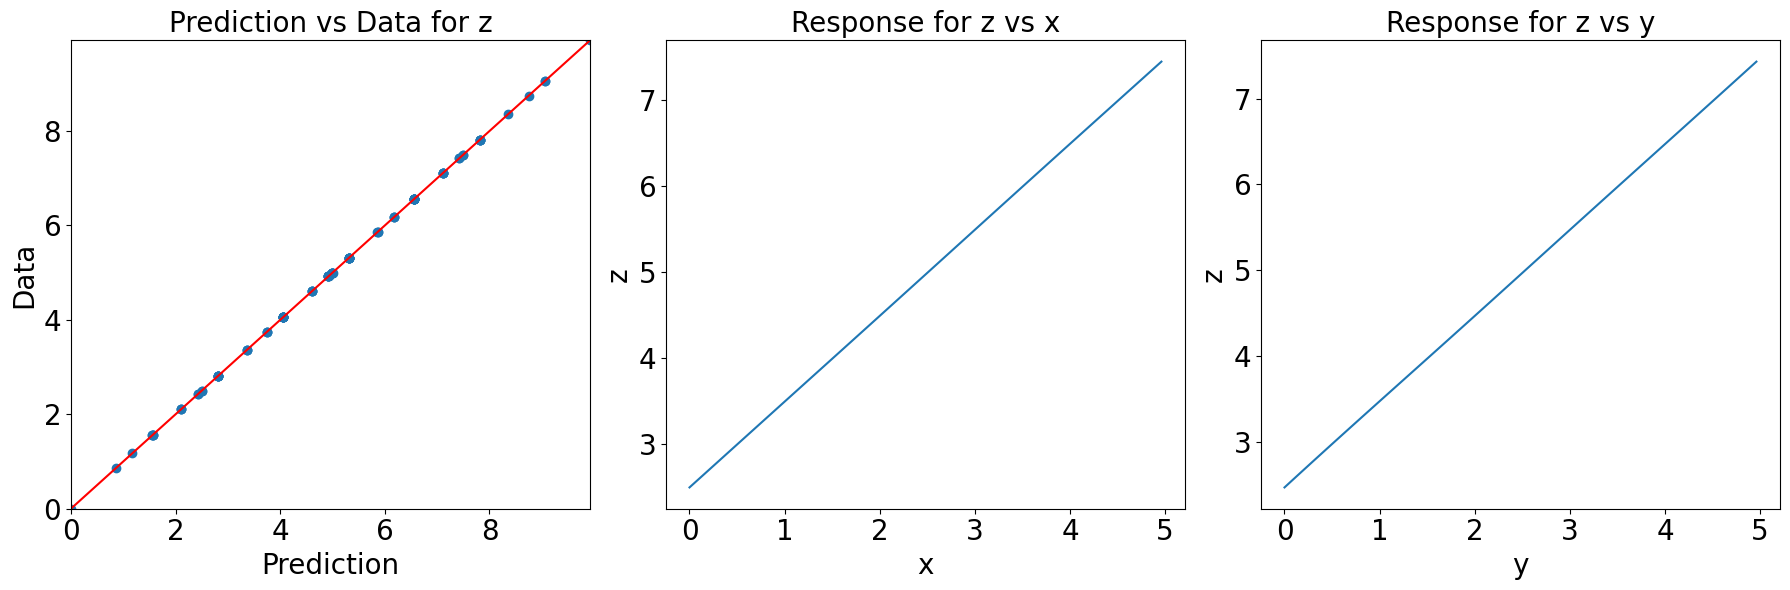

nrmse 0.00017142272922835415


In [ ]:
params = RegressorPlotParameters(regressor,
                                 regressor.parameters.input_data.mean(),
                                 regressor.parameters.input_data.min(),
                                 regressor.parameters.input_data.max())

reg_plot = RegressorPlot(params)

reg_plot.plot()

print("nrmse", regressor.error_metrics()['nrmse'])

# Lets look at the changed parameters

In [11]:
after = pd.Series({'booster':regressor.parameters.booster,
                    'gamma':regressor.parameters.gamma,
                    'max_depth':regressor.parameters.max_depth,
                    'min_child_weight':regressor.parameters.min_child_weight,
                    'n_estimators':regressor.parameters.n_estimators,
                    'num_parallel_tree':regressor.parameters.num_parallel_tree,
                    'learning_rate':regressor.parameters.learning_rate,
                    'nrmse':regressor.error_metrics()['nrmse']})

In [12]:
pd.DataFrame({'before':before, 'after':after})

,before,after
booster,gbtree,gblinear
gamma,None,0.006247
max_depth,None,10
min_child_weight,None,0.000093
n_estimators,100,169
num_parallel_tree,None,9
learning_rate,None,0.990795
nrmse,0.009587,0.0
